In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    # rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [7]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    gQs2 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                         action_size=action_size, reuse=True)
    gQs2 = tf.reshape(gQs2, shape=[-1]) * (1-dones)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                    labels=tf.zeros_like(gQs2))) # 0-1
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                     labels=tf.ones_like(gQs2))) # 0-1
    # ##################################################### repeatable!
    # next_states_logits = generator(actions=next_actions_logits, hidden_size=hidden_size, state_size=state_size, 
    #                                reuse=True)
    # next_actions_logits = actor(states=next_states_logits, hidden_size=hidden_size, action_size=action_size, 
    #                             reuse=True)
    # gQs3 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states_logits, 
    #                      action_size=action_size, reuse=True)
    # dones2 = tf.concat(axis=0, values=[dones[1:], tf.ones(shape=[1])])
    # gQs3 = tf.reshape(gQs3, shape=[-1]) * (1-dones2)
    # dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                 labels=tf.zeros_like(gQs3))) # 0-1
    # aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs3, # GAN
    #                                                                  labels=tf.ones_like(gQs3))) # 0-1
    return actions_logits, aloss, dloss, aloss2

In [8]:
def model_opt(a_loss, d_loss, a_loss2, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    #g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        d_loss=self.d_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [10]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [11]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [13]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
# gamma = 0.99                   # future reward discount

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, 
              d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [15]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                #rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                #rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                #if np.count_nonzero(dones)==1 and len(dones) >= 1 and np.max(rates) > 0:
                if len(dones) > 1:
                    # print('np.count_nonzero(dones)==1 and len(dones) >= 1 and np.max(rates) > 0: ', 
                    #       np.count_nonzero(dones), len(dones), np.max(rates))
                    break
            #             if np.count_nonzero(dones)!=1 and len(dones) < 1 and np.max(rates) <= 0:
            #                 print(np.count_nonzero(dones), len(dones), np.max(rates))
            #                 break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                feed_dict = {model.states: states, 
                                            model.actions: actions,
                                            model.next_states: next_states,
                                            #model.rewards: rewards,
                                            model.dones: dones,
                                            model.rates: rates})
            dloss, _ = sess.run([model.d_loss, model.d_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               #model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              #model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print('dones:', 
            #       len(dones), np.count_nonzero(dones), 
            #       len(dones1), np.count_nonzero(dones1), 
            #       len(dones2), np.count_nonzero(dones2))
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:18.0000 R:18.0000 rate:0.0360 aloss:1.3902 dloss:2.1134 aloss2:1.3848 exploreP:0.9982
Episode:1 meanR:20.5000 R:23.0000 rate:0.0460 aloss:1.3936 dloss:2.1265 aloss2:1.3642 exploreP:0.9959
Episode:2 meanR:19.0000 R:16.0000 rate:0.0320 aloss:1.3883 dloss:2.1070 aloss2:1.3844 exploreP:0.9944
Episode:3 meanR:19.7500 R:22.0000 rate:0.0440 aloss:1.3865 dloss:2.1129 aloss2:1.3687 exploreP:0.9922
Episode:4 meanR:19.4000 R:18.0000 rate:0.0360 aloss:1.3847 dloss:2.1002 aloss2:1.3760 exploreP:0.9904
Episode:5 meanR:19.0000 R:17.0000 rate:0.0340 aloss:1.3781 dloss:2.0706 aloss2:1.4102 exploreP:0.9888
Episode:6 meanR:18.0000 R:12.0000 rate:0.0240 aloss:1.3829 dloss:2.0990 aloss2:1.3731 exploreP:0.9876
Episode:7 meanR:18.1250 R:19.0000 rate:0.0380 aloss:1.3814 dloss:2.0816 aloss2:1.3860 exploreP:0.9857
Episode:8 meanR:17.5556 R:13.0000 rate:0.0260 aloss:1.3770 dloss:2.0634 aloss2:1.4065 exploreP:0.9845
Episode:9 meanR:19.5000 R:37.0000 rate:0.0740 aloss:1.3861 dloss:2.0809 aloss2:1.3

Episode:80 meanR:24.5309 R:8.0000 rate:0.0160 aloss:1.4382 dloss:1.0143 aloss2:2.8263 exploreP:0.8216
Episode:81 meanR:24.5000 R:22.0000 rate:0.0440 aloss:1.4437 dloss:0.9549 aloss2:2.9361 exploreP:0.8198
Episode:82 meanR:24.4337 R:19.0000 rate:0.0380 aloss:1.4296 dloss:0.9860 aloss2:2.8543 exploreP:0.8183
Episode:83 meanR:24.2619 R:10.0000 rate:0.0200 aloss:1.4362 dloss:0.9443 aloss2:3.0029 exploreP:0.8175
Episode:84 meanR:24.1294 R:13.0000 rate:0.0260 aloss:1.4521 dloss:0.9339 aloss2:3.0017 exploreP:0.8164
Episode:85 meanR:24.1163 R:23.0000 rate:0.0460 aloss:1.4564 dloss:0.9158 aloss2:3.0134 exploreP:0.8146
Episode:86 meanR:24.0460 R:18.0000 rate:0.0360 aloss:1.4409 dloss:0.9396 aloss2:2.9951 exploreP:0.8131
Episode:87 meanR:23.9318 R:14.0000 rate:0.0280 aloss:1.4460 dloss:0.9041 aloss2:3.0531 exploreP:0.8120
Episode:88 meanR:23.8876 R:20.0000 rate:0.0400 aloss:1.4478 dloss:0.9012 aloss2:3.0525 exploreP:0.8104
Episode:89 meanR:23.8222 R:18.0000 rate:0.0360 aloss:1.4638 dloss:0.8591 a

Episode:159 meanR:19.6200 R:17.0000 rate:0.0340 aloss:1.4190 dloss:0.5536 aloss2:5.3216 exploreP:0.7090
Episode:160 meanR:19.5500 R:36.0000 rate:0.0720 aloss:1.4597 dloss:0.5737 aloss2:5.4606 exploreP:0.7065
Episode:161 meanR:19.3800 R:12.0000 rate:0.0240 aloss:1.4481 dloss:0.5816 aloss2:5.6025 exploreP:0.7056
Episode:162 meanR:19.3500 R:16.0000 rate:0.0320 aloss:1.4044 dloss:0.5827 aloss2:5.5412 exploreP:0.7045
Episode:163 meanR:19.2800 R:20.0000 rate:0.0400 aloss:1.3941 dloss:0.5652 aloss2:5.5197 exploreP:0.7031
Episode:164 meanR:19.4000 R:22.0000 rate:0.0440 aloss:1.4400 dloss:0.5975 aloss2:5.4573 exploreP:0.7016
Episode:165 meanR:19.4400 R:15.0000 rate:0.0300 aloss:1.4060 dloss:0.5475 aloss2:5.7153 exploreP:0.7006
Episode:166 meanR:19.3800 R:15.0000 rate:0.0300 aloss:1.4221 dloss:0.5814 aloss2:5.5617 exploreP:0.6995
Episode:167 meanR:19.3100 R:13.0000 rate:0.0260 aloss:1.4142 dloss:0.5864 aloss2:5.4731 exploreP:0.6986
Episode:168 meanR:19.3000 R:12.0000 rate:0.0240 aloss:1.4043 dlo

Episode:238 meanR:43.6300 R:53.0000 rate:0.1060 aloss:1.3712 dloss:0.5454 aloss2:6.1727 exploreP:0.4776
Episode:239 meanR:45.2400 R:172.0000 rate:0.3440 aloss:1.3786 dloss:0.5540 aloss2:6.1939 exploreP:0.4697
Episode:240 meanR:45.8600 R:73.0000 rate:0.1460 aloss:1.3820 dloss:0.5524 aloss2:6.2262 exploreP:0.4663
Episode:241 meanR:46.1400 R:39.0000 rate:0.0780 aloss:1.3695 dloss:0.5628 aloss2:6.2723 exploreP:0.4645
Episode:242 meanR:46.4900 R:61.0000 rate:0.1220 aloss:1.3755 dloss:0.5602 aloss2:6.2569 exploreP:0.4618
Episode:243 meanR:46.6100 R:24.0000 rate:0.0480 aloss:1.3691 dloss:0.5932 aloss2:6.0126 exploreP:0.4607
Episode:244 meanR:46.8500 R:43.0000 rate:0.0860 aloss:1.3734 dloss:0.5543 aloss2:6.1917 exploreP:0.4588
Episode:245 meanR:47.7300 R:103.0000 rate:0.2060 aloss:1.3724 dloss:0.5713 aloss2:6.1738 exploreP:0.4542
Episode:246 meanR:48.4400 R:87.0000 rate:0.1740 aloss:1.3785 dloss:0.5391 aloss2:6.2126 exploreP:0.4503
Episode:247 meanR:50.3800 R:206.0000 rate:0.4120 aloss:1.3745 

Episode:316 meanR:156.4400 R:131.0000 rate:0.2620 aloss:1.3717 dloss:0.7588 aloss2:5.3639 exploreP:0.1254
Episode:317 meanR:157.0300 R:135.0000 rate:0.2700 aloss:1.3669 dloss:0.8302 aloss2:5.2997 exploreP:0.1239
Episode:318 meanR:158.1000 R:156.0000 rate:0.3120 aloss:1.3713 dloss:0.7921 aloss2:5.2740 exploreP:0.1221
Episode:319 meanR:159.0100 R:137.0000 rate:0.2740 aloss:1.3682 dloss:0.7919 aloss2:5.2528 exploreP:0.1206
Episode:320 meanR:159.3100 R:141.0000 rate:0.2820 aloss:1.3656 dloss:0.8367 aloss2:5.2141 exploreP:0.1190
Episode:321 meanR:160.1800 R:169.0000 rate:0.3380 aloss:1.3696 dloss:0.7417 aloss2:5.2699 exploreP:0.1172
Episode:322 meanR:161.2800 R:212.0000 rate:0.4240 aloss:1.3649 dloss:0.7864 aloss2:5.2671 exploreP:0.1150
Episode:323 meanR:162.1100 R:188.0000 rate:0.3760 aloss:1.3736 dloss:0.7811 aloss2:5.2534 exploreP:0.1130
Episode:324 meanR:162.2600 R:107.0000 rate:0.2140 aloss:1.3720 dloss:0.8242 aloss2:5.2359 exploreP:0.1119
Episode:325 meanR:162.1300 R:84.0000 rate:0.16

Episode:394 meanR:158.3700 R:195.0000 rate:0.3900 aloss:1.3650 dloss:0.8640 aloss2:4.9384 exploreP:0.0445
Episode:395 meanR:158.5600 R:147.0000 rate:0.2940 aloss:1.3635 dloss:0.9745 aloss2:4.8360 exploreP:0.0440
Episode:396 meanR:157.8500 R:125.0000 rate:0.2500 aloss:1.3594 dloss:0.8336 aloss2:4.8808 exploreP:0.0436
Episode:397 meanR:158.1900 R:153.0000 rate:0.3060 aloss:1.3542 dloss:0.9253 aloss2:4.8736 exploreP:0.0431
Episode:398 meanR:157.8200 R:103.0000 rate:0.2060 aloss:1.3653 dloss:0.9914 aloss2:4.8271 exploreP:0.0427
Episode:399 meanR:155.7300 R:160.0000 rate:0.3200 aloss:1.3641 dloss:0.7957 aloss2:4.8578 exploreP:0.0422
Episode:400 meanR:153.2700 R:62.0000 rate:0.1240 aloss:1.3700 dloss:0.8465 aloss2:4.9625 exploreP:0.0420
Episode:401 meanR:152.7900 R:105.0000 rate:0.2100 aloss:1.3563 dloss:0.9045 aloss2:4.9352 exploreP:0.0417
Episode:402 meanR:153.1500 R:167.0000 rate:0.3340 aloss:1.3604 dloss:0.9653 aloss2:4.8859 exploreP:0.0412
Episode:403 meanR:153.0600 R:113.0000 rate:0.22

Episode:472 meanR:170.0700 R:156.0000 rate:0.3120 aloss:1.3263 dloss:1.0176 aloss2:4.3398 exploreP:0.0191
Episode:473 meanR:170.8000 R:164.0000 rate:0.3280 aloss:1.3357 dloss:0.9842 aloss2:4.3989 exploreP:0.0190
Episode:474 meanR:171.5900 R:241.0000 rate:0.4820 aloss:1.3335 dloss:1.0529 aloss2:4.3624 exploreP:0.0188
Episode:475 meanR:172.5500 R:149.0000 rate:0.2980 aloss:1.3291 dloss:1.0997 aloss2:4.3865 exploreP:0.0186
Episode:476 meanR:174.4300 R:289.0000 rate:0.5780 aloss:1.3220 dloss:1.1121 aloss2:4.3360 exploreP:0.0184
Episode:477 meanR:171.3800 R:86.0000 rate:0.1720 aloss:1.3385 dloss:0.9826 aloss2:4.3426 exploreP:0.0183
Episode:478 meanR:171.4500 R:209.0000 rate:0.4180 aloss:1.3206 dloss:1.0862 aloss2:4.3258 exploreP:0.0182
Episode:479 meanR:171.8800 R:187.0000 rate:0.3740 aloss:1.3248 dloss:1.0526 aloss2:4.3444 exploreP:0.0180
Episode:480 meanR:171.6400 R:92.0000 rate:0.1840 aloss:1.3379 dloss:1.0118 aloss2:4.3465 exploreP:0.0179
Episode:481 meanR:172.4200 R:135.0000 rate:0.270

Episode:550 meanR:278.3700 R:500.0000 rate:1.0000 aloss:1.2496 dloss:1.3839 aloss2:3.5472 exploreP:0.0109
Episode:551 meanR:281.5100 R:404.0000 rate:0.8080 aloss:1.2266 dloss:1.4250 aloss2:3.4714 exploreP:0.0109
Episode:552 meanR:284.9600 R:500.0000 rate:1.0000 aloss:1.2445 dloss:1.4117 aloss2:3.4437 exploreP:0.0108
Episode:553 meanR:286.9500 R:261.0000 rate:0.5220 aloss:1.2304 dloss:1.4163 aloss2:3.4819 exploreP:0.0108
Episode:554 meanR:290.9500 R:500.0000 rate:1.0000 aloss:1.2439 dloss:1.4168 aloss2:3.4321 exploreP:0.0108
Episode:555 meanR:290.8900 R:100.0000 rate:0.2000 aloss:1.2289 dloss:1.4354 aloss2:3.4830 exploreP:0.0107
Episode:556 meanR:290.1000 R:168.0000 rate:0.3360 aloss:1.2314 dloss:1.4372 aloss2:3.4642 exploreP:0.0107
Episode:557 meanR:290.9500 R:295.0000 rate:0.5900 aloss:1.2211 dloss:1.4331 aloss2:3.4202 exploreP:0.0107
Episode:558 meanR:292.7600 R:500.0000 rate:1.0000 aloss:1.2379 dloss:1.4170 aloss2:3.4216 exploreP:0.0107
Episode:559 meanR:290.6100 R:252.0000 rate:0.5

Episode:628 meanR:375.2200 R:368.0000 rate:0.7360 aloss:1.1814 dloss:1.7035 aloss2:2.7324 exploreP:0.0100
Episode:629 meanR:375.2900 R:424.0000 rate:0.8480 aloss:1.1798 dloss:1.7139 aloss2:2.7443 exploreP:0.0100
Episode:630 meanR:378.6200 R:500.0000 rate:1.0000 aloss:1.1842 dloss:1.7082 aloss2:2.7140 exploreP:0.0100
Episode:631 meanR:380.5100 R:294.0000 rate:0.5880 aloss:1.1860 dloss:1.7038 aloss2:2.7498 exploreP:0.0100
Episode:632 meanR:378.4000 R:289.0000 rate:0.5780 aloss:1.1667 dloss:1.7345 aloss2:2.6907 exploreP:0.0100
Episode:633 meanR:378.4000 R:500.0000 rate:1.0000 aloss:1.1771 dloss:1.7261 aloss2:2.6909 exploreP:0.0100
Episode:634 meanR:379.4400 R:404.0000 rate:0.8080 aloss:1.1691 dloss:1.7357 aloss2:2.6741 exploreP:0.0100
Episode:635 meanR:377.5000 R:306.0000 rate:0.6120 aloss:1.1757 dloss:1.7463 aloss2:2.6491 exploreP:0.0100
Episode:636 meanR:375.1600 R:266.0000 rate:0.5320 aloss:1.1686 dloss:1.7450 aloss2:2.6617 exploreP:0.0100
Episode:637 meanR:374.9200 R:476.0000 rate:0.9

Episode:706 meanR:352.3300 R:277.0000 rate:0.5540 aloss:1.1374 dloss:1.8002 aloss2:2.4469 exploreP:0.0100
Episode:707 meanR:351.6900 R:336.0000 rate:0.6720 aloss:1.1422 dloss:1.8115 aloss2:2.4645 exploreP:0.0100
Episode:708 meanR:353.4000 R:400.0000 rate:0.8000 aloss:1.1400 dloss:1.8094 aloss2:2.4562 exploreP:0.0100
Episode:709 meanR:355.7200 R:364.0000 rate:0.7280 aloss:1.1399 dloss:1.8200 aloss2:2.4459 exploreP:0.0100
Episode:710 meanR:355.7200 R:312.0000 rate:0.6240 aloss:1.1420 dloss:1.8262 aloss2:2.4420 exploreP:0.0100
Episode:711 meanR:353.1600 R:244.0000 rate:0.4880 aloss:1.1405 dloss:1.8274 aloss2:2.4251 exploreP:0.0100
Episode:712 meanR:350.8900 R:273.0000 rate:0.5460 aloss:1.1402 dloss:1.8221 aloss2:2.4254 exploreP:0.0100
Episode:713 meanR:350.3600 R:320.0000 rate:0.6400 aloss:1.1414 dloss:1.8097 aloss2:2.4318 exploreP:0.0100
Episode:714 meanR:349.1000 R:345.0000 rate:0.6900 aloss:1.1424 dloss:1.8202 aloss2:2.4392 exploreP:0.0100
Episode:715 meanR:346.9000 R:70.0000 rate:0.14

Episode:784 meanR:208.6200 R:144.0000 rate:0.2880 aloss:1.1185 dloss:1.7843 aloss2:2.5010 exploreP:0.0100
Episode:785 meanR:206.9400 R:332.0000 rate:0.6640 aloss:1.1158 dloss:1.7785 aloss2:2.5134 exploreP:0.0100
Episode:786 meanR:205.1400 R:174.0000 rate:0.3480 aloss:1.1179 dloss:1.7701 aloss2:2.5108 exploreP:0.0100
Episode:787 meanR:200.9300 R:76.0000 rate:0.1520 aloss:1.1206 dloss:1.7720 aloss2:2.5204 exploreP:0.0100
Episode:788 meanR:200.7800 R:191.0000 rate:0.3820 aloss:1.1209 dloss:1.7873 aloss2:2.5076 exploreP:0.0100
Episode:789 meanR:200.1200 R:211.0000 rate:0.4220 aloss:1.1177 dloss:1.7798 aloss2:2.4977 exploreP:0.0100
Episode:790 meanR:197.2700 R:72.0000 rate:0.1440 aloss:1.1206 dloss:1.7652 aloss2:2.5074 exploreP:0.0100
Episode:791 meanR:197.0400 R:374.0000 rate:0.7480 aloss:1.1158 dloss:1.7738 aloss2:2.5184 exploreP:0.0100
Episode:792 meanR:196.0100 R:216.0000 rate:0.4320 aloss:1.1099 dloss:1.7678 aloss2:2.5153 exploreP:0.0100
Episode:793 meanR:194.8700 R:196.0000 rate:0.392

Episode:862 meanR:195.6800 R:161.0000 rate:0.3220 aloss:1.0639 dloss:1.4217 aloss2:3.2336 exploreP:0.0100
Episode:863 meanR:195.6200 R:195.0000 rate:0.3900 aloss:1.0642 dloss:1.4167 aloss2:3.2866 exploreP:0.0100
Episode:864 meanR:197.1000 R:266.0000 rate:0.5320 aloss:1.0616 dloss:1.4145 aloss2:3.2873 exploreP:0.0100
Episode:865 meanR:196.6600 R:271.0000 rate:0.5420 aloss:1.0584 dloss:1.4080 aloss2:3.3151 exploreP:0.0100
Episode:866 meanR:196.9400 R:158.0000 rate:0.3160 aloss:1.0577 dloss:1.3896 aloss2:3.3777 exploreP:0.0100
Episode:867 meanR:197.0400 R:205.0000 rate:0.4100 aloss:1.0629 dloss:1.3866 aloss2:3.3661 exploreP:0.0100
Episode:868 meanR:195.8200 R:56.0000 rate:0.1120 aloss:1.0677 dloss:1.4152 aloss2:3.2839 exploreP:0.0100
Episode:869 meanR:195.0400 R:161.0000 rate:0.3220 aloss:1.0572 dloss:1.3838 aloss2:3.3806 exploreP:0.0100
Episode:870 meanR:194.9600 R:158.0000 rate:0.3160 aloss:1.0591 dloss:1.3605 aloss2:3.4591 exploreP:0.0100
Episode:871 meanR:193.3700 R:31.0000 rate:0.062

Episode:940 meanR:188.6600 R:119.0000 rate:0.2380 aloss:1.0639 dloss:1.1962 aloss2:4.8952 exploreP:0.0100
Episode:941 meanR:186.8300 R:130.0000 rate:0.2600 aloss:1.0445 dloss:1.1847 aloss2:4.9701 exploreP:0.0100
Episode:942 meanR:185.7600 R:214.0000 rate:0.4280 aloss:1.0570 dloss:1.1707 aloss2:4.9765 exploreP:0.0100
Episode:943 meanR:186.0500 R:158.0000 rate:0.3160 aloss:1.0610 dloss:1.1674 aloss2:4.9248 exploreP:0.0100
Episode:944 meanR:185.7300 R:155.0000 rate:0.3100 aloss:1.0582 dloss:1.1730 aloss2:4.9588 exploreP:0.0100
Episode:945 meanR:184.4700 R:125.0000 rate:0.2500 aloss:1.0518 dloss:1.1775 aloss2:4.8923 exploreP:0.0100
Episode:946 meanR:182.8300 R:211.0000 rate:0.4220 aloss:1.0538 dloss:1.1777 aloss2:4.8980 exploreP:0.0100
Episode:947 meanR:182.9800 R:176.0000 rate:0.3520 aloss:1.0474 dloss:1.1678 aloss2:5.0126 exploreP:0.0100
Episode:948 meanR:180.9600 R:158.0000 rate:0.3160 aloss:1.0582 dloss:1.1537 aloss2:5.1446 exploreP:0.0100
Episode:949 meanR:178.8300 R:133.0000 rate:0.2

Episode:1018 meanR:132.3900 R:154.0000 rate:0.3080 aloss:1.0405 dloss:1.0627 aloss2:5.6191 exploreP:0.0100
Episode:1019 meanR:132.1400 R:11.0000 rate:0.0220 aloss:1.0543 dloss:1.0763 aloss2:5.0417 exploreP:0.0100
Episode:1020 meanR:131.7100 R:128.0000 rate:0.2560 aloss:1.0594 dloss:1.0452 aloss2:5.8566 exploreP:0.0100
Episode:1021 meanR:130.8000 R:154.0000 rate:0.3080 aloss:1.0390 dloss:1.0720 aloss2:5.4690 exploreP:0.0100
Episode:1022 meanR:129.4700 R:16.0000 rate:0.0320 aloss:1.0381 dloss:1.0443 aloss2:5.4482 exploreP:0.0100
Episode:1023 meanR:129.0600 R:82.0000 rate:0.1640 aloss:1.0382 dloss:1.0611 aloss2:5.6849 exploreP:0.0100
Episode:1024 meanR:128.1500 R:84.0000 rate:0.1680 aloss:1.0299 dloss:1.0427 aloss2:5.8225 exploreP:0.0100
Episode:1025 meanR:126.3000 R:14.0000 rate:0.0280 aloss:1.0232 dloss:1.0962 aloss2:5.3656 exploreP:0.0100
Episode:1026 meanR:126.4200 R:156.0000 rate:0.3120 aloss:1.0465 dloss:1.0437 aloss2:5.8236 exploreP:0.0100
Episode:1027 meanR:125.3400 R:96.0000 rate

Episode:1096 meanR:77.8000 R:20.0000 rate:0.0400 aloss:1.0234 dloss:1.0229 aloss2:6.6653 exploreP:0.0100
Episode:1097 meanR:77.6100 R:83.0000 rate:0.1660 aloss:1.0346 dloss:1.0314 aloss2:6.1447 exploreP:0.0100
Episode:1098 meanR:77.9800 R:155.0000 rate:0.3100 aloss:1.0392 dloss:1.0198 aloss2:6.3975 exploreP:0.0100
Episode:1099 meanR:77.4400 R:108.0000 rate:0.2160 aloss:1.0373 dloss:1.0230 aloss2:6.2992 exploreP:0.0100
Episode:1100 meanR:76.3900 R:30.0000 rate:0.0600 aloss:1.0251 dloss:1.0123 aloss2:6.1458 exploreP:0.0100
Episode:1101 meanR:76.4600 R:69.0000 rate:0.1380 aloss:1.0318 dloss:1.0283 aloss2:6.1250 exploreP:0.0100
Episode:1102 meanR:75.7100 R:20.0000 rate:0.0400 aloss:1.0510 dloss:0.9994 aloss2:6.3434 exploreP:0.0100
Episode:1103 meanR:75.2500 R:22.0000 rate:0.0440 aloss:1.0318 dloss:1.0314 aloss2:6.4448 exploreP:0.0100
Episode:1104 meanR:75.5200 R:138.0000 rate:0.2760 aloss:1.0324 dloss:1.0172 aloss2:6.3082 exploreP:0.0100
Episode:1105 meanR:74.7300 R:38.0000 rate:0.0760 alo

Episode:1174 meanR:63.4200 R:86.0000 rate:0.1720 aloss:1.0423 dloss:1.0047 aloss2:6.9484 exploreP:0.0100
Episode:1175 meanR:63.3700 R:81.0000 rate:0.1620 aloss:1.0367 dloss:1.0076 aloss2:6.7697 exploreP:0.0100
Episode:1176 meanR:62.5300 R:65.0000 rate:0.1300 aloss:1.0418 dloss:1.0142 aloss2:6.6317 exploreP:0.0100
Episode:1177 meanR:62.6100 R:44.0000 rate:0.0880 aloss:1.0199 dloss:1.0072 aloss2:6.6588 exploreP:0.0100
Episode:1178 meanR:63.2900 R:95.0000 rate:0.1900 aloss:1.0276 dloss:1.0029 aloss2:6.6621 exploreP:0.0100
Episode:1179 meanR:63.3600 R:54.0000 rate:0.1080 aloss:1.0321 dloss:1.0232 aloss2:6.5003 exploreP:0.0100
Episode:1180 meanR:63.2300 R:77.0000 rate:0.1540 aloss:1.0456 dloss:0.9924 aloss2:7.0184 exploreP:0.0100
Episode:1181 meanR:63.5300 R:44.0000 rate:0.0880 aloss:1.0249 dloss:1.0385 aloss2:6.2026 exploreP:0.0100
Episode:1182 meanR:62.1100 R:14.0000 rate:0.0280 aloss:1.0570 dloss:0.9730 aloss2:6.9995 exploreP:0.0100
Episode:1183 meanR:61.4100 R:14.0000 rate:0.0280 aloss:

Episode:1252 meanR:56.9300 R:62.0000 rate:0.1240 aloss:1.0144 dloss:1.0157 aloss2:6.9724 exploreP:0.0100
Episode:1253 meanR:56.0600 R:20.0000 rate:0.0400 aloss:1.0399 dloss:0.9665 aloss2:6.7996 exploreP:0.0100
Episode:1254 meanR:55.6200 R:22.0000 rate:0.0440 aloss:1.0175 dloss:0.9758 aloss2:7.1082 exploreP:0.0100
Episode:1255 meanR:56.0400 R:78.0000 rate:0.1560 aloss:1.0266 dloss:0.9976 aloss2:7.1420 exploreP:0.0100
Episode:1256 meanR:55.6500 R:94.0000 rate:0.1880 aloss:1.0306 dloss:0.9821 aloss2:7.1277 exploreP:0.0100
Episode:1257 meanR:55.6900 R:14.0000 rate:0.0280 aloss:1.0305 dloss:1.0477 aloss2:6.6060 exploreP:0.0100
Episode:1258 meanR:56.1400 R:85.0000 rate:0.1700 aloss:1.0230 dloss:1.0008 aloss2:7.2142 exploreP:0.0100
Episode:1259 meanR:55.6000 R:36.0000 rate:0.0720 aloss:1.0345 dloss:1.0054 aloss2:7.0408 exploreP:0.0100
Episode:1260 meanR:56.2900 R:83.0000 rate:0.1660 aloss:1.0367 dloss:0.9887 aloss2:7.3508 exploreP:0.0100
Episode:1261 meanR:56.6800 R:59.0000 rate:0.1180 aloss:

Episode:1330 meanR:53.9000 R:58.0000 rate:0.1160 aloss:1.0246 dloss:0.9792 aloss2:7.6369 exploreP:0.0100
Episode:1331 meanR:54.0100 R:76.0000 rate:0.1520 aloss:1.0254 dloss:0.9941 aloss2:7.4009 exploreP:0.0100
Episode:1332 meanR:54.6400 R:75.0000 rate:0.1500 aloss:1.0286 dloss:0.9925 aloss2:7.5477 exploreP:0.0100
Episode:1333 meanR:54.5900 R:71.0000 rate:0.1420 aloss:1.0160 dloss:0.9789 aloss2:7.4616 exploreP:0.0100
Episode:1334 meanR:54.5100 R:26.0000 rate:0.0520 aloss:1.0173 dloss:0.9879 aloss2:7.8199 exploreP:0.0100
Episode:1335 meanR:53.9500 R:22.0000 rate:0.0440 aloss:1.0107 dloss:1.0007 aloss2:7.6184 exploreP:0.0100
Episode:1336 meanR:54.1100 R:28.0000 rate:0.0560 aloss:1.0360 dloss:1.0035 aloss2:6.9492 exploreP:0.0100
Episode:1337 meanR:54.0300 R:16.0000 rate:0.0320 aloss:1.0254 dloss:1.0046 aloss2:7.1529 exploreP:0.0100
Episode:1338 meanR:53.7800 R:28.0000 rate:0.0560 aloss:1.0284 dloss:1.0060 aloss2:7.2273 exploreP:0.0100
Episode:1339 meanR:54.3700 R:71.0000 rate:0.1420 aloss:

Episode:1408 meanR:53.2200 R:16.0000 rate:0.0320 aloss:1.0492 dloss:0.9825 aloss2:9.0032 exploreP:0.0100
Episode:1409 meanR:53.4100 R:68.0000 rate:0.1360 aloss:1.0183 dloss:0.9503 aloss2:8.1833 exploreP:0.0100
Episode:1410 meanR:52.7700 R:54.0000 rate:0.1080 aloss:1.0188 dloss:0.9534 aloss2:8.0202 exploreP:0.0100
Episode:1411 meanR:52.4200 R:38.0000 rate:0.0760 aloss:1.0016 dloss:0.9660 aloss2:8.4303 exploreP:0.0100
Episode:1412 meanR:53.0700 R:75.0000 rate:0.1500 aloss:1.0270 dloss:0.9472 aloss2:8.5832 exploreP:0.0100
Episode:1413 meanR:52.9300 R:42.0000 rate:0.0840 aloss:1.0181 dloss:0.9407 aloss2:8.0064 exploreP:0.0100
Episode:1414 meanR:53.3500 R:56.0000 rate:0.1120 aloss:1.0037 dloss:0.9337 aloss2:8.4275 exploreP:0.0100
Episode:1415 meanR:53.0800 R:36.0000 rate:0.0720 aloss:1.0139 dloss:1.0141 aloss2:7.8171 exploreP:0.0100
Episode:1416 meanR:52.8300 R:38.0000 rate:0.0760 aloss:1.0234 dloss:0.9523 aloss2:8.9089 exploreP:0.0100
Episode:1417 meanR:52.3700 R:28.0000 rate:0.0560 aloss:

Episode:1487 meanR:52.4000 R:80.0000 rate:0.1600 aloss:1.0165 dloss:0.8983 aloss2:8.9073 exploreP:0.0100
Episode:1488 meanR:52.3100 R:13.0000 rate:0.0260 aloss:0.9984 dloss:0.9484 aloss2:9.2361 exploreP:0.0100
Episode:1489 meanR:51.9000 R:45.0000 rate:0.0900 aloss:1.0158 dloss:0.9191 aloss2:8.8294 exploreP:0.0100
Episode:1490 meanR:51.5600 R:45.0000 rate:0.0900 aloss:1.0105 dloss:0.9596 aloss2:8.9816 exploreP:0.0100
Episode:1491 meanR:51.8400 R:77.0000 rate:0.1540 aloss:1.0017 dloss:0.9481 aloss2:8.9080 exploreP:0.0100
Episode:1492 meanR:51.6800 R:46.0000 rate:0.0920 aloss:1.0115 dloss:0.9419 aloss2:8.7787 exploreP:0.0100
Episode:1493 meanR:51.2200 R:28.0000 rate:0.0560 aloss:0.9821 dloss:0.9564 aloss2:10.4220 exploreP:0.0100
Episode:1494 meanR:50.8600 R:70.0000 rate:0.1400 aloss:1.0088 dloss:0.9269 aloss2:9.3595 exploreP:0.0100
Episode:1495 meanR:51.4200 R:102.0000 rate:0.2040 aloss:1.0217 dloss:0.9210 aloss2:9.1411 exploreP:0.0100
Episode:1496 meanR:50.7800 R:15.0000 rate:0.0300 alos

Episode:1565 meanR:56.3000 R:62.0000 rate:0.1240 aloss:1.0061 dloss:0.9102 aloss2:9.1944 exploreP:0.0100
Episode:1566 meanR:56.7600 R:124.0000 rate:0.2480 aloss:1.0046 dloss:0.9065 aloss2:9.4360 exploreP:0.0100
Episode:1567 meanR:57.2400 R:84.0000 rate:0.1680 aloss:0.9994 dloss:0.9096 aloss2:9.3391 exploreP:0.0100
Episode:1568 meanR:57.1400 R:34.0000 rate:0.0680 aloss:1.0014 dloss:0.8936 aloss2:9.3453 exploreP:0.0100
Episode:1569 meanR:57.6400 R:84.0000 rate:0.1680 aloss:1.0017 dloss:0.9203 aloss2:9.5708 exploreP:0.0100
Episode:1570 meanR:57.7200 R:49.0000 rate:0.0980 aloss:1.0414 dloss:0.9116 aloss2:9.7630 exploreP:0.0100
Episode:1571 meanR:57.5600 R:66.0000 rate:0.1320 aloss:1.0144 dloss:0.8928 aloss2:9.4851 exploreP:0.0100
Episode:1572 meanR:57.7000 R:66.0000 rate:0.1320 aloss:1.0028 dloss:0.9160 aloss2:9.1115 exploreP:0.0100
Episode:1573 meanR:58.2000 R:59.0000 rate:0.1180 aloss:1.0009 dloss:0.9217 aloss2:9.3985 exploreP:0.0100
Episode:1574 meanR:58.4000 R:36.0000 rate:0.0720 aloss

Episode:1643 meanR:58.8600 R:58.0000 rate:0.1160 aloss:1.0041 dloss:0.9067 aloss2:10.0177 exploreP:0.0100
Episode:1644 meanR:59.4500 R:89.0000 rate:0.1780 aloss:1.0038 dloss:0.9132 aloss2:9.3602 exploreP:0.0100
Episode:1645 meanR:59.0200 R:80.0000 rate:0.1600 aloss:0.9986 dloss:0.8963 aloss2:9.4998 exploreP:0.0100
Episode:1646 meanR:59.2000 R:79.0000 rate:0.1580 aloss:1.0081 dloss:0.8954 aloss2:9.3362 exploreP:0.0100
Episode:1647 meanR:58.8600 R:26.0000 rate:0.0520 aloss:1.0046 dloss:0.8873 aloss2:9.7373 exploreP:0.0100
Episode:1648 meanR:59.0200 R:38.0000 rate:0.0760 aloss:0.9944 dloss:0.9120 aloss2:9.5793 exploreP:0.0100
Episode:1649 meanR:59.2800 R:67.0000 rate:0.1340 aloss:1.0062 dloss:0.9043 aloss2:10.2336 exploreP:0.0100
Episode:1650 meanR:59.3600 R:42.0000 rate:0.0840 aloss:1.0062 dloss:0.8749 aloss2:9.4778 exploreP:0.0100
Episode:1651 meanR:58.5100 R:28.0000 rate:0.0560 aloss:1.0188 dloss:0.9006 aloss2:10.0024 exploreP:0.0100
Episode:1652 meanR:58.8500 R:58.0000 rate:0.1160 alo

Episode:1721 meanR:49.4000 R:43.0000 rate:0.0860 aloss:0.9987 dloss:0.8447 aloss2:10.0780 exploreP:0.0100
Episode:1722 meanR:49.7900 R:77.0000 rate:0.1540 aloss:1.0092 dloss:0.8696 aloss2:10.2642 exploreP:0.0100
Episode:1723 meanR:50.1100 R:98.0000 rate:0.1960 aloss:1.0134 dloss:0.8695 aloss2:10.4448 exploreP:0.0100
Episode:1724 meanR:50.5800 R:65.0000 rate:0.1300 aloss:1.0175 dloss:0.8675 aloss2:9.7711 exploreP:0.0100
Episode:1725 meanR:50.6000 R:34.0000 rate:0.0680 aloss:1.0079 dloss:0.8326 aloss2:9.8207 exploreP:0.0100
Episode:1726 meanR:50.5600 R:41.0000 rate:0.0820 aloss:1.0034 dloss:0.8916 aloss2:10.1744 exploreP:0.0100
Episode:1727 meanR:50.6500 R:39.0000 rate:0.0780 aloss:1.0081 dloss:0.8948 aloss2:10.3073 exploreP:0.0100
Episode:1728 meanR:50.9900 R:49.0000 rate:0.0980 aloss:1.0092 dloss:0.8492 aloss2:10.2184 exploreP:0.0100
Episode:1729 meanR:50.8400 R:11.0000 rate:0.0220 aloss:1.0169 dloss:0.9165 aloss2:9.3746 exploreP:0.0100
Episode:1730 meanR:50.2900 R:44.0000 rate:0.0880 

Episode:1799 meanR:46.7000 R:33.0000 rate:0.0660 aloss:0.9902 dloss:0.8156 aloss2:10.3170 exploreP:0.0100
Episode:1800 meanR:46.2800 R:42.0000 rate:0.0840 aloss:1.0129 dloss:0.8800 aloss2:10.3113 exploreP:0.0100
Episode:1801 meanR:45.6900 R:30.0000 rate:0.0600 aloss:1.0016 dloss:0.8093 aloss2:10.5753 exploreP:0.0100
Episode:1802 meanR:45.8700 R:63.0000 rate:0.1260 aloss:0.9964 dloss:0.8306 aloss2:10.3318 exploreP:0.0100
Episode:1803 meanR:45.4200 R:21.0000 rate:0.0420 aloss:1.0488 dloss:0.8669 aloss2:12.6007 exploreP:0.0100
Episode:1804 meanR:45.7100 R:71.0000 rate:0.1420 aloss:0.9889 dloss:0.8288 aloss2:10.8033 exploreP:0.0100
Episode:1805 meanR:46.0200 R:67.0000 rate:0.1340 aloss:0.9960 dloss:0.8437 aloss2:11.4081 exploreP:0.0100
Episode:1806 meanR:46.3300 R:75.0000 rate:0.1500 aloss:0.9959 dloss:0.8838 aloss2:11.0253 exploreP:0.0100
Episode:1807 meanR:46.2700 R:26.0000 rate:0.0520 aloss:1.0059 dloss:0.8810 aloss2:11.1643 exploreP:0.0100
Episode:1808 meanR:46.0000 R:19.0000 rate:0.03

Episode:1877 meanR:45.3800 R:109.0000 rate:0.2180 aloss:1.0092 dloss:0.8022 aloss2:11.6111 exploreP:0.0100
Episode:1878 meanR:45.3100 R:44.0000 rate:0.0880 aloss:0.9883 dloss:0.8183 aloss2:12.0775 exploreP:0.0100
Episode:1879 meanR:44.5300 R:15.0000 rate:0.0300 aloss:0.9979 dloss:0.8677 aloss2:11.4580 exploreP:0.0100
Episode:1880 meanR:44.7000 R:53.0000 rate:0.1060 aloss:0.9966 dloss:0.8515 aloss2:11.0608 exploreP:0.0100
Episode:1881 meanR:44.3900 R:32.0000 rate:0.0640 aloss:0.9861 dloss:0.7521 aloss2:10.8102 exploreP:0.0100
Episode:1882 meanR:45.0100 R:76.0000 rate:0.1520 aloss:0.9931 dloss:0.8127 aloss2:11.2129 exploreP:0.0100
Episode:1883 meanR:45.2200 R:32.0000 rate:0.0640 aloss:0.9933 dloss:0.8276 aloss2:11.0958 exploreP:0.0100
Episode:1884 meanR:44.5300 R:18.0000 rate:0.0360 aloss:0.9801 dloss:0.7908 aloss2:11.8447 exploreP:0.0100
Episode:1885 meanR:44.6500 R:28.0000 rate:0.0560 aloss:0.9961 dloss:0.8073 aloss2:11.6168 exploreP:0.0100
Episode:1886 meanR:45.6400 R:127.0000 rate:0.

Episode:1955 meanR:44.6200 R:32.0000 rate:0.0640 aloss:0.9876 dloss:0.7572 aloss2:11.6916 exploreP:0.0100
Episode:1956 meanR:44.0200 R:20.0000 rate:0.0400 aloss:1.0034 dloss:0.8359 aloss2:11.5105 exploreP:0.0100
Episode:1957 meanR:43.8600 R:12.0000 rate:0.0240 aloss:1.0127 dloss:0.8252 aloss2:12.1238 exploreP:0.0100
Episode:1958 meanR:43.9700 R:68.0000 rate:0.1360 aloss:1.0134 dloss:0.7855 aloss2:12.7856 exploreP:0.0100
Episode:1959 meanR:43.8400 R:21.0000 rate:0.0420 aloss:0.9812 dloss:0.8226 aloss2:12.6692 exploreP:0.0100
Episode:1960 meanR:43.9600 R:40.0000 rate:0.0800 aloss:1.0039 dloss:0.7873 aloss2:11.7733 exploreP:0.0100
Episode:1961 meanR:44.0200 R:38.0000 rate:0.0760 aloss:1.0078 dloss:0.8174 aloss2:11.6804 exploreP:0.0100
Episode:1962 meanR:43.9600 R:51.0000 rate:0.1020 aloss:1.0063 dloss:0.7982 aloss2:11.9678 exploreP:0.0100
Episode:1963 meanR:43.5400 R:39.0000 rate:0.0780 aloss:0.9973 dloss:0.7958 aloss2:12.6091 exploreP:0.0100
Episode:1964 meanR:43.5300 R:26.0000 rate:0.05

Episode:2033 meanR:39.9200 R:14.0000 rate:0.0280 aloss:1.0392 dloss:0.7677 aloss2:11.1496 exploreP:0.0100
Episode:2034 meanR:40.0500 R:58.0000 rate:0.1160 aloss:0.9880 dloss:0.7656 aloss2:12.4884 exploreP:0.0100
Episode:2035 meanR:38.8700 R:18.0000 rate:0.0360 aloss:0.9979 dloss:0.7820 aloss2:12.6476 exploreP:0.0100
Episode:2036 meanR:39.0900 R:45.0000 rate:0.0900 aloss:0.9966 dloss:0.7616 aloss2:12.8610 exploreP:0.0100
Episode:2037 meanR:38.9800 R:14.0000 rate:0.0280 aloss:0.9792 dloss:0.7277 aloss2:11.4967 exploreP:0.0100
Episode:2038 meanR:38.5300 R:26.0000 rate:0.0520 aloss:1.0558 dloss:0.8064 aloss2:12.4171 exploreP:0.0100
Episode:2039 meanR:39.0500 R:76.0000 rate:0.1520 aloss:0.9893 dloss:0.7889 aloss2:12.8701 exploreP:0.0100
Episode:2040 meanR:38.6300 R:28.0000 rate:0.0560 aloss:1.0297 dloss:0.7883 aloss2:12.4340 exploreP:0.0100
Episode:2041 meanR:38.4700 R:12.0000 rate:0.0240 aloss:0.9930 dloss:0.8575 aloss2:11.3690 exploreP:0.0100
Episode:2042 meanR:38.2700 R:16.0000 rate:0.03

Episode:2111 meanR:34.2200 R:26.0000 rate:0.0520 aloss:1.0052 dloss:0.7941 aloss2:11.6493 exploreP:0.0100
Episode:2112 meanR:34.3400 R:24.0000 rate:0.0480 aloss:1.0071 dloss:0.7688 aloss2:11.7748 exploreP:0.0100
Episode:2113 meanR:34.3700 R:17.0000 rate:0.0340 aloss:1.0977 dloss:0.7812 aloss2:13.6637 exploreP:0.0100
Episode:2114 meanR:34.4600 R:59.0000 rate:0.1180 aloss:0.9882 dloss:0.7944 aloss2:12.2967 exploreP:0.0100
Episode:2115 meanR:34.2100 R:17.0000 rate:0.0340 aloss:0.9862 dloss:0.7578 aloss2:12.0911 exploreP:0.0100
Episode:2116 meanR:34.0000 R:52.0000 rate:0.1040 aloss:1.0298 dloss:0.8023 aloss2:12.2750 exploreP:0.0100
Episode:2117 meanR:34.3200 R:62.0000 rate:0.1240 aloss:1.0128 dloss:0.7907 aloss2:12.9899 exploreP:0.0100
Episode:2118 meanR:34.5200 R:34.0000 rate:0.0680 aloss:0.9809 dloss:0.7707 aloss2:12.3928 exploreP:0.0100
Episode:2119 meanR:34.3600 R:34.0000 rate:0.0680 aloss:0.9809 dloss:0.8118 aloss2:11.8968 exploreP:0.0100
Episode:2120 meanR:34.0800 R:34.0000 rate:0.06

Episode:2189 meanR:40.0600 R:47.0000 rate:0.0940 aloss:0.9855 dloss:0.7595 aloss2:12.5099 exploreP:0.0100
Episode:2190 meanR:39.3100 R:13.0000 rate:0.0260 aloss:0.9865 dloss:0.7024 aloss2:12.1706 exploreP:0.0100
Episode:2191 meanR:39.8100 R:61.0000 rate:0.1220 aloss:1.0074 dloss:0.7606 aloss2:12.5283 exploreP:0.0100
Episode:2192 meanR:39.9800 R:43.0000 rate:0.0860 aloss:0.9848 dloss:0.7494 aloss2:12.0105 exploreP:0.0100
Episode:2193 meanR:40.3800 R:58.0000 rate:0.1160 aloss:0.9816 dloss:0.7526 aloss2:12.1797 exploreP:0.0100
Episode:2194 meanR:41.4000 R:127.0000 rate:0.2540 aloss:0.9824 dloss:0.7621 aloss2:12.3999 exploreP:0.0100
Episode:2195 meanR:41.6300 R:43.0000 rate:0.0860 aloss:0.9975 dloss:0.7434 aloss2:12.1605 exploreP:0.0100
Episode:2196 meanR:42.5000 R:117.0000 rate:0.2340 aloss:1.0027 dloss:0.7750 aloss2:12.6186 exploreP:0.0100
Episode:2197 meanR:41.9100 R:28.0000 rate:0.0560 aloss:0.9826 dloss:0.7623 aloss2:12.3331 exploreP:0.0100
Episode:2198 meanR:41.9000 R:27.0000 rate:0.

Episode:2267 meanR:63.5400 R:137.0000 rate:0.2740 aloss:0.9810 dloss:0.7345 aloss2:11.9949 exploreP:0.0100
Episode:2268 meanR:64.5100 R:123.0000 rate:0.2460 aloss:0.9753 dloss:0.7476 aloss2:12.0087 exploreP:0.0100
Episode:2269 meanR:65.3100 R:135.0000 rate:0.2700 aloss:0.9787 dloss:0.7574 aloss2:12.0949 exploreP:0.0100
Episode:2270 meanR:65.8200 R:69.0000 rate:0.1380 aloss:0.9814 dloss:0.7369 aloss2:11.9065 exploreP:0.0100
Episode:2271 meanR:65.5900 R:33.0000 rate:0.0660 aloss:1.0049 dloss:0.7548 aloss2:12.9361 exploreP:0.0100
Episode:2272 meanR:67.1900 R:192.0000 rate:0.3840 aloss:0.9753 dloss:0.7435 aloss2:12.1235 exploreP:0.0100
Episode:2273 meanR:68.1800 R:171.0000 rate:0.3420 aloss:0.9819 dloss:0.7287 aloss2:12.0884 exploreP:0.0100
Episode:2274 meanR:69.0600 R:109.0000 rate:0.2180 aloss:0.9789 dloss:0.7342 aloss2:12.1159 exploreP:0.0100
Episode:2275 meanR:69.7200 R:100.0000 rate:0.2000 aloss:0.9694 dloss:0.7232 aloss2:12.3131 exploreP:0.0100
Episode:2276 meanR:70.2100 R:60.0000 ra

Episode:2344 meanR:89.3700 R:94.0000 rate:0.1880 aloss:0.9626 dloss:0.6925 aloss2:12.7343 exploreP:0.0100
Episode:2345 meanR:89.7300 R:56.0000 rate:0.1120 aloss:0.9574 dloss:0.6804 aloss2:13.0020 exploreP:0.0100
Episode:2346 meanR:89.9000 R:57.0000 rate:0.1140 aloss:0.9678 dloss:0.6938 aloss2:12.6628 exploreP:0.0100
Episode:2347 meanR:89.4300 R:122.0000 rate:0.2440 aloss:0.9728 dloss:0.7063 aloss2:12.7203 exploreP:0.0100
Episode:2348 meanR:89.5000 R:124.0000 rate:0.2480 aloss:0.9684 dloss:0.7154 aloss2:12.8797 exploreP:0.0100
Episode:2349 meanR:90.6600 R:127.0000 rate:0.2540 aloss:0.9636 dloss:0.7306 aloss2:12.8805 exploreP:0.0100
Episode:2350 meanR:92.2800 R:179.0000 rate:0.3580 aloss:0.9667 dloss:0.7077 aloss2:12.5069 exploreP:0.0100
Episode:2351 meanR:92.1300 R:67.0000 rate:0.1340 aloss:0.9759 dloss:0.7162 aloss2:13.0559 exploreP:0.0100
Episode:2352 meanR:91.9600 R:25.0000 rate:0.0500 aloss:0.9642 dloss:0.7234 aloss2:12.4132 exploreP:0.0100
Episode:2353 meanR:92.0300 R:121.0000 rate

Episode:2421 meanR:113.4600 R:129.0000 rate:0.2580 aloss:0.9674 dloss:0.6973 aloss2:13.5501 exploreP:0.0100
Episode:2422 meanR:113.8800 R:142.0000 rate:0.2840 aloss:0.9633 dloss:0.7031 aloss2:14.0580 exploreP:0.0100
Episode:2423 meanR:115.3500 R:158.0000 rate:0.3160 aloss:0.9627 dloss:0.6880 aloss2:13.6720 exploreP:0.0100
Episode:2424 meanR:115.5400 R:128.0000 rate:0.2560 aloss:0.9708 dloss:0.6701 aloss2:13.8978 exploreP:0.0100
Episode:2425 meanR:117.0000 R:170.0000 rate:0.3400 aloss:0.9693 dloss:0.6838 aloss2:13.5297 exploreP:0.0100
Episode:2426 meanR:117.2700 R:143.0000 rate:0.2860 aloss:0.9641 dloss:0.6867 aloss2:14.3249 exploreP:0.0100
Episode:2427 meanR:116.9300 R:127.0000 rate:0.2540 aloss:0.9653 dloss:0.6802 aloss2:13.8280 exploreP:0.0100
Episode:2428 meanR:116.2300 R:25.0000 rate:0.0500 aloss:0.9735 dloss:0.6954 aloss2:14.2826 exploreP:0.0100
Episode:2429 meanR:115.0300 R:10.0000 rate:0.0200 aloss:0.9485 dloss:0.6530 aloss2:12.8852 exploreP:0.0100
Episode:2430 meanR:115.8800 R:

Episode:2497 meanR:120.9300 R:158.0000 rate:0.3160 aloss:0.9622 dloss:0.6749 aloss2:14.6107 exploreP:0.0100
Episode:2498 meanR:120.9200 R:108.0000 rate:0.2160 aloss:0.9647 dloss:0.6714 aloss2:14.3952 exploreP:0.0100
Episode:2499 meanR:120.3800 R:129.0000 rate:0.2580 aloss:0.9766 dloss:0.6642 aloss2:14.0803 exploreP:0.0100
Episode:2500 meanR:120.9600 R:130.0000 rate:0.2600 aloss:0.9601 dloss:0.6733 aloss2:14.9683 exploreP:0.0100
Episode:2501 meanR:120.9100 R:132.0000 rate:0.2640 aloss:0.9714 dloss:0.6616 aloss2:14.6412 exploreP:0.0100
Episode:2502 meanR:120.3800 R:51.0000 rate:0.1020 aloss:0.9752 dloss:0.6569 aloss2:13.8182 exploreP:0.0100
Episode:2503 meanR:120.1800 R:88.0000 rate:0.1760 aloss:0.9603 dloss:0.6631 aloss2:14.8683 exploreP:0.0100
Episode:2504 meanR:120.3800 R:141.0000 rate:0.2820 aloss:0.9760 dloss:0.6538 aloss2:14.2632 exploreP:0.0100
Episode:2505 meanR:120.5600 R:114.0000 rate:0.2280 aloss:0.9712 dloss:0.6713 aloss2:14.1200 exploreP:0.0100
Episode:2506 meanR:120.7900 R:

Episode:2573 meanR:120.6300 R:128.0000 rate:0.2560 aloss:0.9498 dloss:0.6516 aloss2:15.9727 exploreP:0.0100
Episode:2574 meanR:120.8100 R:113.0000 rate:0.2260 aloss:0.9544 dloss:0.6441 aloss2:15.3070 exploreP:0.0100
Episode:2575 meanR:121.2300 R:144.0000 rate:0.2880 aloss:0.9466 dloss:0.6525 aloss2:15.6508 exploreP:0.0100
Episode:2576 meanR:121.2800 R:118.0000 rate:0.2360 aloss:0.9528 dloss:0.6541 aloss2:15.4795 exploreP:0.0100
Episode:2577 meanR:121.2700 R:130.0000 rate:0.2600 aloss:0.9559 dloss:0.6420 aloss2:15.5389 exploreP:0.0100
Episode:2578 meanR:120.9400 R:128.0000 rate:0.2560 aloss:0.9496 dloss:0.6380 aloss2:16.2803 exploreP:0.0100
Episode:2579 meanR:120.9900 R:161.0000 rate:0.3220 aloss:0.9460 dloss:0.6376 aloss2:16.0203 exploreP:0.0100
Episode:2580 meanR:121.2900 R:153.0000 rate:0.3060 aloss:0.9420 dloss:0.6602 aloss2:15.9154 exploreP:0.0100
Episode:2581 meanR:121.1300 R:110.0000 rate:0.2200 aloss:0.9542 dloss:0.6501 aloss2:15.6605 exploreP:0.0100
Episode:2582 meanR:121.0800 

Episode:2649 meanR:119.7900 R:135.0000 rate:0.2700 aloss:0.9512 dloss:0.6441 aloss2:16.6320 exploreP:0.0100
Episode:2650 meanR:119.9600 R:117.0000 rate:0.2340 aloss:0.9474 dloss:0.6402 aloss2:16.8919 exploreP:0.0100
Episode:2651 meanR:119.9400 R:116.0000 rate:0.2320 aloss:0.9406 dloss:0.6388 aloss2:17.2927 exploreP:0.0100
Episode:2652 meanR:119.6800 R:136.0000 rate:0.2720 aloss:0.9441 dloss:0.6526 aloss2:16.6711 exploreP:0.0100
Episode:2653 meanR:119.6100 R:115.0000 rate:0.2300 aloss:0.9448 dloss:0.6568 aloss2:17.5648 exploreP:0.0100
Episode:2654 meanR:119.5900 R:129.0000 rate:0.2580 aloss:0.9433 dloss:0.6493 aloss2:16.9522 exploreP:0.0100
Episode:2655 meanR:119.8700 R:134.0000 rate:0.2680 aloss:0.9416 dloss:0.6524 aloss2:16.8745 exploreP:0.0100
Episode:2656 meanR:119.7200 R:101.0000 rate:0.2020 aloss:0.9372 dloss:0.6662 aloss2:17.6146 exploreP:0.0100
Episode:2657 meanR:120.0900 R:163.0000 rate:0.3260 aloss:0.9345 dloss:0.6414 aloss2:17.0540 exploreP:0.0100
Episode:2658 meanR:120.1800 

Episode:2725 meanR:118.1800 R:149.0000 rate:0.2980 aloss:0.9305 dloss:0.6546 aloss2:18.2535 exploreP:0.0100
Episode:2726 meanR:117.5700 R:112.0000 rate:0.2240 aloss:0.9322 dloss:0.6552 aloss2:17.9549 exploreP:0.0100
Episode:2727 meanR:117.1700 R:114.0000 rate:0.2280 aloss:0.9273 dloss:0.6369 aloss2:17.5394 exploreP:0.0100
Episode:2728 meanR:117.0800 R:115.0000 rate:0.2300 aloss:0.9252 dloss:0.6429 aloss2:18.4102 exploreP:0.0100
Episode:2729 meanR:117.0500 R:113.0000 rate:0.2260 aloss:0.9321 dloss:0.6376 aloss2:17.7211 exploreP:0.0100
Episode:2730 meanR:118.4700 R:152.0000 rate:0.3040 aloss:0.9394 dloss:0.6586 aloss2:18.0397 exploreP:0.0100
Episode:2731 meanR:118.4000 R:122.0000 rate:0.2440 aloss:0.9323 dloss:0.6355 aloss2:18.1268 exploreP:0.0100
Episode:2732 meanR:118.8600 R:157.0000 rate:0.3140 aloss:0.9220 dloss:0.6453 aloss2:18.7422 exploreP:0.0100
Episode:2733 meanR:118.7300 R:116.0000 rate:0.2320 aloss:0.9219 dloss:0.6535 aloss2:18.4125 exploreP:0.0100
Episode:2734 meanR:119.3000 

Episode:2802 meanR:112.5100 R:105.0000 rate:0.2100 aloss:0.9240 dloss:0.6432 aloss2:18.4348 exploreP:0.0100
Episode:2803 meanR:112.4000 R:115.0000 rate:0.2300 aloss:0.9258 dloss:0.6597 aloss2:18.3015 exploreP:0.0100
Episode:2804 meanR:113.3400 R:112.0000 rate:0.2240 aloss:0.9216 dloss:0.6551 aloss2:19.6291 exploreP:0.0100
Episode:2805 meanR:112.9700 R:68.0000 rate:0.1360 aloss:0.9251 dloss:0.6280 aloss2:19.3961 exploreP:0.0100
Episode:2806 meanR:112.8800 R:98.0000 rate:0.1960 aloss:0.9267 dloss:0.6444 aloss2:18.3218 exploreP:0.0100
Episode:2807 meanR:112.9600 R:122.0000 rate:0.2440 aloss:0.9225 dloss:0.6679 aloss2:18.9758 exploreP:0.0100
Episode:2808 meanR:113.0400 R:109.0000 rate:0.2180 aloss:0.9241 dloss:0.6604 aloss2:18.8572 exploreP:0.0100
Episode:2809 meanR:112.4200 R:97.0000 rate:0.1940 aloss:0.9272 dloss:0.6649 aloss2:19.1606 exploreP:0.0100
Episode:2810 meanR:112.2100 R:108.0000 rate:0.2160 aloss:0.9333 dloss:0.6389 aloss2:17.9408 exploreP:0.0100
Episode:2811 meanR:111.6800 R:1

Episode:2878 meanR:117.8500 R:107.0000 rate:0.2140 aloss:0.9298 dloss:0.6537 aloss2:18.6054 exploreP:0.0100
Episode:2879 meanR:117.7000 R:120.0000 rate:0.2400 aloss:0.9228 dloss:0.6508 aloss2:18.0103 exploreP:0.0100
Episode:2880 meanR:117.3000 R:116.0000 rate:0.2320 aloss:0.9223 dloss:0.6568 aloss2:18.8097 exploreP:0.0100
Episode:2881 meanR:117.5700 R:150.0000 rate:0.3000 aloss:0.9209 dloss:0.6515 aloss2:19.1497 exploreP:0.0100
Episode:2882 meanR:117.1900 R:57.0000 rate:0.1140 aloss:0.9257 dloss:0.6453 aloss2:18.2457 exploreP:0.0100
Episode:2883 meanR:117.2700 R:104.0000 rate:0.2080 aloss:0.9233 dloss:0.6609 aloss2:18.9061 exploreP:0.0100
Episode:2884 meanR:117.1900 R:99.0000 rate:0.1980 aloss:0.9148 dloss:0.6466 aloss2:19.4695 exploreP:0.0100
Episode:2885 meanR:117.4600 R:149.0000 rate:0.2980 aloss:0.9238 dloss:0.6627 aloss2:18.4735 exploreP:0.0100
Episode:2886 meanR:117.3600 R:106.0000 rate:0.2120 aloss:0.9208 dloss:0.6472 aloss2:18.6256 exploreP:0.0100
Episode:2887 meanR:117.2200 R:

Episode:2955 meanR:115.4500 R:29.0000 rate:0.0580 aloss:0.9151 dloss:0.6458 aloss2:18.5347 exploreP:0.0100
Episode:2956 meanR:114.9000 R:110.0000 rate:0.2200 aloss:0.9350 dloss:0.6793 aloss2:17.9215 exploreP:0.0100
Episode:2957 meanR:114.4500 R:111.0000 rate:0.2220 aloss:0.9324 dloss:0.6633 aloss2:17.2236 exploreP:0.0100
Episode:2958 meanR:114.7000 R:125.0000 rate:0.2500 aloss:0.9224 dloss:0.6641 aloss2:18.5456 exploreP:0.0100
Episode:2959 meanR:114.8400 R:151.0000 rate:0.3020 aloss:0.9285 dloss:0.6722 aloss2:17.9166 exploreP:0.0100
Episode:2960 meanR:114.9600 R:182.0000 rate:0.3640 aloss:0.9267 dloss:0.6717 aloss2:18.1195 exploreP:0.0100
Episode:2961 meanR:115.0000 R:129.0000 rate:0.2580 aloss:0.9306 dloss:0.6671 aloss2:17.6782 exploreP:0.0100
Episode:2962 meanR:115.0000 R:112.0000 rate:0.2240 aloss:0.9285 dloss:0.6721 aloss2:18.6585 exploreP:0.0100
Episode:2963 meanR:114.7300 R:102.0000 rate:0.2040 aloss:0.9359 dloss:0.6822 aloss2:17.6313 exploreP:0.0100
Episode:2964 meanR:114.4200 R

Episode:3032 meanR:112.3100 R:126.0000 rate:0.2520 aloss:0.9308 dloss:0.6761 aloss2:17.4985 exploreP:0.0100
Episode:3033 meanR:112.2000 R:120.0000 rate:0.2400 aloss:0.9299 dloss:0.6833 aloss2:17.3337 exploreP:0.0100
Episode:3034 meanR:111.1800 R:13.0000 rate:0.0260 aloss:0.9401 dloss:0.6855 aloss2:17.5334 exploreP:0.0100
Episode:3035 meanR:110.9400 R:107.0000 rate:0.2140 aloss:0.9229 dloss:0.6798 aloss2:17.6406 exploreP:0.0100
Episode:3036 meanR:111.6900 R:123.0000 rate:0.2460 aloss:0.9343 dloss:0.6805 aloss2:17.2985 exploreP:0.0100
Episode:3037 meanR:111.8600 R:123.0000 rate:0.2460 aloss:0.9256 dloss:0.6871 aloss2:17.4769 exploreP:0.0100
Episode:3038 meanR:110.7600 R:118.0000 rate:0.2360 aloss:0.9304 dloss:0.6685 aloss2:17.5053 exploreP:0.0100
Episode:3039 meanR:110.2700 R:111.0000 rate:0.2220 aloss:0.9378 dloss:0.6774 aloss2:17.4065 exploreP:0.0100
Episode:3040 meanR:110.0700 R:112.0000 rate:0.2240 aloss:0.9308 dloss:0.6751 aloss2:16.8690 exploreP:0.0100
Episode:3041 meanR:109.6900 R

Episode:3108 meanR:110.1700 R:23.0000 rate:0.0460 aloss:0.9486 dloss:0.7109 aloss2:17.4650 exploreP:0.0100
Episode:3109 meanR:110.7000 R:150.0000 rate:0.3000 aloss:0.9329 dloss:0.6913 aloss2:18.6314 exploreP:0.0100
Episode:3110 meanR:111.0600 R:158.0000 rate:0.3160 aloss:0.9331 dloss:0.6854 aloss2:17.6532 exploreP:0.0100
Episode:3111 meanR:110.9900 R:121.0000 rate:0.2420 aloss:0.9358 dloss:0.6801 aloss2:17.0881 exploreP:0.0100
Episode:3112 meanR:111.4300 R:110.0000 rate:0.2200 aloss:0.9321 dloss:0.6785 aloss2:17.3140 exploreP:0.0100
Episode:3113 meanR:111.3000 R:117.0000 rate:0.2340 aloss:0.9297 dloss:0.6837 aloss2:17.6518 exploreP:0.0100
Episode:3114 meanR:111.3100 R:126.0000 rate:0.2520 aloss:0.9256 dloss:0.6794 aloss2:17.9133 exploreP:0.0100
Episode:3115 meanR:111.2100 R:120.0000 rate:0.2400 aloss:0.9232 dloss:0.6814 aloss2:17.9216 exploreP:0.0100
Episode:3116 meanR:111.0900 R:111.0000 rate:0.2220 aloss:0.9287 dloss:0.6847 aloss2:17.3243 exploreP:0.0100
Episode:3117 meanR:110.7100 R

Episode:3184 meanR:118.3300 R:111.0000 rate:0.2220 aloss:0.9405 dloss:0.6805 aloss2:17.9388 exploreP:0.0100
Episode:3185 meanR:118.6800 R:115.0000 rate:0.2300 aloss:0.9402 dloss:0.6842 aloss2:17.9278 exploreP:0.0100
Episode:3186 meanR:118.5300 R:117.0000 rate:0.2340 aloss:0.9270 dloss:0.6720 aloss2:17.4730 exploreP:0.0100
Episode:3187 meanR:118.4100 R:108.0000 rate:0.2160 aloss:0.9291 dloss:0.6871 aloss2:18.1823 exploreP:0.0100
Episode:3188 meanR:118.1700 R:113.0000 rate:0.2260 aloss:0.9259 dloss:0.6782 aloss2:17.8265 exploreP:0.0100
Episode:3189 meanR:118.0700 R:106.0000 rate:0.2120 aloss:0.9326 dloss:0.6879 aloss2:18.6909 exploreP:0.0100
Episode:3190 meanR:118.1400 R:114.0000 rate:0.2280 aloss:0.9229 dloss:0.6753 aloss2:18.2950 exploreP:0.0100
Episode:3191 meanR:117.8900 R:126.0000 rate:0.2520 aloss:0.9243 dloss:0.6808 aloss2:18.3064 exploreP:0.0100
Episode:3192 meanR:117.6300 R:109.0000 rate:0.2180 aloss:0.9278 dloss:0.6875 aloss2:18.6186 exploreP:0.0100
Episode:3193 meanR:117.9600 

Episode:3260 meanR:119.3900 R:132.0000 rate:0.2640 aloss:0.9315 dloss:0.6742 aloss2:19.0250 exploreP:0.0100
Episode:3261 meanR:119.6100 R:152.0000 rate:0.3040 aloss:0.9269 dloss:0.6670 aloss2:18.4009 exploreP:0.0100
Episode:3262 meanR:119.6700 R:114.0000 rate:0.2280 aloss:0.9285 dloss:0.6736 aloss2:18.5136 exploreP:0.0100
Episode:3263 meanR:120.1900 R:161.0000 rate:0.3220 aloss:0.9287 dloss:0.6623 aloss2:18.1218 exploreP:0.0100
Episode:3264 meanR:119.2200 R:27.0000 rate:0.0540 aloss:0.9328 dloss:0.6811 aloss2:18.8515 exploreP:0.0100
Episode:3265 meanR:117.9800 R:38.0000 rate:0.0760 aloss:0.9299 dloss:0.6775 aloss2:19.3739 exploreP:0.0100
Episode:3266 meanR:118.0500 R:131.0000 rate:0.2620 aloss:0.9287 dloss:0.6744 aloss2:19.0757 exploreP:0.0100
Episode:3267 meanR:118.3900 R:167.0000 rate:0.3340 aloss:0.9275 dloss:0.6721 aloss2:19.3565 exploreP:0.0100
Episode:3268 meanR:118.3900 R:115.0000 rate:0.2300 aloss:0.9324 dloss:0.6670 aloss2:18.4357 exploreP:0.0100
Episode:3269 meanR:117.5100 R:

Episode:3336 meanR:115.4900 R:130.0000 rate:0.2600 aloss:0.9321 dloss:0.6727 aloss2:18.2129 exploreP:0.0100
Episode:3337 meanR:115.4000 R:123.0000 rate:0.2460 aloss:0.9280 dloss:0.6733 aloss2:20.4891 exploreP:0.0100
Episode:3338 meanR:116.0200 R:178.0000 rate:0.3560 aloss:0.9357 dloss:0.6643 aloss2:17.9332 exploreP:0.0100
Episode:3339 meanR:115.8600 R:118.0000 rate:0.2360 aloss:0.9310 dloss:0.6661 aloss2:18.4115 exploreP:0.0100
Episode:3340 meanR:114.9400 R:34.0000 rate:0.0680 aloss:0.9377 dloss:0.6736 aloss2:19.1035 exploreP:0.0100
Episode:3341 meanR:114.8500 R:119.0000 rate:0.2380 aloss:0.9314 dloss:0.6681 aloss2:18.0395 exploreP:0.0100
Episode:3342 meanR:115.2700 R:122.0000 rate:0.2440 aloss:0.9296 dloss:0.6619 aloss2:18.2872 exploreP:0.0100
Episode:3343 meanR:114.8700 R:94.0000 rate:0.1880 aloss:0.9235 dloss:0.6747 aloss2:18.9596 exploreP:0.0100
Episode:3344 meanR:113.8500 R:55.0000 rate:0.1100 aloss:0.9265 dloss:0.6669 aloss2:19.0082 exploreP:0.0100
Episode:3345 meanR:115.4700 R:2

Episode:3412 meanR:118.5800 R:64.0000 rate:0.1280 aloss:0.9314 dloss:0.6796 aloss2:18.6826 exploreP:0.0100
Episode:3413 meanR:118.6700 R:125.0000 rate:0.2500 aloss:0.9334 dloss:0.6736 aloss2:19.1637 exploreP:0.0100
Episode:3414 meanR:119.3000 R:202.0000 rate:0.4040 aloss:0.9324 dloss:0.6753 aloss2:18.1558 exploreP:0.0100
Episode:3415 meanR:119.4400 R:122.0000 rate:0.2440 aloss:0.9368 dloss:0.6661 aloss2:17.7401 exploreP:0.0100
Episode:3416 meanR:119.4100 R:120.0000 rate:0.2400 aloss:0.9294 dloss:0.6712 aloss2:18.6218 exploreP:0.0100
Episode:3417 meanR:119.6500 R:133.0000 rate:0.2660 aloss:0.9360 dloss:0.6728 aloss2:18.3503 exploreP:0.0100
Episode:3418 meanR:119.7600 R:123.0000 rate:0.2460 aloss:0.9259 dloss:0.6743 aloss2:18.7596 exploreP:0.0100
Episode:3419 meanR:119.1300 R:110.0000 rate:0.2200 aloss:0.9298 dloss:0.6770 aloss2:18.3916 exploreP:0.0100
Episode:3420 meanR:119.2000 R:135.0000 rate:0.2700 aloss:0.9285 dloss:0.6729 aloss2:18.4054 exploreP:0.0100
Episode:3421 meanR:119.9200 R

Episode:3488 meanR:116.7000 R:107.0000 rate:0.2140 aloss:0.9285 dloss:0.6656 aloss2:20.8597 exploreP:0.0100
Episode:3489 meanR:116.7000 R:125.0000 rate:0.2500 aloss:0.9317 dloss:0.6637 aloss2:21.2918 exploreP:0.0100
Episode:3490 meanR:116.5200 R:58.0000 rate:0.1160 aloss:0.9268 dloss:0.6654 aloss2:21.1186 exploreP:0.0100
Episode:3491 meanR:116.1200 R:117.0000 rate:0.2340 aloss:0.9253 dloss:0.6584 aloss2:20.4913 exploreP:0.0100
Episode:3492 meanR:116.2100 R:133.0000 rate:0.2660 aloss:0.9270 dloss:0.6584 aloss2:20.5596 exploreP:0.0100
Episode:3493 meanR:115.7300 R:117.0000 rate:0.2340 aloss:0.9277 dloss:0.6600 aloss2:20.3933 exploreP:0.0100
Episode:3494 meanR:115.8000 R:107.0000 rate:0.2140 aloss:0.9259 dloss:0.6574 aloss2:20.2596 exploreP:0.0100
Episode:3495 meanR:115.8400 R:129.0000 rate:0.2580 aloss:0.9241 dloss:0.6597 aloss2:21.0957 exploreP:0.0100
Episode:3496 meanR:116.0500 R:109.0000 rate:0.2180 aloss:0.9268 dloss:0.6573 aloss2:20.8809 exploreP:0.0100
Episode:3497 meanR:116.5900 R

Episode:3564 meanR:118.9400 R:156.0000 rate:0.3120 aloss:0.9216 dloss:0.6518 aloss2:23.9035 exploreP:0.0100
Episode:3565 meanR:118.8200 R:113.0000 rate:0.2260 aloss:0.9220 dloss:0.6490 aloss2:23.3705 exploreP:0.0100
Episode:3566 meanR:118.6100 R:106.0000 rate:0.2120 aloss:0.9249 dloss:0.6491 aloss2:23.0903 exploreP:0.0100
Episode:3567 meanR:118.2400 R:123.0000 rate:0.2460 aloss:0.9181 dloss:0.6517 aloss2:23.9789 exploreP:0.0100
Episode:3568 meanR:118.3800 R:127.0000 rate:0.2540 aloss:0.9180 dloss:0.6485 aloss2:23.2701 exploreP:0.0100
Episode:3569 meanR:118.6400 R:138.0000 rate:0.2760 aloss:0.9223 dloss:0.6476 aloss2:22.9961 exploreP:0.0100
Episode:3570 meanR:118.8200 R:140.0000 rate:0.2800 aloss:0.9200 dloss:0.6558 aloss2:24.2756 exploreP:0.0100
Episode:3571 meanR:118.2600 R:125.0000 rate:0.2500 aloss:0.9200 dloss:0.6544 aloss2:24.5734 exploreP:0.0100
Episode:3572 meanR:118.4400 R:139.0000 rate:0.2780 aloss:0.9230 dloss:0.6493 aloss2:23.6355 exploreP:0.0100
Episode:3573 meanR:119.4900 

Episode:3640 meanR:125.6100 R:125.0000 rate:0.2500 aloss:0.9206 dloss:0.6490 aloss2:24.4675 exploreP:0.0100
Episode:3641 meanR:126.0000 R:114.0000 rate:0.2280 aloss:0.9214 dloss:0.6462 aloss2:25.0759 exploreP:0.0100
Episode:3642 meanR:125.7900 R:117.0000 rate:0.2340 aloss:0.9258 dloss:0.6465 aloss2:24.6604 exploreP:0.0100
Episode:3643 meanR:125.8800 R:118.0000 rate:0.2360 aloss:0.9191 dloss:0.6497 aloss2:25.3264 exploreP:0.0100
Episode:3644 meanR:125.7600 R:113.0000 rate:0.2260 aloss:0.9213 dloss:0.6443 aloss2:24.6736 exploreP:0.0100
Episode:3645 meanR:125.7900 R:121.0000 rate:0.2420 aloss:0.9220 dloss:0.6500 aloss2:24.7936 exploreP:0.0100
Episode:3646 meanR:126.5500 R:130.0000 rate:0.2600 aloss:0.9225 dloss:0.6460 aloss2:24.8945 exploreP:0.0100
Episode:3647 meanR:127.3900 R:117.0000 rate:0.2340 aloss:0.9239 dloss:0.6445 aloss2:24.9302 exploreP:0.0100
Episode:3648 meanR:127.2200 R:103.0000 rate:0.2060 aloss:0.9210 dloss:0.6489 aloss2:24.7205 exploreP:0.0100
Episode:3649 meanR:127.3300 

Episode:3716 meanR:124.2100 R:115.0000 rate:0.2300 aloss:0.9296 dloss:0.6458 aloss2:25.9414 exploreP:0.0100
Episode:3717 meanR:124.2100 R:111.0000 rate:0.2220 aloss:0.9237 dloss:0.6497 aloss2:26.1168 exploreP:0.0100
Episode:3718 meanR:124.0600 R:107.0000 rate:0.2140 aloss:0.9375 dloss:0.6509 aloss2:26.3306 exploreP:0.0100
Episode:3719 meanR:123.9700 R:110.0000 rate:0.2200 aloss:0.9248 dloss:0.6490 aloss2:25.7252 exploreP:0.0100
Episode:3720 meanR:124.1000 R:123.0000 rate:0.2460 aloss:0.9322 dloss:0.6509 aloss2:26.4354 exploreP:0.0100
Episode:3721 meanR:124.1400 R:135.0000 rate:0.2700 aloss:0.9272 dloss:0.6429 aloss2:26.1903 exploreP:0.0100
Episode:3722 meanR:124.5700 R:160.0000 rate:0.3200 aloss:0.9254 dloss:0.6456 aloss2:26.0177 exploreP:0.0100
Episode:3723 meanR:124.6300 R:119.0000 rate:0.2380 aloss:0.9245 dloss:0.6466 aloss2:26.6456 exploreP:0.0100
Episode:3724 meanR:124.7600 R:109.0000 rate:0.2180 aloss:0.9240 dloss:0.6461 aloss2:26.2068 exploreP:0.0100
Episode:3725 meanR:125.0700 

Episode:3792 meanR:118.4100 R:120.0000 rate:0.2400 aloss:0.9281 dloss:0.6472 aloss2:29.2322 exploreP:0.0100
Episode:3793 meanR:118.3100 R:125.0000 rate:0.2500 aloss:0.9290 dloss:0.6402 aloss2:30.1037 exploreP:0.0100
Episode:3794 meanR:118.3800 R:132.0000 rate:0.2640 aloss:0.9328 dloss:0.6416 aloss2:29.4466 exploreP:0.0100
Episode:3795 meanR:117.5300 R:33.0000 rate:0.0660 aloss:0.9287 dloss:0.6432 aloss2:29.5171 exploreP:0.0100
Episode:3796 meanR:117.1800 R:120.0000 rate:0.2400 aloss:0.9242 dloss:0.6412 aloss2:29.1047 exploreP:0.0100
Episode:3797 meanR:116.8900 R:121.0000 rate:0.2420 aloss:0.9303 dloss:0.6440 aloss2:28.2978 exploreP:0.0100
Episode:3798 meanR:115.7100 R:41.0000 rate:0.0820 aloss:0.9295 dloss:0.6475 aloss2:28.8761 exploreP:0.0100
Episode:3799 meanR:115.6800 R:115.0000 rate:0.2300 aloss:0.9290 dloss:0.6371 aloss2:29.2003 exploreP:0.0100
Episode:3800 meanR:115.8000 R:120.0000 rate:0.2400 aloss:0.9263 dloss:0.6446 aloss2:29.4186 exploreP:0.0100
Episode:3801 meanR:115.8000 R:

Episode:3868 meanR:115.5200 R:120.0000 rate:0.2400 aloss:0.9412 dloss:0.6423 aloss2:27.1349 exploreP:0.0100
Episode:3869 meanR:115.0200 R:107.0000 rate:0.2140 aloss:0.9413 dloss:0.6471 aloss2:27.6886 exploreP:0.0100
Episode:3870 meanR:115.4200 R:159.0000 rate:0.3180 aloss:0.9421 dloss:0.6417 aloss2:26.9822 exploreP:0.0100
Episode:3871 meanR:115.2400 R:116.0000 rate:0.2320 aloss:0.9531 dloss:0.6460 aloss2:27.5595 exploreP:0.0100
Episode:3872 meanR:116.4400 R:156.0000 rate:0.3120 aloss:0.9418 dloss:0.6448 aloss2:26.6483 exploreP:0.0100
Episode:3873 meanR:116.3900 R:108.0000 rate:0.2160 aloss:0.9425 dloss:0.6429 aloss2:26.2289 exploreP:0.0100
Episode:3874 meanR:116.0900 R:106.0000 rate:0.2120 aloss:0.9423 dloss:0.6487 aloss2:26.0952 exploreP:0.0100
Episode:3875 meanR:116.0100 R:125.0000 rate:0.2500 aloss:0.9411 dloss:0.6443 aloss2:26.9343 exploreP:0.0100
Episode:3876 meanR:115.8900 R:113.0000 rate:0.2260 aloss:0.9423 dloss:0.6416 aloss2:27.7957 exploreP:0.0100
Episode:3877 meanR:116.0600 

Episode:3944 meanR:114.3600 R:118.0000 rate:0.2360 aloss:0.9442 dloss:0.6468 aloss2:26.1225 exploreP:0.0100
Episode:3945 meanR:114.5700 R:149.0000 rate:0.2980 aloss:0.9514 dloss:0.6432 aloss2:27.1268 exploreP:0.0100
Episode:3946 meanR:115.7200 R:124.0000 rate:0.2480 aloss:0.9484 dloss:0.6442 aloss2:25.5679 exploreP:0.0100
Episode:3947 meanR:115.6300 R:109.0000 rate:0.2180 aloss:0.9423 dloss:0.6477 aloss2:27.3879 exploreP:0.0100
Episode:3948 meanR:115.3200 R:94.0000 rate:0.1880 aloss:0.9482 dloss:0.6459 aloss2:27.7511 exploreP:0.0100
Episode:3949 meanR:114.9500 R:108.0000 rate:0.2160 aloss:0.9502 dloss:0.6420 aloss2:26.2071 exploreP:0.0100
Episode:3950 meanR:114.8700 R:126.0000 rate:0.2520 aloss:0.9479 dloss:0.6438 aloss2:26.0720 exploreP:0.0100
Episode:3951 meanR:114.7400 R:112.0000 rate:0.2240 aloss:0.9410 dloss:0.6391 aloss2:27.6289 exploreP:0.0100
Episode:3952 meanR:114.3900 R:77.0000 rate:0.1540 aloss:0.9439 dloss:0.6483 aloss2:25.5403 exploreP:0.0100
Episode:3953 meanR:114.9600 R:

Episode:4020 meanR:113.0800 R:96.0000 rate:0.1920 aloss:0.9436 dloss:0.6415 aloss2:26.8945 exploreP:0.0100
Episode:4021 meanR:113.2400 R:110.0000 rate:0.2200 aloss:0.9390 dloss:0.6455 aloss2:26.7307 exploreP:0.0100
Episode:4022 meanR:112.9300 R:110.0000 rate:0.2200 aloss:0.9341 dloss:0.6495 aloss2:27.2605 exploreP:0.0100
Episode:4023 meanR:112.7300 R:117.0000 rate:0.2340 aloss:0.9400 dloss:0.6496 aloss2:27.4114 exploreP:0.0100
Episode:4024 meanR:112.8500 R:115.0000 rate:0.2300 aloss:0.9377 dloss:0.6438 aloss2:27.7453 exploreP:0.0100
Episode:4025 meanR:112.9000 R:115.0000 rate:0.2300 aloss:0.9360 dloss:0.6513 aloss2:27.0717 exploreP:0.0100
Episode:4026 meanR:112.3400 R:107.0000 rate:0.2140 aloss:0.9411 dloss:0.6425 aloss2:27.7674 exploreP:0.0100
Episode:4027 meanR:112.5900 R:127.0000 rate:0.2540 aloss:0.9363 dloss:0.6449 aloss2:27.2857 exploreP:0.0100
Episode:4028 meanR:112.8900 R:110.0000 rate:0.2200 aloss:0.9360 dloss:0.6436 aloss2:27.4462 exploreP:0.0100
Episode:4029 meanR:112.6700 R

Episode:4096 meanR:113.5600 R:104.0000 rate:0.2080 aloss:0.9300 dloss:0.6483 aloss2:28.4997 exploreP:0.0100
Episode:4097 meanR:113.1700 R:133.0000 rate:0.2660 aloss:0.9326 dloss:0.6459 aloss2:28.0436 exploreP:0.0100
Episode:4098 meanR:113.0900 R:114.0000 rate:0.2280 aloss:0.9308 dloss:0.6445 aloss2:28.3907 exploreP:0.0100
Episode:4099 meanR:112.9500 R:105.0000 rate:0.2100 aloss:0.9278 dloss:0.6470 aloss2:28.8980 exploreP:0.0100
Episode:4100 meanR:113.0700 R:127.0000 rate:0.2540 aloss:0.9335 dloss:0.6480 aloss2:29.4709 exploreP:0.0100
Episode:4101 meanR:113.1200 R:129.0000 rate:0.2580 aloss:0.9310 dloss:0.6453 aloss2:29.0926 exploreP:0.0100
Episode:4102 meanR:113.4300 R:133.0000 rate:0.2660 aloss:0.9341 dloss:0.6460 aloss2:29.6455 exploreP:0.0100
Episode:4103 meanR:114.2200 R:104.0000 rate:0.2080 aloss:0.9299 dloss:0.6470 aloss2:29.4562 exploreP:0.0100
Episode:4104 meanR:114.2300 R:116.0000 rate:0.2320 aloss:0.9304 dloss:0.6436 aloss2:29.0518 exploreP:0.0100
Episode:4105 meanR:114.3600 

Episode:4172 meanR:108.9600 R:110.0000 rate:0.2200 aloss:0.9386 dloss:0.6442 aloss2:28.6513 exploreP:0.0100
Episode:4173 meanR:108.9800 R:114.0000 rate:0.2280 aloss:0.9332 dloss:0.6412 aloss2:28.7881 exploreP:0.0100
Episode:4174 meanR:108.6000 R:120.0000 rate:0.2400 aloss:0.9333 dloss:0.6444 aloss2:28.6135 exploreP:0.0100
Episode:4175 meanR:108.6700 R:128.0000 rate:0.2560 aloss:0.9333 dloss:0.6461 aloss2:29.0379 exploreP:0.0100
Episode:4176 meanR:108.8000 R:127.0000 rate:0.2540 aloss:0.9293 dloss:0.6490 aloss2:28.4456 exploreP:0.0100
Episode:4177 meanR:109.0000 R:132.0000 rate:0.2640 aloss:0.9350 dloss:0.6472 aloss2:28.6741 exploreP:0.0100
Episode:4178 meanR:109.4300 R:136.0000 rate:0.2720 aloss:0.9385 dloss:0.6438 aloss2:29.0201 exploreP:0.0100
Episode:4179 meanR:109.4100 R:104.0000 rate:0.2080 aloss:0.9376 dloss:0.6450 aloss2:28.2298 exploreP:0.0100
Episode:4180 meanR:110.3700 R:130.0000 rate:0.2600 aloss:0.9392 dloss:0.6482 aloss2:28.4954 exploreP:0.0100
Episode:4181 meanR:111.4100 

Episode:4249 meanR:106.7000 R:122.0000 rate:0.2440 aloss:0.9327 dloss:0.6416 aloss2:31.0817 exploreP:0.0100
Episode:4250 meanR:106.2800 R:78.0000 rate:0.1560 aloss:0.9317 dloss:0.6423 aloss2:31.2341 exploreP:0.0100
Episode:4251 meanR:106.2800 R:23.0000 rate:0.0460 aloss:0.9379 dloss:0.6405 aloss2:32.3804 exploreP:0.0100
Episode:4252 meanR:106.4400 R:118.0000 rate:0.2360 aloss:0.9274 dloss:0.6411 aloss2:31.1671 exploreP:0.0100
Episode:4253 meanR:106.8000 R:147.0000 rate:0.2940 aloss:0.9258 dloss:0.6412 aloss2:31.9453 exploreP:0.0100
Episode:4254 meanR:107.2200 R:149.0000 rate:0.2980 aloss:0.9308 dloss:0.6380 aloss2:31.8069 exploreP:0.0100
Episode:4255 meanR:107.4400 R:118.0000 rate:0.2360 aloss:0.9300 dloss:0.6454 aloss2:30.4295 exploreP:0.0100
Episode:4256 meanR:107.3200 R:89.0000 rate:0.1780 aloss:0.9279 dloss:0.6400 aloss2:31.0690 exploreP:0.0100
Episode:4257 meanR:106.5900 R:39.0000 rate:0.0780 aloss:0.9341 dloss:0.6319 aloss2:32.0712 exploreP:0.0100
Episode:4258 meanR:106.2300 R:10

Episode:4326 meanR:104.7900 R:120.0000 rate:0.2400 aloss:0.9247 dloss:0.6409 aloss2:32.1823 exploreP:0.0100
Episode:4327 meanR:104.4500 R:110.0000 rate:0.2200 aloss:0.9300 dloss:0.6373 aloss2:34.3655 exploreP:0.0100
Episode:4328 meanR:104.6600 R:124.0000 rate:0.2480 aloss:0.9286 dloss:0.6456 aloss2:32.6632 exploreP:0.0100
Episode:4329 meanR:104.2400 R:104.0000 rate:0.2080 aloss:0.9226 dloss:0.6391 aloss2:33.2477 exploreP:0.0100
Episode:4330 meanR:104.3100 R:90.0000 rate:0.1800 aloss:0.9259 dloss:0.6353 aloss2:33.2972 exploreP:0.0100
Episode:4331 meanR:104.5300 R:118.0000 rate:0.2360 aloss:0.9256 dloss:0.6357 aloss2:32.5066 exploreP:0.0100
Episode:4332 meanR:104.4400 R:130.0000 rate:0.2600 aloss:0.9266 dloss:0.6310 aloss2:32.9824 exploreP:0.0100
Episode:4333 meanR:104.4600 R:110.0000 rate:0.2200 aloss:0.9289 dloss:0.6365 aloss2:33.3051 exploreP:0.0100
Episode:4334 meanR:104.8800 R:161.0000 rate:0.3220 aloss:0.9299 dloss:0.6342 aloss2:32.7569 exploreP:0.0100
Episode:4335 meanR:105.0700 R

Episode:4402 meanR:106.5300 R:107.0000 rate:0.2140 aloss:0.9246 dloss:0.6314 aloss2:34.3943 exploreP:0.0100
Episode:4403 meanR:106.4500 R:99.0000 rate:0.1980 aloss:0.9182 dloss:0.6294 aloss2:34.5805 exploreP:0.0100
Episode:4404 meanR:106.2700 R:89.0000 rate:0.1780 aloss:0.9243 dloss:0.6320 aloss2:34.6381 exploreP:0.0100
Episode:4405 meanR:106.1800 R:99.0000 rate:0.1980 aloss:0.9192 dloss:0.6324 aloss2:35.0901 exploreP:0.0100
Episode:4406 meanR:106.2900 R:109.0000 rate:0.2180 aloss:0.9234 dloss:0.6319 aloss2:34.2550 exploreP:0.0100
Episode:4407 meanR:106.4800 R:146.0000 rate:0.2920 aloss:0.9205 dloss:0.6243 aloss2:34.9824 exploreP:0.0100
Episode:4408 meanR:106.4400 R:102.0000 rate:0.2040 aloss:0.9288 dloss:0.6285 aloss2:34.6930 exploreP:0.0100
Episode:4409 meanR:105.8800 R:12.0000 rate:0.0240 aloss:0.9173 dloss:0.6231 aloss2:33.1601 exploreP:0.0100
Episode:4410 meanR:105.7600 R:74.0000 rate:0.1480 aloss:0.9263 dloss:0.6341 aloss2:33.9902 exploreP:0.0100
Episode:4411 meanR:105.7000 R:104

Episode:4479 meanR:103.2900 R:91.0000 rate:0.1820 aloss:0.9098 dloss:0.6274 aloss2:37.9354 exploreP:0.0100
Episode:4480 meanR:103.2200 R:109.0000 rate:0.2180 aloss:0.9138 dloss:0.6262 aloss2:37.2569 exploreP:0.0100
Episode:4481 meanR:103.0900 R:113.0000 rate:0.2260 aloss:0.9128 dloss:0.6221 aloss2:37.6499 exploreP:0.0100
Episode:4482 meanR:103.4700 R:153.0000 rate:0.3060 aloss:0.9112 dloss:0.6279 aloss2:38.4050 exploreP:0.0100
Episode:4483 meanR:103.1000 R:76.0000 rate:0.1520 aloss:0.9175 dloss:0.6224 aloss2:36.7481 exploreP:0.0100
Episode:4484 meanR:103.1100 R:88.0000 rate:0.1760 aloss:0.9121 dloss:0.6201 aloss2:37.1825 exploreP:0.0100
Episode:4485 meanR:103.5200 R:154.0000 rate:0.3080 aloss:0.9155 dloss:0.6218 aloss2:37.2905 exploreP:0.0100
Episode:4486 meanR:103.7000 R:129.0000 rate:0.2580 aloss:0.9234 dloss:0.6281 aloss2:37.5509 exploreP:0.0100
Episode:4487 meanR:103.3000 R:84.0000 rate:0.1680 aloss:0.9184 dloss:0.6242 aloss2:36.1836 exploreP:0.0100
Episode:4488 meanR:103.3900 R:12

Episode:4556 meanR:108.5600 R:125.0000 rate:0.2500 aloss:0.9040 dloss:0.6177 aloss2:38.9948 exploreP:0.0100
Episode:4557 meanR:109.6400 R:181.0000 rate:0.3620 aloss:0.9042 dloss:0.6221 aloss2:40.4056 exploreP:0.0100
Episode:4558 meanR:109.9100 R:132.0000 rate:0.2640 aloss:0.9078 dloss:0.6238 aloss2:38.9518 exploreP:0.0100
Episode:4559 meanR:109.2600 R:37.0000 rate:0.0740 aloss:0.9126 dloss:0.6238 aloss2:37.6766 exploreP:0.0100
Episode:4560 meanR:109.3100 R:122.0000 rate:0.2440 aloss:0.9077 dloss:0.6201 aloss2:39.2968 exploreP:0.0100
Episode:4561 meanR:109.6400 R:112.0000 rate:0.2240 aloss:0.9116 dloss:0.6263 aloss2:39.4493 exploreP:0.0100
Episode:4562 meanR:109.5000 R:97.0000 rate:0.1940 aloss:0.9101 dloss:0.6183 aloss2:40.4328 exploreP:0.0100
Episode:4563 meanR:109.4800 R:121.0000 rate:0.2420 aloss:0.9124 dloss:0.6272 aloss2:40.2234 exploreP:0.0100
Episode:4564 meanR:109.7500 R:116.0000 rate:0.2320 aloss:0.9046 dloss:0.6222 aloss2:40.5042 exploreP:0.0100
Episode:4565 meanR:109.5700 R:

Episode:4633 meanR:109.5400 R:108.0000 rate:0.2160 aloss:0.9051 dloss:0.6154 aloss2:40.6284 exploreP:0.0100
Episode:4634 meanR:110.0200 R:153.0000 rate:0.3060 aloss:0.9079 dloss:0.6184 aloss2:40.0959 exploreP:0.0100
Episode:4635 meanR:109.8700 R:109.0000 rate:0.2180 aloss:0.9073 dloss:0.6220 aloss2:39.9929 exploreP:0.0100
Episode:4636 meanR:109.5700 R:118.0000 rate:0.2360 aloss:0.9105 dloss:0.6215 aloss2:39.4503 exploreP:0.0100
Episode:4637 meanR:109.4200 R:102.0000 rate:0.2040 aloss:0.9037 dloss:0.6224 aloss2:40.8689 exploreP:0.0100
Episode:4638 meanR:109.2400 R:104.0000 rate:0.2080 aloss:0.9043 dloss:0.6183 aloss2:41.8556 exploreP:0.0100
Episode:4639 meanR:108.7800 R:67.0000 rate:0.1340 aloss:0.9131 dloss:0.6134 aloss2:40.5764 exploreP:0.0100
Episode:4640 meanR:109.0000 R:110.0000 rate:0.2200 aloss:0.9067 dloss:0.6187 aloss2:40.1525 exploreP:0.0100
Episode:4641 meanR:109.0000 R:122.0000 rate:0.2440 aloss:0.9093 dloss:0.6169 aloss2:39.2333 exploreP:0.0100
Episode:4642 meanR:110.0700 R

Episode:4709 meanR:110.2600 R:108.0000 rate:0.2160 aloss:0.9078 dloss:0.6226 aloss2:43.2864 exploreP:0.0100
Episode:4710 meanR:110.7800 R:134.0000 rate:0.2680 aloss:0.9062 dloss:0.6256 aloss2:41.0974 exploreP:0.0100
Episode:4711 meanR:111.0000 R:126.0000 rate:0.2520 aloss:0.9048 dloss:0.6169 aloss2:41.4471 exploreP:0.0100
Episode:4712 meanR:110.8400 R:102.0000 rate:0.2040 aloss:0.9056 dloss:0.6201 aloss2:42.0471 exploreP:0.0100
Episode:4713 meanR:110.8500 R:125.0000 rate:0.2500 aloss:0.9058 dloss:0.6151 aloss2:41.6861 exploreP:0.0100
Episode:4714 meanR:110.1000 R:41.0000 rate:0.0820 aloss:0.9021 dloss:0.6160 aloss2:42.7018 exploreP:0.0100
Episode:4715 meanR:110.1300 R:98.0000 rate:0.1960 aloss:0.9066 dloss:0.6156 aloss2:41.1792 exploreP:0.0100
Episode:4716 meanR:110.0100 R:102.0000 rate:0.2040 aloss:0.9090 dloss:0.6207 aloss2:40.3711 exploreP:0.0100
Episode:4717 meanR:109.9600 R:119.0000 rate:0.2380 aloss:0.9100 dloss:0.6175 aloss2:41.9104 exploreP:0.0100
Episode:4718 meanR:109.6100 R:

Episode:4786 meanR:108.2100 R:117.0000 rate:0.2340 aloss:0.9092 dloss:0.6155 aloss2:44.5798 exploreP:0.0100
Episode:4787 meanR:108.1400 R:113.0000 rate:0.2260 aloss:0.9104 dloss:0.6193 aloss2:44.2393 exploreP:0.0100
Episode:4788 meanR:108.1700 R:124.0000 rate:0.2480 aloss:0.9103 dloss:0.6129 aloss2:43.9783 exploreP:0.0100
Episode:4789 meanR:108.9400 R:127.0000 rate:0.2540 aloss:0.9134 dloss:0.6116 aloss2:42.9961 exploreP:0.0100
Episode:4790 meanR:108.8100 R:108.0000 rate:0.2160 aloss:0.9237 dloss:0.6166 aloss2:44.1193 exploreP:0.0100
Episode:4791 meanR:108.9500 R:115.0000 rate:0.2300 aloss:0.9171 dloss:0.6143 aloss2:43.8386 exploreP:0.0100
Episode:4792 meanR:109.0800 R:125.0000 rate:0.2500 aloss:0.9111 dloss:0.6256 aloss2:44.1146 exploreP:0.0100
Episode:4793 meanR:108.2400 R:76.0000 rate:0.1520 aloss:0.9056 dloss:0.6188 aloss2:45.2766 exploreP:0.0100
Episode:4794 meanR:108.5700 R:162.0000 rate:0.3240 aloss:0.9113 dloss:0.6181 aloss2:43.9129 exploreP:0.0100
Episode:4795 meanR:108.5900 R

Episode:4863 meanR:110.0400 R:116.0000 rate:0.2320 aloss:0.9136 dloss:0.6176 aloss2:44.0982 exploreP:0.0100
Episode:4864 meanR:110.4800 R:107.0000 rate:0.2140 aloss:0.9132 dloss:0.6195 aloss2:43.4721 exploreP:0.0100
Episode:4865 meanR:110.3800 R:100.0000 rate:0.2000 aloss:0.9156 dloss:0.6236 aloss2:44.8453 exploreP:0.0100
Episode:4866 meanR:110.3500 R:112.0000 rate:0.2240 aloss:0.9147 dloss:0.6112 aloss2:43.2505 exploreP:0.0100
Episode:4867 meanR:109.6000 R:99.0000 rate:0.1980 aloss:0.9210 dloss:0.6280 aloss2:46.7959 exploreP:0.0100
Episode:4868 meanR:109.6000 R:124.0000 rate:0.2480 aloss:0.9159 dloss:0.6182 aloss2:43.1658 exploreP:0.0100
Episode:4869 meanR:109.5000 R:106.0000 rate:0.2120 aloss:0.9142 dloss:0.6122 aloss2:44.5636 exploreP:0.0100
Episode:4870 meanR:109.6200 R:113.0000 rate:0.2260 aloss:0.9091 dloss:0.6194 aloss2:43.8877 exploreP:0.0100
Episode:4871 meanR:110.4600 R:136.0000 rate:0.2720 aloss:0.9168 dloss:0.6108 aloss2:43.3969 exploreP:0.0100
Episode:4872 meanR:110.0600 R

Episode:4940 meanR:105.3400 R:74.0000 rate:0.1480 aloss:0.9334 dloss:0.6190 aloss2:44.2060 exploreP:0.0100
Episode:4941 meanR:105.3700 R:99.0000 rate:0.1980 aloss:0.9358 dloss:0.6166 aloss2:43.6164 exploreP:0.0100
Episode:4942 meanR:105.0000 R:101.0000 rate:0.2020 aloss:0.9226 dloss:0.6095 aloss2:43.6846 exploreP:0.0100
Episode:4943 meanR:104.5200 R:68.0000 rate:0.1360 aloss:0.9259 dloss:0.6154 aloss2:42.9460 exploreP:0.0100
Episode:4944 meanR:104.5500 R:73.0000 rate:0.1460 aloss:0.9248 dloss:0.6154 aloss2:44.0142 exploreP:0.0100
Episode:4945 meanR:103.4100 R:25.0000 rate:0.0500 aloss:0.9126 dloss:0.6139 aloss2:48.0190 exploreP:0.0100
Episode:4946 meanR:103.3100 R:102.0000 rate:0.2040 aloss:0.9291 dloss:0.6207 aloss2:42.9792 exploreP:0.0100
Episode:4947 meanR:102.8000 R:95.0000 rate:0.1900 aloss:0.9255 dloss:0.6131 aloss2:44.0899 exploreP:0.0100
Episode:4948 meanR:102.5700 R:99.0000 rate:0.1980 aloss:0.9316 dloss:0.6134 aloss2:43.0689 exploreP:0.0100
Episode:4949 meanR:102.4200 R:110.0

Episode:5017 meanR:94.6500 R:28.0000 rate:0.0560 aloss:0.9473 dloss:0.6182 aloss2:45.7923 exploreP:0.0100
Episode:5018 meanR:94.7300 R:97.0000 rate:0.1940 aloss:0.9473 dloss:0.6186 aloss2:45.6118 exploreP:0.0100
Episode:5019 meanR:94.5900 R:77.0000 rate:0.1540 aloss:0.9373 dloss:0.6120 aloss2:43.3652 exploreP:0.0100
Episode:5020 meanR:94.4200 R:111.0000 rate:0.2220 aloss:0.9481 dloss:0.6160 aloss2:43.1927 exploreP:0.0100
Episode:5021 meanR:94.3300 R:110.0000 rate:0.2200 aloss:0.9468 dloss:0.6123 aloss2:43.8876 exploreP:0.0100
Episode:5022 meanR:93.8700 R:75.0000 rate:0.1500 aloss:0.9520 dloss:0.6060 aloss2:43.3775 exploreP:0.0100
Episode:5023 meanR:93.8800 R:119.0000 rate:0.2380 aloss:0.9483 dloss:0.6098 aloss2:43.9764 exploreP:0.0100
Episode:5024 meanR:93.6400 R:89.0000 rate:0.1780 aloss:0.9471 dloss:0.6093 aloss2:42.3638 exploreP:0.0100
Episode:5025 meanR:93.1700 R:93.0000 rate:0.1860 aloss:0.9478 dloss:0.6090 aloss2:42.8770 exploreP:0.0100
Episode:5026 meanR:93.2200 R:102.0000 rate:

Episode:5094 meanR:91.0200 R:98.0000 rate:0.1960 aloss:0.9810 dloss:0.6130 aloss2:41.2741 exploreP:0.0100
Episode:5095 meanR:91.2900 R:115.0000 rate:0.2300 aloss:0.9650 dloss:0.6169 aloss2:43.3995 exploreP:0.0100
Episode:5096 meanR:91.1100 R:85.0000 rate:0.1700 aloss:0.9710 dloss:0.6082 aloss2:44.3280 exploreP:0.0100
Episode:5097 meanR:90.5600 R:40.0000 rate:0.0800 aloss:0.9674 dloss:0.6198 aloss2:43.9761 exploreP:0.0100
Episode:5098 meanR:90.5900 R:84.0000 rate:0.1680 aloss:0.9823 dloss:0.6046 aloss2:44.3186 exploreP:0.0100
Episode:5099 meanR:91.3500 R:166.0000 rate:0.3320 aloss:0.9766 dloss:0.6100 aloss2:43.7403 exploreP:0.0100
Episode:5100 meanR:91.3000 R:87.0000 rate:0.1740 aloss:0.9742 dloss:0.6159 aloss2:47.8139 exploreP:0.0100
Episode:5101 meanR:91.1000 R:74.0000 rate:0.1480 aloss:0.9736 dloss:0.6090 aloss2:42.0857 exploreP:0.0100
Episode:5102 meanR:90.9900 R:91.0000 rate:0.1820 aloss:0.9620 dloss:0.6153 aloss2:44.3189 exploreP:0.0100
Episode:5103 meanR:90.4400 R:42.0000 rate:0.

Episode:5172 meanR:85.7300 R:123.0000 rate:0.2460 aloss:0.9764 dloss:0.6147 aloss2:43.4609 exploreP:0.0100
Episode:5173 meanR:85.7300 R:84.0000 rate:0.1680 aloss:0.9731 dloss:0.6125 aloss2:42.9281 exploreP:0.0100
Episode:5174 meanR:86.5600 R:93.0000 rate:0.1860 aloss:0.9703 dloss:0.6074 aloss2:44.9541 exploreP:0.0100
Episode:5175 meanR:85.9100 R:22.0000 rate:0.0440 aloss:0.9965 dloss:0.6075 aloss2:39.4291 exploreP:0.0100
Episode:5176 meanR:85.3800 R:26.0000 rate:0.0520 aloss:0.9609 dloss:0.6136 aloss2:44.3905 exploreP:0.0100
Episode:5177 meanR:84.9000 R:83.0000 rate:0.1660 aloss:1.0179 dloss:0.6093 aloss2:46.5763 exploreP:0.0100
Episode:5178 meanR:84.9600 R:35.0000 rate:0.0700 aloss:0.9956 dloss:0.6066 aloss2:44.4416 exploreP:0.0100
Episode:5179 meanR:84.6100 R:42.0000 rate:0.0840 aloss:0.9883 dloss:0.6136 aloss2:44.9686 exploreP:0.0100
Episode:5180 meanR:84.9100 R:101.0000 rate:0.2020 aloss:0.9965 dloss:0.6100 aloss2:42.9101 exploreP:0.0100
Episode:5181 meanR:85.1100 R:85.0000 rate:0.

Episode:5250 meanR:80.6600 R:129.0000 rate:0.2580 aloss:1.0080 dloss:0.6104 aloss2:44.2317 exploreP:0.0100
Episode:5251 meanR:80.5200 R:96.0000 rate:0.1920 aloss:1.0055 dloss:0.6114 aloss2:44.9027 exploreP:0.0100
Episode:5252 meanR:80.8500 R:114.0000 rate:0.2280 aloss:1.0119 dloss:0.6162 aloss2:44.1531 exploreP:0.0100
Episode:5253 meanR:80.4700 R:83.0000 rate:0.1660 aloss:0.9972 dloss:0.6087 aloss2:47.0180 exploreP:0.0100
Episode:5254 meanR:81.3700 R:137.0000 rate:0.2740 aloss:1.0003 dloss:0.6150 aloss2:43.6724 exploreP:0.0100
Episode:5255 meanR:81.3300 R:90.0000 rate:0.1800 aloss:1.0157 dloss:0.6130 aloss2:48.7175 exploreP:0.0100
Episode:5256 meanR:81.1500 R:12.0000 rate:0.0240 aloss:0.9462 dloss:0.6015 aloss2:56.7421 exploreP:0.0100
Episode:5257 meanR:80.9000 R:99.0000 rate:0.1980 aloss:1.0634 dloss:0.6170 aloss2:47.0171 exploreP:0.0100
Episode:5258 meanR:80.5800 R:49.0000 rate:0.0980 aloss:1.0082 dloss:0.6081 aloss2:46.7003 exploreP:0.0100
Episode:5259 meanR:80.1200 R:42.0000 rate:0

Episode:5328 meanR:76.3700 R:108.0000 rate:0.2160 aloss:0.9998 dloss:0.6097 aloss2:46.2239 exploreP:0.0100
Episode:5329 meanR:75.8200 R:19.0000 rate:0.0380 aloss:1.0053 dloss:0.6081 aloss2:39.3992 exploreP:0.0100
Episode:5330 meanR:76.6200 R:125.0000 rate:0.2500 aloss:1.0004 dloss:0.6082 aloss2:46.7816 exploreP:0.0100
Episode:5331 meanR:75.9700 R:48.0000 rate:0.0960 aloss:0.9907 dloss:0.6073 aloss2:45.7895 exploreP:0.0100
Episode:5332 meanR:76.3400 R:112.0000 rate:0.2240 aloss:1.0010 dloss:0.6075 aloss2:45.9060 exploreP:0.0100
Episode:5333 meanR:76.8400 R:73.0000 rate:0.1460 aloss:1.0375 dloss:0.6179 aloss2:44.2292 exploreP:0.0100
Episode:5334 meanR:76.8000 R:125.0000 rate:0.2500 aloss:0.9971 dloss:0.6150 aloss2:44.3020 exploreP:0.0100
Episode:5335 meanR:77.4200 R:130.0000 rate:0.2600 aloss:1.0194 dloss:0.6159 aloss2:45.7623 exploreP:0.0100
Episode:5336 meanR:77.4500 R:44.0000 rate:0.0880 aloss:1.0115 dloss:0.6136 aloss2:44.7914 exploreP:0.0100
Episode:5337 meanR:76.9300 R:76.0000 rate

Episode:5406 meanR:70.7100 R:73.0000 rate:0.1460 aloss:0.9967 dloss:0.6097 aloss2:46.0117 exploreP:0.0100
Episode:5407 meanR:70.5200 R:91.0000 rate:0.1820 aloss:0.9905 dloss:0.6037 aloss2:44.6086 exploreP:0.0100
Episode:5408 meanR:71.1000 R:110.0000 rate:0.2200 aloss:0.9881 dloss:0.6065 aloss2:45.3588 exploreP:0.0100
Episode:5409 meanR:71.4300 R:56.0000 rate:0.1120 aloss:0.9856 dloss:0.6142 aloss2:44.8384 exploreP:0.0100
Episode:5410 meanR:71.1800 R:76.0000 rate:0.1520 aloss:0.9840 dloss:0.6150 aloss2:44.9763 exploreP:0.0100
Episode:5411 meanR:71.1300 R:93.0000 rate:0.1860 aloss:1.0022 dloss:0.6080 aloss2:45.7833 exploreP:0.0100
Episode:5412 meanR:70.3200 R:18.0000 rate:0.0360 aloss:0.9693 dloss:0.5975 aloss2:39.8129 exploreP:0.0100
Episode:5413 meanR:70.2800 R:44.0000 rate:0.0880 aloss:1.0275 dloss:0.6086 aloss2:48.3097 exploreP:0.0100
Episode:5414 meanR:70.7400 R:82.0000 rate:0.1640 aloss:0.9669 dloss:0.6013 aloss2:45.3979 exploreP:0.0100
Episode:5415 meanR:70.3400 R:66.0000 rate:0.1

Episode:5484 meanR:69.4000 R:38.0000 rate:0.0760 aloss:0.9861 dloss:0.6096 aloss2:46.9181 exploreP:0.0100
Episode:5485 meanR:69.5400 R:111.0000 rate:0.2220 aloss:0.9754 dloss:0.6122 aloss2:44.7021 exploreP:0.0100
Episode:5486 meanR:68.6600 R:11.0000 rate:0.0220 aloss:0.9419 dloss:0.6183 aloss2:53.5808 exploreP:0.0100
Episode:5487 meanR:69.1800 R:114.0000 rate:0.2280 aloss:0.9830 dloss:0.6083 aloss2:44.4591 exploreP:0.0100
Episode:5488 meanR:69.4000 R:149.0000 rate:0.2980 aloss:0.9976 dloss:0.6033 aloss2:44.5684 exploreP:0.0100
Episode:5489 meanR:69.6200 R:52.0000 rate:0.1040 aloss:0.9817 dloss:0.6038 aloss2:46.6057 exploreP:0.0100
Episode:5490 meanR:70.1800 R:110.0000 rate:0.2200 aloss:0.9900 dloss:0.6058 aloss2:45.3592 exploreP:0.0100
Episode:5491 meanR:70.0200 R:54.0000 rate:0.1080 aloss:0.9895 dloss:0.6117 aloss2:47.0011 exploreP:0.0100
Episode:5492 meanR:70.4000 R:50.0000 rate:0.1000 aloss:0.9761 dloss:0.6091 aloss2:45.3795 exploreP:0.0100
Episode:5493 meanR:69.4700 R:50.0000 rate:

Episode:5562 meanR:67.3300 R:99.0000 rate:0.1980 aloss:0.9654 dloss:0.6063 aloss2:44.5303 exploreP:0.0100
Episode:5563 meanR:68.0200 R:81.0000 rate:0.1620 aloss:0.9617 dloss:0.6120 aloss2:46.8925 exploreP:0.0100
Episode:5564 meanR:68.4300 R:65.0000 rate:0.1300 aloss:0.9538 dloss:0.6050 aloss2:46.9488 exploreP:0.0100
Episode:5565 meanR:67.8700 R:48.0000 rate:0.0960 aloss:0.9749 dloss:0.6185 aloss2:44.9445 exploreP:0.0100
Episode:5566 meanR:69.2800 R:197.0000 rate:0.3940 aloss:0.9828 dloss:0.6120 aloss2:44.6609 exploreP:0.0100
Episode:5567 meanR:69.0300 R:127.0000 rate:0.2540 aloss:0.9756 dloss:0.6076 aloss2:43.7123 exploreP:0.0100
Episode:5568 meanR:69.6600 R:101.0000 rate:0.2020 aloss:0.9864 dloss:0.6094 aloss2:46.5332 exploreP:0.0100
Episode:5569 meanR:69.2700 R:44.0000 rate:0.0880 aloss:0.9747 dloss:0.6195 aloss2:42.5690 exploreP:0.0100
Episode:5570 meanR:68.9800 R:29.0000 rate:0.0580 aloss:0.9958 dloss:0.6237 aloss2:42.1165 exploreP:0.0100
Episode:5571 meanR:69.4300 R:87.0000 rate:0

Episode:5640 meanR:65.0100 R:82.0000 rate:0.1640 aloss:0.9678 dloss:0.6091 aloss2:43.7423 exploreP:0.0100
Episode:5641 meanR:65.1100 R:52.0000 rate:0.1040 aloss:0.9563 dloss:0.6102 aloss2:44.0272 exploreP:0.0100
Episode:5642 meanR:65.5000 R:81.0000 rate:0.1620 aloss:0.9673 dloss:0.6140 aloss2:44.5246 exploreP:0.0100
Episode:5643 meanR:65.1200 R:37.0000 rate:0.0740 aloss:0.9632 dloss:0.6204 aloss2:46.2526 exploreP:0.0100
Episode:5644 meanR:65.4600 R:84.0000 rate:0.1680 aloss:0.9599 dloss:0.6146 aloss2:44.9286 exploreP:0.0100
Episode:5645 meanR:65.6100 R:55.0000 rate:0.1100 aloss:0.9733 dloss:0.6209 aloss2:43.4050 exploreP:0.0100
Episode:5646 meanR:65.4700 R:84.0000 rate:0.1680 aloss:0.9648 dloss:0.6128 aloss2:44.9860 exploreP:0.0100
Episode:5647 meanR:65.6700 R:37.0000 rate:0.0740 aloss:0.9725 dloss:0.6015 aloss2:42.9876 exploreP:0.0100
Episode:5648 meanR:65.7400 R:57.0000 rate:0.1140 aloss:0.9599 dloss:0.6081 aloss2:46.0470 exploreP:0.0100
Episode:5649 meanR:66.0000 R:52.0000 rate:0.10

Episode:5717 meanR:90.6600 R:117.0000 rate:0.2340 aloss:0.9509 dloss:0.6087 aloss2:31.3890 exploreP:0.0100
Episode:5718 meanR:90.9000 R:129.0000 rate:0.2580 aloss:0.9527 dloss:0.6210 aloss2:31.9553 exploreP:0.0100
Episode:5719 meanR:90.1000 R:131.0000 rate:0.2620 aloss:0.9538 dloss:0.6184 aloss2:32.3911 exploreP:0.0100
Episode:5720 meanR:90.9600 R:128.0000 rate:0.2560 aloss:0.9523 dloss:0.6150 aloss2:31.6956 exploreP:0.0100
Episode:5721 meanR:91.9900 R:166.0000 rate:0.3320 aloss:0.9521 dloss:0.6182 aloss2:31.6211 exploreP:0.0100
Episode:5722 meanR:92.7000 R:131.0000 rate:0.2620 aloss:0.9539 dloss:0.6125 aloss2:32.9085 exploreP:0.0100
Episode:5723 meanR:93.3500 R:123.0000 rate:0.2460 aloss:0.9485 dloss:0.6118 aloss2:32.6400 exploreP:0.0100
Episode:5724 meanR:92.8600 R:115.0000 rate:0.2300 aloss:0.9513 dloss:0.6098 aloss2:32.0977 exploreP:0.0100
Episode:5725 meanR:93.5900 R:125.0000 rate:0.2500 aloss:0.9497 dloss:0.6060 aloss2:31.8279 exploreP:0.0100
Episode:5726 meanR:94.3000 R:121.0000

Episode:5794 meanR:123.3700 R:114.0000 rate:0.2280 aloss:0.9457 dloss:0.6192 aloss2:37.9206 exploreP:0.0100
Episode:5795 meanR:123.9000 R:162.0000 rate:0.3240 aloss:0.9334 dloss:0.6184 aloss2:41.1274 exploreP:0.0100
Episode:5796 meanR:123.9000 R:111.0000 rate:0.2220 aloss:0.9358 dloss:0.6114 aloss2:39.5810 exploreP:0.0100
Episode:5797 meanR:123.9700 R:126.0000 rate:0.2520 aloss:0.9448 dloss:0.6146 aloss2:39.0981 exploreP:0.0100
Episode:5798 meanR:124.0600 R:116.0000 rate:0.2320 aloss:0.9420 dloss:0.6057 aloss2:39.1336 exploreP:0.0100
Episode:5799 meanR:124.0100 R:118.0000 rate:0.2360 aloss:0.9425 dloss:0.6128 aloss2:38.5847 exploreP:0.0100
Episode:5800 meanR:123.8000 R:127.0000 rate:0.2540 aloss:0.9410 dloss:0.6141 aloss2:39.4485 exploreP:0.0100
Episode:5801 meanR:123.3400 R:78.0000 rate:0.1560 aloss:0.9461 dloss:0.6092 aloss2:38.6908 exploreP:0.0100
Episode:5802 meanR:123.9100 R:166.0000 rate:0.3320 aloss:0.9346 dloss:0.6167 aloss2:39.6995 exploreP:0.0100
Episode:5803 meanR:124.1500 R

Episode:5870 meanR:125.1500 R:116.0000 rate:0.2320 aloss:0.9345 dloss:0.6168 aloss2:45.2363 exploreP:0.0100
Episode:5871 meanR:124.7700 R:139.0000 rate:0.2780 aloss:0.9263 dloss:0.6191 aloss2:45.6199 exploreP:0.0100
Episode:5872 meanR:124.8800 R:108.0000 rate:0.2160 aloss:0.9279 dloss:0.6168 aloss2:46.1723 exploreP:0.0100
Episode:5873 meanR:124.7500 R:134.0000 rate:0.2680 aloss:0.9339 dloss:0.6155 aloss2:44.8412 exploreP:0.0100
Episode:5874 meanR:124.9200 R:124.0000 rate:0.2480 aloss:0.9257 dloss:0.6160 aloss2:47.1609 exploreP:0.0100
Episode:5875 meanR:124.9000 R:141.0000 rate:0.2820 aloss:0.9293 dloss:0.6100 aloss2:46.2997 exploreP:0.0100
Episode:5876 meanR:125.3800 R:127.0000 rate:0.2540 aloss:0.9302 dloss:0.6201 aloss2:46.2845 exploreP:0.0100
Episode:5877 meanR:125.3500 R:136.0000 rate:0.2720 aloss:0.9300 dloss:0.6151 aloss2:45.8230 exploreP:0.0100
Episode:5878 meanR:125.3600 R:127.0000 rate:0.2540 aloss:0.9410 dloss:0.6165 aloss2:46.6321 exploreP:0.0100
Episode:5879 meanR:125.2600 

Episode:5946 meanR:123.0100 R:128.0000 rate:0.2560 aloss:0.9319 dloss:0.6229 aloss2:48.1517 exploreP:0.0100
Episode:5947 meanR:123.0800 R:118.0000 rate:0.2360 aloss:0.9432 dloss:0.6140 aloss2:47.7460 exploreP:0.0100
Episode:5948 meanR:122.8100 R:119.0000 rate:0.2380 aloss:0.9402 dloss:0.6107 aloss2:46.9022 exploreP:0.0100
Episode:5949 meanR:122.9500 R:132.0000 rate:0.2640 aloss:0.9260 dloss:0.6204 aloss2:50.6949 exploreP:0.0100
Episode:5950 meanR:122.9200 R:113.0000 rate:0.2260 aloss:0.9338 dloss:0.6218 aloss2:51.2118 exploreP:0.0100
Episode:5951 meanR:122.6300 R:140.0000 rate:0.2800 aloss:0.9250 dloss:0.6222 aloss2:48.4532 exploreP:0.0100
Episode:5952 meanR:122.0200 R:131.0000 rate:0.2620 aloss:0.9395 dloss:0.6174 aloss2:46.8558 exploreP:0.0100
Episode:5953 meanR:122.0000 R:109.0000 rate:0.2180 aloss:0.9366 dloss:0.6207 aloss2:48.8326 exploreP:0.0100
Episode:5954 meanR:121.8700 R:109.0000 rate:0.2180 aloss:0.9297 dloss:0.6207 aloss2:48.4246 exploreP:0.0100
Episode:5955 meanR:121.9000 

Episode:6022 meanR:123.5800 R:142.0000 rate:0.2840 aloss:0.9419 dloss:0.6273 aloss2:49.8881 exploreP:0.0100
Episode:6023 meanR:123.9400 R:146.0000 rate:0.2920 aloss:0.9576 dloss:0.6327 aloss2:46.3227 exploreP:0.0100
Episode:6024 meanR:123.7400 R:118.0000 rate:0.2360 aloss:0.9582 dloss:0.6257 aloss2:47.7438 exploreP:0.0100
Episode:6025 meanR:123.3500 R:137.0000 rate:0.2740 aloss:0.9457 dloss:0.6178 aloss2:46.7440 exploreP:0.0100
Episode:6026 meanR:123.3000 R:131.0000 rate:0.2620 aloss:0.9526 dloss:0.6222 aloss2:46.1993 exploreP:0.0100
Episode:6027 meanR:123.4600 R:137.0000 rate:0.2740 aloss:0.9449 dloss:0.6243 aloss2:47.4177 exploreP:0.0100
Episode:6028 meanR:123.5500 R:150.0000 rate:0.3000 aloss:0.9459 dloss:0.6277 aloss2:48.0659 exploreP:0.0100
Episode:6029 meanR:123.9000 R:150.0000 rate:0.3000 aloss:0.9389 dloss:0.6274 aloss2:49.4426 exploreP:0.0100
Episode:6030 meanR:124.2700 R:139.0000 rate:0.2780 aloss:0.9431 dloss:0.6241 aloss2:47.6123 exploreP:0.0100
Episode:6031 meanR:124.6000 

Episode:6098 meanR:130.1200 R:136.0000 rate:0.2720 aloss:0.9496 dloss:0.6344 aloss2:45.5196 exploreP:0.0100
Episode:6099 meanR:130.2700 R:138.0000 rate:0.2760 aloss:0.9700 dloss:0.6349 aloss2:44.3799 exploreP:0.0100
Episode:6100 meanR:130.3200 R:123.0000 rate:0.2460 aloss:0.9555 dloss:0.6345 aloss2:45.9776 exploreP:0.0100
Episode:6101 meanR:130.4800 R:113.0000 rate:0.2260 aloss:0.9789 dloss:0.6367 aloss2:44.2618 exploreP:0.0100
Episode:6102 meanR:130.5600 R:136.0000 rate:0.2720 aloss:0.9629 dloss:0.6328 aloss2:44.8751 exploreP:0.0100
Episode:6103 meanR:130.6500 R:113.0000 rate:0.2260 aloss:0.9561 dloss:0.6365 aloss2:46.2127 exploreP:0.0100
Episode:6104 meanR:130.2900 R:129.0000 rate:0.2580 aloss:0.9552 dloss:0.6394 aloss2:46.2015 exploreP:0.0100
Episode:6105 meanR:130.2500 R:146.0000 rate:0.2920 aloss:0.9700 dloss:0.6288 aloss2:43.8453 exploreP:0.0100
Episode:6106 meanR:130.2100 R:121.0000 rate:0.2420 aloss:0.9600 dloss:0.6356 aloss2:43.8211 exploreP:0.0100
Episode:6107 meanR:130.0400 

Episode:6174 meanR:128.9000 R:128.0000 rate:0.2560 aloss:0.9644 dloss:0.6397 aloss2:46.9930 exploreP:0.0100
Episode:6175 meanR:129.2900 R:150.0000 rate:0.3000 aloss:0.9940 dloss:0.6380 aloss2:48.7777 exploreP:0.0100
Episode:6176 meanR:129.7100 R:190.0000 rate:0.3800 aloss:0.9678 dloss:0.6385 aloss2:46.3684 exploreP:0.0100
Episode:6177 meanR:130.9400 R:138.0000 rate:0.2760 aloss:0.9719 dloss:0.6385 aloss2:45.1237 exploreP:0.0100
Episode:6178 meanR:131.1100 R:127.0000 rate:0.2540 aloss:0.9772 dloss:0.6330 aloss2:45.7479 exploreP:0.0100
Episode:6179 meanR:131.2000 R:131.0000 rate:0.2620 aloss:0.9565 dloss:0.6322 aloss2:45.2078 exploreP:0.0100
Episode:6180 meanR:130.9700 R:121.0000 rate:0.2420 aloss:0.9662 dloss:0.6416 aloss2:45.5979 exploreP:0.0100
Episode:6181 meanR:131.3100 R:149.0000 rate:0.2980 aloss:0.9637 dloss:0.6436 aloss2:45.6181 exploreP:0.0100
Episode:6182 meanR:132.5300 R:179.0000 rate:0.3580 aloss:0.9761 dloss:0.6402 aloss2:47.1804 exploreP:0.0100
Episode:6183 meanR:132.0200 

Episode:6250 meanR:144.8100 R:178.0000 rate:0.3560 aloss:0.9798 dloss:0.6428 aloss2:49.7461 exploreP:0.0100
Episode:6251 meanR:144.9100 R:118.0000 rate:0.2360 aloss:1.0008 dloss:0.6372 aloss2:49.0624 exploreP:0.0100
Episode:6252 meanR:145.2600 R:158.0000 rate:0.3160 aloss:0.9741 dloss:0.6327 aloss2:46.5710 exploreP:0.0100
Episode:6253 meanR:145.2400 R:136.0000 rate:0.2720 aloss:0.9746 dloss:0.6437 aloss2:50.0810 exploreP:0.0100
Episode:6254 meanR:144.9900 R:149.0000 rate:0.2980 aloss:0.9744 dloss:0.6377 aloss2:47.9364 exploreP:0.0100
Episode:6255 meanR:145.0000 R:157.0000 rate:0.3140 aloss:0.9752 dloss:0.6375 aloss2:48.5355 exploreP:0.0100
Episode:6256 meanR:145.3100 R:158.0000 rate:0.3160 aloss:0.9796 dloss:0.6412 aloss2:49.2921 exploreP:0.0100
Episode:6257 meanR:145.3500 R:134.0000 rate:0.2680 aloss:0.9667 dloss:0.6451 aloss2:50.0352 exploreP:0.0100
Episode:6258 meanR:145.5100 R:131.0000 rate:0.2620 aloss:0.9839 dloss:0.6433 aloss2:47.7995 exploreP:0.0100
Episode:6259 meanR:145.4800 

Episode:6326 meanR:152.6700 R:119.0000 rate:0.2380 aloss:0.9866 dloss:0.6492 aloss2:45.6714 exploreP:0.0100
Episode:6327 meanR:152.3600 R:129.0000 rate:0.2580 aloss:0.9745 dloss:0.6552 aloss2:46.9639 exploreP:0.0100
Episode:6328 meanR:153.4000 R:229.0000 rate:0.4580 aloss:0.9788 dloss:0.6548 aloss2:47.7726 exploreP:0.0100
Episode:6329 meanR:154.0100 R:201.0000 rate:0.4020 aloss:0.9847 dloss:0.6532 aloss2:45.9554 exploreP:0.0100
Episode:6330 meanR:154.8800 R:240.0000 rate:0.4800 aloss:0.9887 dloss:0.6531 aloss2:45.6092 exploreP:0.0100
Episode:6331 meanR:154.5400 R:154.0000 rate:0.3080 aloss:0.9850 dloss:0.6554 aloss2:47.9257 exploreP:0.0100
Episode:6332 meanR:154.8400 R:143.0000 rate:0.2860 aloss:0.9847 dloss:0.6559 aloss2:46.7001 exploreP:0.0100
Episode:6333 meanR:155.3600 R:220.0000 rate:0.4400 aloss:0.9857 dloss:0.6561 aloss2:47.2028 exploreP:0.0100
Episode:6334 meanR:155.4000 R:198.0000 rate:0.3960 aloss:0.9899 dloss:0.6538 aloss2:47.8331 exploreP:0.0100
Episode:6335 meanR:155.7200 

Episode:6402 meanR:171.3100 R:117.0000 rate:0.2340 aloss:0.9923 dloss:0.6647 aloss2:52.9513 exploreP:0.0100
Episode:6403 meanR:172.5300 R:248.0000 rate:0.4960 aloss:0.9966 dloss:0.6655 aloss2:49.8609 exploreP:0.0100
Episode:6404 meanR:173.6700 R:267.0000 rate:0.5340 aloss:0.9930 dloss:0.6592 aloss2:47.6699 exploreP:0.0100
Episode:6405 meanR:174.0000 R:204.0000 rate:0.4080 aloss:0.9918 dloss:0.6628 aloss2:50.6443 exploreP:0.0100
Episode:6406 meanR:174.1800 R:185.0000 rate:0.3700 aloss:0.9989 dloss:0.6572 aloss2:48.4428 exploreP:0.0100
Episode:6407 meanR:174.8100 R:198.0000 rate:0.3960 aloss:0.9940 dloss:0.6646 aloss2:49.7083 exploreP:0.0100
Episode:6408 meanR:174.9300 R:185.0000 rate:0.3700 aloss:0.9877 dloss:0.6628 aloss2:48.6499 exploreP:0.0100
Episode:6409 meanR:176.3800 R:245.0000 rate:0.4900 aloss:1.0002 dloss:0.6630 aloss2:49.5913 exploreP:0.0100
Episode:6410 meanR:176.9300 R:193.0000 rate:0.3860 aloss:0.9862 dloss:0.6655 aloss2:47.1722 exploreP:0.0100
Episode:6411 meanR:177.4400 

Episode:6478 meanR:186.6000 R:149.0000 rate:0.2980 aloss:1.0150 dloss:0.6776 aloss2:56.2783 exploreP:0.0100
Episode:6479 meanR:187.1700 R:206.0000 rate:0.4120 aloss:1.0031 dloss:0.6735 aloss2:51.0919 exploreP:0.0100
Episode:6480 meanR:187.9600 R:223.0000 rate:0.4460 aloss:1.0058 dloss:0.6759 aloss2:51.9086 exploreP:0.0100
Episode:6481 meanR:187.9500 R:178.0000 rate:0.3560 aloss:1.0076 dloss:0.6749 aloss2:51.6279 exploreP:0.0100
Episode:6482 meanR:187.3200 R:97.0000 rate:0.1940 aloss:1.0057 dloss:0.6726 aloss2:50.9406 exploreP:0.0100
Episode:6483 meanR:187.8900 R:285.0000 rate:0.5700 aloss:1.0033 dloss:0.6758 aloss2:52.7416 exploreP:0.0100
Episode:6484 meanR:188.1200 R:200.0000 rate:0.4000 aloss:1.0096 dloss:0.6754 aloss2:51.3688 exploreP:0.0100
Episode:6485 meanR:188.8600 R:247.0000 rate:0.4940 aloss:1.0108 dloss:0.6729 aloss2:50.9629 exploreP:0.0100
Episode:6486 meanR:189.2000 R:219.0000 rate:0.4380 aloss:1.0057 dloss:0.6769 aloss2:55.3771 exploreP:0.0100
Episode:6487 meanR:188.9000 R

Episode:6554 meanR:194.3800 R:162.0000 rate:0.3240 aloss:1.0384 dloss:0.6863 aloss2:57.4100 exploreP:0.0100
Episode:6555 meanR:192.8800 R:104.0000 rate:0.2080 aloss:1.0454 dloss:0.6846 aloss2:59.0957 exploreP:0.0100
Episode:6556 meanR:192.2600 R:98.0000 rate:0.1960 aloss:1.0311 dloss:0.6874 aloss2:57.6454 exploreP:0.0100
Episode:6557 meanR:192.2800 R:141.0000 rate:0.2820 aloss:1.0457 dloss:0.6882 aloss2:60.1734 exploreP:0.0100
Episode:6558 meanR:192.0500 R:158.0000 rate:0.3160 aloss:1.0447 dloss:0.6900 aloss2:71.9566 exploreP:0.0100
Episode:6559 meanR:191.3800 R:156.0000 rate:0.3120 aloss:1.0423 dloss:0.6842 aloss2:52.1044 exploreP:0.0100
Episode:6560 meanR:190.5100 R:152.0000 rate:0.3040 aloss:1.0268 dloss:0.6921 aloss2:61.6017 exploreP:0.0100
Episode:6561 meanR:191.0900 R:165.0000 rate:0.3300 aloss:1.0396 dloss:0.6869 aloss2:57.2306 exploreP:0.0100
Episode:6562 meanR:191.8400 R:261.0000 rate:0.5220 aloss:1.0450 dloss:0.6832 aloss2:57.4898 exploreP:0.0100
Episode:6563 meanR:190.9100 R

Episode:6630 meanR:155.3200 R:106.0000 rate:0.2120 aloss:1.0916 dloss:0.6882 aloss2:64.2273 exploreP:0.0100
Episode:6631 meanR:154.5300 R:96.0000 rate:0.1920 aloss:1.0712 dloss:0.6936 aloss2:70.2523 exploreP:0.0100
Episode:6632 meanR:153.4600 R:97.0000 rate:0.1940 aloss:1.0825 dloss:0.6888 aloss2:55.6955 exploreP:0.0100
Episode:6633 meanR:153.6600 R:163.0000 rate:0.3260 aloss:1.0723 dloss:0.6921 aloss2:60.1746 exploreP:0.0100
Episode:6634 meanR:151.9100 R:96.0000 rate:0.1920 aloss:1.0935 dloss:0.6957 aloss2:78.8166 exploreP:0.0100
Episode:6635 meanR:150.7400 R:90.0000 rate:0.1800 aloss:1.0747 dloss:0.6925 aloss2:61.9190 exploreP:0.0100
Episode:6636 meanR:149.9600 R:83.0000 rate:0.1660 aloss:1.0802 dloss:0.6928 aloss2:61.6533 exploreP:0.0100
Episode:6637 meanR:148.2500 R:93.0000 rate:0.1860 aloss:1.0880 dloss:0.6934 aloss2:66.9105 exploreP:0.0100
Episode:6638 meanR:147.7200 R:110.0000 rate:0.2200 aloss:1.0791 dloss:0.6930 aloss2:64.1427 exploreP:0.0100
Episode:6639 meanR:147.4100 R:166.

Episode:6707 meanR:122.2900 R:81.0000 rate:0.1620 aloss:1.1394 dloss:0.6951 aloss2:79.2038 exploreP:0.0100
Episode:6708 meanR:121.9100 R:77.0000 rate:0.1540 aloss:1.1257 dloss:0.7045 aloss2:80.0329 exploreP:0.0100
Episode:6709 meanR:120.9100 R:95.0000 rate:0.1900 aloss:1.1328 dloss:0.6903 aloss2:64.5531 exploreP:0.0100
Episode:6710 meanR:120.7700 R:102.0000 rate:0.2040 aloss:1.1142 dloss:0.6902 aloss2:65.4171 exploreP:0.0100
Episode:6711 meanR:120.6000 R:98.0000 rate:0.1960 aloss:1.1250 dloss:0.6948 aloss2:69.1603 exploreP:0.0100
Episode:6712 meanR:120.4900 R:99.0000 rate:0.1980 aloss:1.1242 dloss:0.6898 aloss2:69.5109 exploreP:0.0100
Episode:6713 meanR:120.4200 R:87.0000 rate:0.1740 aloss:1.1320 dloss:0.6920 aloss2:87.0758 exploreP:0.0100
Episode:6714 meanR:120.8400 R:118.0000 rate:0.2360 aloss:1.1142 dloss:0.6915 aloss2:68.0617 exploreP:0.0100
Episode:6715 meanR:119.6000 R:80.0000 rate:0.1600 aloss:1.1295 dloss:0.6933 aloss2:67.7673 exploreP:0.0100
Episode:6716 meanR:119.5800 R:150.0

Episode:6784 meanR:108.2700 R:98.0000 rate:0.1960 aloss:1.1468 dloss:0.6931 aloss2:70.3913 exploreP:0.0100
Episode:6785 meanR:107.8300 R:82.0000 rate:0.1640 aloss:1.1415 dloss:0.6928 aloss2:83.8669 exploreP:0.0100
Episode:6786 meanR:108.1900 R:134.0000 rate:0.2680 aloss:1.1584 dloss:0.6906 aloss2:73.0972 exploreP:0.0100
Episode:6787 meanR:108.1500 R:99.0000 rate:0.1980 aloss:1.1661 dloss:0.6932 aloss2:72.9387 exploreP:0.0100
Episode:6788 meanR:108.0500 R:137.0000 rate:0.2740 aloss:1.1576 dloss:0.6945 aloss2:68.3065 exploreP:0.0100
Episode:6789 meanR:108.1100 R:79.0000 rate:0.1580 aloss:1.1662 dloss:0.7012 aloss2:78.7915 exploreP:0.0100
Episode:6790 meanR:107.3500 R:67.0000 rate:0.1340 aloss:1.1700 dloss:0.6958 aloss2:80.5207 exploreP:0.0100
Episode:6791 meanR:107.8000 R:140.0000 rate:0.2800 aloss:1.1535 dloss:0.6956 aloss2:78.2047 exploreP:0.0100
Episode:6792 meanR:107.6900 R:102.0000 rate:0.2040 aloss:1.1409 dloss:0.6975 aloss2:70.8876 exploreP:0.0100
Episode:6793 meanR:106.7300 R:74.

Episode:6861 meanR:104.1300 R:144.0000 rate:0.2880 aloss:1.1343 dloss:0.6933 aloss2:133.2842 exploreP:0.0100
Episode:6862 meanR:104.4800 R:136.0000 rate:0.2720 aloss:1.1261 dloss:0.6898 aloss2:80.8010 exploreP:0.0100
Episode:6863 meanR:103.8400 R:28.0000 rate:0.0560 aloss:1.1577 dloss:0.7016 aloss2:104.3614 exploreP:0.0100
Episode:6864 meanR:103.4200 R:90.0000 rate:0.1800 aloss:1.1401 dloss:0.6891 aloss2:84.4953 exploreP:0.0100
Episode:6865 meanR:102.5500 R:9.0000 rate:0.0180 aloss:1.5046 dloss:0.6869 aloss2:130.6322 exploreP:0.0100
Episode:6866 meanR:102.2900 R:126.0000 rate:0.2520 aloss:1.1430 dloss:0.6900 aloss2:91.0951 exploreP:0.0100
Episode:6867 meanR:102.9900 R:146.0000 rate:0.2920 aloss:1.1437 dloss:0.6882 aloss2:125.8739 exploreP:0.0100
Episode:6868 meanR:102.4300 R:78.0000 rate:0.1560 aloss:1.1861 dloss:0.6961 aloss2:219.7315 exploreP:0.0100
Episode:6869 meanR:102.4700 R:84.0000 rate:0.1680 aloss:1.1482 dloss:0.6912 aloss2:82.4501 exploreP:0.0100
Episode:6870 meanR:102.7200 R

Episode:6938 meanR:88.4000 R:89.0000 rate:0.1780 aloss:1.1668 dloss:0.6864 aloss2:84.1009 exploreP:0.0100
Episode:6939 meanR:88.0900 R:68.0000 rate:0.1360 aloss:1.1514 dloss:0.6922 aloss2:106.6284 exploreP:0.0100
Episode:6940 meanR:87.3600 R:19.0000 rate:0.0380 aloss:1.2001 dloss:0.6976 aloss2:165.9378 exploreP:0.0100
Episode:6941 meanR:86.3700 R:71.0000 rate:0.1420 aloss:1.1949 dloss:0.6904 aloss2:181.6480 exploreP:0.0100
Episode:6942 meanR:86.1900 R:66.0000 rate:0.1320 aloss:1.1369 dloss:0.6862 aloss2:68.7724 exploreP:0.0100
Episode:6943 meanR:86.2000 R:85.0000 rate:0.1700 aloss:1.1579 dloss:0.6889 aloss2:84.9500 exploreP:0.0100
Episode:6944 meanR:85.9900 R:68.0000 rate:0.1360 aloss:1.1603 dloss:0.6935 aloss2:84.8773 exploreP:0.0100
Episode:6945 meanR:85.6400 R:69.0000 rate:0.1380 aloss:1.1436 dloss:0.6881 aloss2:86.3774 exploreP:0.0100
Episode:6946 meanR:85.1300 R:94.0000 rate:0.1880 aloss:1.1615 dloss:0.6930 aloss2:78.1251 exploreP:0.0100
Episode:6947 meanR:83.7900 R:33.0000 rate:0

Episode:7015 meanR:72.3700 R:19.0000 rate:0.0380 aloss:1.1403 dloss:0.6825 aloss2:69.5832 exploreP:0.0100
Episode:7016 meanR:71.5600 R:66.0000 rate:0.1320 aloss:1.1724 dloss:0.6837 aloss2:101.7220 exploreP:0.0100
Episode:7017 meanR:70.4400 R:62.0000 rate:0.1240 aloss:1.1631 dloss:0.6878 aloss2:83.0758 exploreP:0.0100
Episode:7018 meanR:70.0200 R:33.0000 rate:0.0660 aloss:1.1784 dloss:0.6926 aloss2:106.0651 exploreP:0.0100
Episode:7019 meanR:69.7100 R:41.0000 rate:0.0820 aloss:1.1745 dloss:0.6950 aloss2:60.9931 exploreP:0.0100
Episode:7020 meanR:69.7000 R:49.0000 rate:0.0980 aloss:1.1591 dloss:0.6821 aloss2:70.8160 exploreP:0.0100
Episode:7021 meanR:69.8200 R:81.0000 rate:0.1620 aloss:1.1686 dloss:0.6910 aloss2:87.3554 exploreP:0.0100
Episode:7022 meanR:69.7600 R:37.0000 rate:0.0740 aloss:1.1996 dloss:0.6958 aloss2:72.6473 exploreP:0.0100
Episode:7023 meanR:70.0000 R:61.0000 rate:0.1220 aloss:1.1542 dloss:0.6921 aloss2:84.4074 exploreP:0.0100
Episode:7024 meanR:69.2700 R:19.0000 rate:0.

Episode:7093 meanR:58.1400 R:33.0000 rate:0.0660 aloss:1.1655 dloss:0.6942 aloss2:68.7457 exploreP:0.0100
Episode:7094 meanR:58.2900 R:87.0000 rate:0.1740 aloss:1.1499 dloss:0.6936 aloss2:125.0612 exploreP:0.0100
Episode:7095 meanR:57.2200 R:68.0000 rate:0.1360 aloss:1.1495 dloss:0.6940 aloss2:98.2586 exploreP:0.0100
Episode:7096 meanR:58.0800 R:115.0000 rate:0.2300 aloss:1.1741 dloss:0.6923 aloss2:162.4914 exploreP:0.0100
Episode:7097 meanR:59.0600 R:129.0000 rate:0.2580 aloss:1.1353 dloss:0.6889 aloss2:74.9418 exploreP:0.0100
Episode:7098 meanR:59.0400 R:19.0000 rate:0.0380 aloss:1.1751 dloss:0.6958 aloss2:91.1864 exploreP:0.0100
Episode:7099 meanR:59.3000 R:131.0000 rate:0.2620 aloss:1.1693 dloss:0.6911 aloss2:94.7530 exploreP:0.0100
Episode:7100 meanR:60.2400 R:147.0000 rate:0.2940 aloss:1.1521 dloss:0.6832 aloss2:82.8890 exploreP:0.0100
Episode:7101 meanR:60.4300 R:77.0000 rate:0.1540 aloss:1.1322 dloss:0.6886 aloss2:93.7534 exploreP:0.0100
Episode:7102 meanR:60.8000 R:86.0000 rat

Episode:7171 meanR:52.7100 R:27.0000 rate:0.0540 aloss:1.1570 dloss:0.6828 aloss2:70.0300 exploreP:0.0100
Episode:7172 meanR:51.6900 R:34.0000 rate:0.0680 aloss:1.1787 dloss:0.6866 aloss2:87.5145 exploreP:0.0100
Episode:7173 meanR:51.7300 R:27.0000 rate:0.0540 aloss:1.1933 dloss:0.6942 aloss2:87.5867 exploreP:0.0100
Episode:7174 meanR:52.2600 R:74.0000 rate:0.1480 aloss:1.1582 dloss:0.6765 aloss2:110.9722 exploreP:0.0100
Episode:7175 meanR:52.7600 R:104.0000 rate:0.2080 aloss:1.1769 dloss:0.6879 aloss2:81.6961 exploreP:0.0100
Episode:7176 meanR:51.8600 R:21.0000 rate:0.0420 aloss:1.1882 dloss:0.6626 aloss2:70.9433 exploreP:0.0100
Episode:7177 meanR:52.5400 R:87.0000 rate:0.1740 aloss:1.1476 dloss:0.6792 aloss2:79.7428 exploreP:0.0100
Episode:7178 meanR:52.2500 R:60.0000 rate:0.1200 aloss:1.1473 dloss:0.6883 aloss2:126.9083 exploreP:0.0100
Episode:7179 meanR:51.8200 R:47.0000 rate:0.0940 aloss:1.1719 dloss:0.6828 aloss2:69.3210 exploreP:0.0100
Episode:7180 meanR:51.4500 R:62.0000 rate:0

Episode:7248 meanR:52.8300 R:44.0000 rate:0.0880 aloss:1.1731 dloss:0.6821 aloss2:73.3600 exploreP:0.0100
Episode:7249 meanR:52.9200 R:19.0000 rate:0.0380 aloss:1.1354 dloss:0.6663 aloss2:66.5214 exploreP:0.0100
Episode:7250 meanR:52.7400 R:15.0000 rate:0.0300 aloss:1.1461 dloss:0.6727 aloss2:59.9599 exploreP:0.0100
Episode:7251 meanR:52.6200 R:15.0000 rate:0.0300 aloss:1.1980 dloss:0.6614 aloss2:65.9347 exploreP:0.0100
Episode:7252 meanR:52.8800 R:45.0000 rate:0.0900 aloss:1.1762 dloss:0.6691 aloss2:79.5642 exploreP:0.0100
Episode:7253 meanR:52.8500 R:21.0000 rate:0.0420 aloss:1.1762 dloss:0.6791 aloss2:65.8157 exploreP:0.0100
Episode:7254 meanR:53.0300 R:39.0000 rate:0.0780 aloss:1.1570 dloss:0.6717 aloss2:74.1803 exploreP:0.0100
Episode:7255 meanR:52.6000 R:17.0000 rate:0.0340 aloss:1.2203 dloss:0.6869 aloss2:74.6165 exploreP:0.0100
Episode:7256 meanR:52.6900 R:58.0000 rate:0.1160 aloss:1.1294 dloss:0.6727 aloss2:87.3795 exploreP:0.0100
Episode:7257 meanR:52.1400 R:26.0000 rate:0.05

Episode:7325 meanR:51.9700 R:16.0000 rate:0.0320 aloss:1.1748 dloss:0.6605 aloss2:68.6670 exploreP:0.0100
Episode:7326 meanR:52.6900 R:122.0000 rate:0.2440 aloss:1.1543 dloss:0.6709 aloss2:71.8366 exploreP:0.0100
Episode:7327 meanR:52.8200 R:52.0000 rate:0.1040 aloss:1.2870 dloss:0.6823 aloss2:98.2917 exploreP:0.0100
Episode:7328 meanR:53.4600 R:111.0000 rate:0.2220 aloss:1.1589 dloss:0.6789 aloss2:81.3432 exploreP:0.0100
Episode:7329 meanR:53.0300 R:25.0000 rate:0.0500 aloss:1.1947 dloss:0.6788 aloss2:109.7037 exploreP:0.0100
Episode:7330 meanR:53.2500 R:129.0000 rate:0.2580 aloss:1.1766 dloss:0.6792 aloss2:90.8634 exploreP:0.0100
Episode:7331 meanR:53.0500 R:24.0000 rate:0.0480 aloss:1.2189 dloss:0.6868 aloss2:73.4660 exploreP:0.0100
Episode:7332 meanR:54.6200 R:174.0000 rate:0.3480 aloss:1.1957 dloss:0.6721 aloss2:135.2390 exploreP:0.0100
Episode:7333 meanR:54.7700 R:30.0000 rate:0.0600 aloss:1.1548 dloss:0.6499 aloss2:103.2201 exploreP:0.0100
Episode:7334 meanR:55.5200 R:89.0000 ra

Episode:7402 meanR:79.7600 R:54.0000 rate:0.1080 aloss:1.2236 dloss:0.6699 aloss2:199.3048 exploreP:0.0100
Episode:7403 meanR:79.3200 R:68.0000 rate:0.1360 aloss:1.1127 dloss:0.6594 aloss2:91.6356 exploreP:0.0100
Episode:7404 meanR:80.4600 R:147.0000 rate:0.2940 aloss:1.2154 dloss:0.6750 aloss2:265.1407 exploreP:0.0100
Episode:7405 meanR:80.8300 R:66.0000 rate:0.1320 aloss:1.1787 dloss:0.6750 aloss2:119.3697 exploreP:0.0100
Episode:7406 meanR:80.8200 R:98.0000 rate:0.1960 aloss:1.1865 dloss:0.6748 aloss2:107.0126 exploreP:0.0100
Episode:7407 meanR:81.1800 R:79.0000 rate:0.1580 aloss:1.2014 dloss:0.6735 aloss2:162.2726 exploreP:0.0100
Episode:7408 meanR:82.1800 R:130.0000 rate:0.2600 aloss:1.1740 dloss:0.6728 aloss2:84.2817 exploreP:0.0100
Episode:7409 meanR:82.2000 R:72.0000 rate:0.1440 aloss:1.2394 dloss:0.6799 aloss2:344.7377 exploreP:0.0100
Episode:7410 meanR:83.5000 R:147.0000 rate:0.2940 aloss:1.1696 dloss:0.6753 aloss2:119.8910 exploreP:0.0100
Episode:7411 meanR:83.4200 R:102.000

Episode:7479 meanR:82.2600 R:48.0000 rate:0.0960 aloss:1.1821 dloss:0.6683 aloss2:103.1170 exploreP:0.0100
Episode:7480 meanR:82.4600 R:48.0000 rate:0.0960 aloss:1.2188 dloss:0.6707 aloss2:150.1469 exploreP:0.0100
Episode:7481 meanR:81.9900 R:66.0000 rate:0.1320 aloss:1.1879 dloss:0.6669 aloss2:104.7723 exploreP:0.0100
Episode:7482 meanR:81.5800 R:71.0000 rate:0.1420 aloss:1.2346 dloss:0.6592 aloss2:162.2729 exploreP:0.0100
Episode:7483 meanR:80.7000 R:45.0000 rate:0.0900 aloss:1.1704 dloss:0.6635 aloss2:152.0533 exploreP:0.0100
Episode:7484 meanR:79.7700 R:61.0000 rate:0.1220 aloss:1.1900 dloss:0.6605 aloss2:105.2235 exploreP:0.0100
Episode:7485 meanR:79.1000 R:47.0000 rate:0.0940 aloss:1.1663 dloss:0.6806 aloss2:122.4676 exploreP:0.0100
Episode:7486 meanR:78.1600 R:62.0000 rate:0.1240 aloss:1.2021 dloss:0.6673 aloss2:102.9512 exploreP:0.0100
Episode:7487 meanR:78.2000 R:64.0000 rate:0.1280 aloss:1.1772 dloss:0.6615 aloss2:113.2564 exploreP:0.0100
Episode:7488 meanR:77.8400 R:56.0000 

Episode:7556 meanR:66.1000 R:116.0000 rate:0.2320 aloss:1.1625 dloss:0.6598 aloss2:106.5037 exploreP:0.0100
Episode:7557 meanR:66.6400 R:108.0000 rate:0.2160 aloss:1.1379 dloss:0.6590 aloss2:107.0462 exploreP:0.0100
Episode:7558 meanR:66.8300 R:78.0000 rate:0.1560 aloss:1.1545 dloss:0.6628 aloss2:85.7694 exploreP:0.0100
Episode:7559 meanR:67.4700 R:109.0000 rate:0.2180 aloss:1.1557 dloss:0.6671 aloss2:96.5659 exploreP:0.0100
Episode:7560 meanR:67.4900 R:47.0000 rate:0.0940 aloss:1.1546 dloss:0.6467 aloss2:126.8035 exploreP:0.0100
Episode:7561 meanR:67.6500 R:95.0000 rate:0.1900 aloss:1.1950 dloss:0.6529 aloss2:123.3882 exploreP:0.0100
Episode:7562 meanR:66.8100 R:68.0000 rate:0.1360 aloss:1.1540 dloss:0.6662 aloss2:79.2155 exploreP:0.0100
Episode:7563 meanR:66.3800 R:19.0000 rate:0.0380 aloss:1.1692 dloss:0.6742 aloss2:62.3761 exploreP:0.0100
Episode:7564 meanR:67.1300 R:147.0000 rate:0.2940 aloss:1.1738 dloss:0.6422 aloss2:107.7727 exploreP:0.0100
Episode:7565 meanR:67.2000 R:60.0000 

Episode:7633 meanR:68.4600 R:70.0000 rate:0.1400 aloss:1.1545 dloss:0.6578 aloss2:121.2567 exploreP:0.0100
Episode:7634 meanR:67.7800 R:56.0000 rate:0.1120 aloss:1.1596 dloss:0.6384 aloss2:84.8973 exploreP:0.0100
Episode:7635 meanR:67.5200 R:35.0000 rate:0.0700 aloss:1.1654 dloss:0.6516 aloss2:85.2238 exploreP:0.0100
Episode:7636 meanR:67.9500 R:60.0000 rate:0.1200 aloss:1.1486 dloss:0.6493 aloss2:92.5549 exploreP:0.0100
Episode:7637 meanR:68.1700 R:83.0000 rate:0.1660 aloss:1.1818 dloss:0.6515 aloss2:78.2341 exploreP:0.0100
Episode:7638 meanR:68.3100 R:80.0000 rate:0.1600 aloss:1.2082 dloss:0.6467 aloss2:82.4700 exploreP:0.0100
Episode:7639 meanR:68.4800 R:80.0000 rate:0.1600 aloss:1.1878 dloss:0.6438 aloss2:117.1483 exploreP:0.0100
Episode:7640 meanR:69.2400 R:148.0000 rate:0.2960 aloss:1.2215 dloss:0.6481 aloss2:95.0179 exploreP:0.0100
Episode:7641 meanR:69.0900 R:59.0000 rate:0.1180 aloss:1.1668 dloss:0.6549 aloss2:76.2267 exploreP:0.0100
Episode:7642 meanR:68.9500 R:74.0000 rate:0

Episode:7711 meanR:70.4000 R:75.0000 rate:0.1500 aloss:1.1676 dloss:0.6468 aloss2:85.4056 exploreP:0.0100
Episode:7712 meanR:71.1300 R:84.0000 rate:0.1680 aloss:1.1829 dloss:0.6293 aloss2:70.4578 exploreP:0.0100
Episode:7713 meanR:71.1500 R:24.0000 rate:0.0480 aloss:1.1778 dloss:0.6298 aloss2:59.0176 exploreP:0.0100
Episode:7714 meanR:70.3600 R:62.0000 rate:0.1240 aloss:1.1796 dloss:0.6493 aloss2:72.2012 exploreP:0.0100
Episode:7715 meanR:70.3800 R:72.0000 rate:0.1440 aloss:1.1728 dloss:0.6442 aloss2:68.0917 exploreP:0.0100
Episode:7716 meanR:71.6500 R:136.0000 rate:0.2720 aloss:1.1244 dloss:0.6390 aloss2:87.0579 exploreP:0.0100
Episode:7717 meanR:72.1500 R:127.0000 rate:0.2540 aloss:1.1301 dloss:0.6385 aloss2:68.4222 exploreP:0.0100
Episode:7718 meanR:72.2500 R:73.0000 rate:0.1460 aloss:1.1838 dloss:0.6443 aloss2:68.9030 exploreP:0.0100
Episode:7719 meanR:72.1700 R:54.0000 rate:0.1080 aloss:1.2018 dloss:0.6212 aloss2:85.2919 exploreP:0.0100
Episode:7720 meanR:71.9700 R:52.0000 rate:0.

Episode:7789 meanR:75.2300 R:50.0000 rate:0.1000 aloss:1.1837 dloss:0.6368 aloss2:68.4901 exploreP:0.0100
Episode:7790 meanR:75.6500 R:113.0000 rate:0.2260 aloss:1.1515 dloss:0.6376 aloss2:76.2307 exploreP:0.0100
Episode:7791 meanR:76.6200 R:122.0000 rate:0.2440 aloss:1.1372 dloss:0.6291 aloss2:71.6306 exploreP:0.0100
Episode:7792 meanR:76.8800 R:83.0000 rate:0.1660 aloss:1.1118 dloss:0.6289 aloss2:79.8523 exploreP:0.0100
Episode:7793 meanR:76.1600 R:14.0000 rate:0.0280 aloss:1.5616 dloss:0.6536 aloss2:75.8396 exploreP:0.0100
Episode:7794 meanR:75.9400 R:65.0000 rate:0.1300 aloss:1.1651 dloss:0.6126 aloss2:80.3756 exploreP:0.0100
Episode:7795 meanR:76.2100 R:82.0000 rate:0.1640 aloss:1.2600 dloss:0.6202 aloss2:263.6135 exploreP:0.0100
Episode:7796 meanR:76.5400 R:55.0000 rate:0.1100 aloss:1.1405 dloss:0.6204 aloss2:65.5598 exploreP:0.0100
Episode:7797 meanR:76.0400 R:33.0000 rate:0.0660 aloss:1.1703 dloss:0.6386 aloss2:63.4010 exploreP:0.0100
Episode:7798 meanR:75.4400 R:63.0000 rate:0

Episode:7866 meanR:87.1600 R:109.0000 rate:0.2180 aloss:1.1456 dloss:0.6276 aloss2:70.7563 exploreP:0.0100
Episode:7867 meanR:87.2100 R:16.0000 rate:0.0320 aloss:1.3165 dloss:0.6261 aloss2:84.2959 exploreP:0.0100
Episode:7868 meanR:87.4600 R:106.0000 rate:0.2120 aloss:1.1386 dloss:0.6262 aloss2:71.9629 exploreP:0.0100
Episode:7869 meanR:88.3500 R:151.0000 rate:0.3020 aloss:1.1565 dloss:0.6310 aloss2:82.3698 exploreP:0.0100
Episode:7870 meanR:88.3200 R:106.0000 rate:0.2120 aloss:1.1400 dloss:0.6194 aloss2:72.6505 exploreP:0.0100
Episode:7871 meanR:87.6900 R:30.0000 rate:0.0600 aloss:1.1761 dloss:0.6299 aloss2:68.6857 exploreP:0.0100
Episode:7872 meanR:87.9100 R:94.0000 rate:0.1880 aloss:1.1823 dloss:0.6245 aloss2:83.3535 exploreP:0.0100
Episode:7873 meanR:87.7300 R:68.0000 rate:0.1360 aloss:1.2325 dloss:0.6227 aloss2:68.9849 exploreP:0.0100
Episode:7874 meanR:88.2200 R:70.0000 rate:0.1400 aloss:1.1833 dloss:0.6234 aloss2:82.6200 exploreP:0.0100
Episode:7875 meanR:87.9200 R:62.0000 rate:

Episode:7943 meanR:95.4400 R:31.0000 rate:0.0620 aloss:1.1101 dloss:0.6213 aloss2:71.3060 exploreP:0.0100
Episode:7944 meanR:96.4800 R:193.0000 rate:0.3860 aloss:1.1560 dloss:0.6208 aloss2:72.6594 exploreP:0.0100
Episode:7945 meanR:96.1000 R:71.0000 rate:0.1420 aloss:1.2100 dloss:0.6219 aloss2:79.0198 exploreP:0.0100
Episode:7946 meanR:96.5000 R:102.0000 rate:0.2040 aloss:1.1684 dloss:0.6204 aloss2:83.9010 exploreP:0.0100
Episode:7947 meanR:96.8600 R:109.0000 rate:0.2180 aloss:1.1677 dloss:0.6156 aloss2:96.2727 exploreP:0.0100
Episode:7948 meanR:96.4000 R:87.0000 rate:0.1740 aloss:1.1676 dloss:0.6105 aloss2:76.8320 exploreP:0.0100
Episode:7949 meanR:96.4600 R:76.0000 rate:0.1520 aloss:1.4245 dloss:0.6247 aloss2:130.9617 exploreP:0.0100
Episode:7950 meanR:96.8100 R:94.0000 rate:0.1880 aloss:1.1631 dloss:0.6234 aloss2:85.9073 exploreP:0.0100
Episode:7951 meanR:97.3200 R:120.0000 rate:0.2400 aloss:1.1562 dloss:0.6126 aloss2:98.6828 exploreP:0.0100
Episode:7952 meanR:97.2800 R:109.0000 rat

Episode:8020 meanR:98.7900 R:117.0000 rate:0.2340 aloss:1.1535 dloss:0.6175 aloss2:101.3962 exploreP:0.0100
Episode:8021 meanR:98.8600 R:84.0000 rate:0.1680 aloss:1.1815 dloss:0.6145 aloss2:76.8518 exploreP:0.0100
Episode:8022 meanR:98.7900 R:95.0000 rate:0.1900 aloss:1.1472 dloss:0.6065 aloss2:76.1705 exploreP:0.0100
Episode:8023 meanR:98.0400 R:25.0000 rate:0.0500 aloss:1.2055 dloss:0.6144 aloss2:93.1097 exploreP:0.0100
Episode:8024 meanR:98.5400 R:123.0000 rate:0.2460 aloss:1.1368 dloss:0.6151 aloss2:79.4233 exploreP:0.0100
Episode:8025 meanR:97.0100 R:35.0000 rate:0.0700 aloss:1.1630 dloss:0.6300 aloss2:127.2541 exploreP:0.0100
Episode:8026 meanR:96.8000 R:85.0000 rate:0.1700 aloss:1.1748 dloss:0.6176 aloss2:95.3457 exploreP:0.0100
Episode:8027 meanR:96.1300 R:79.0000 rate:0.1580 aloss:1.1638 dloss:0.6308 aloss2:88.6773 exploreP:0.0100
Episode:8028 meanR:96.0700 R:73.0000 rate:0.1460 aloss:1.1241 dloss:0.6231 aloss2:78.9950 exploreP:0.0100
Episode:8029 meanR:95.9600 R:65.0000 rate:

Episode:8098 meanR:66.7300 R:88.0000 rate:0.1760 aloss:1.2078 dloss:0.6155 aloss2:109.3587 exploreP:0.0100
Episode:8099 meanR:66.0900 R:80.0000 rate:0.1600 aloss:1.1530 dloss:0.6191 aloss2:83.4789 exploreP:0.0100
Episode:8100 meanR:65.7800 R:42.0000 rate:0.0840 aloss:1.1484 dloss:0.6194 aloss2:70.2946 exploreP:0.0100
Episode:8101 meanR:65.3900 R:31.0000 rate:0.0620 aloss:1.1664 dloss:0.6115 aloss2:78.8690 exploreP:0.0100
Episode:8102 meanR:65.0400 R:59.0000 rate:0.1180 aloss:1.1872 dloss:0.6174 aloss2:83.8867 exploreP:0.0100
Episode:8103 meanR:64.4600 R:14.0000 rate:0.0280 aloss:1.1305 dloss:0.6389 aloss2:69.1981 exploreP:0.0100
Episode:8104 meanR:64.0100 R:54.0000 rate:0.1080 aloss:1.2461 dloss:0.6091 aloss2:85.1372 exploreP:0.0100
Episode:8105 meanR:63.9400 R:81.0000 rate:0.1620 aloss:1.1442 dloss:0.6042 aloss2:81.6673 exploreP:0.0100
Episode:8106 meanR:63.2100 R:15.0000 rate:0.0300 aloss:1.2248 dloss:0.6334 aloss2:82.0817 exploreP:0.0100
Episode:8107 meanR:63.0100 R:71.0000 rate:0.1

Episode:8176 meanR:48.7800 R:37.0000 rate:0.0740 aloss:1.1186 dloss:0.5983 aloss2:71.0176 exploreP:0.0100
Episode:8177 meanR:48.8200 R:23.0000 rate:0.0460 aloss:1.1899 dloss:0.6101 aloss2:108.2265 exploreP:0.0100
Episode:8178 meanR:48.4800 R:18.0000 rate:0.0360 aloss:1.2070 dloss:0.6129 aloss2:92.1250 exploreP:0.0100
Episode:8179 meanR:48.5700 R:30.0000 rate:0.0600 aloss:1.2142 dloss:0.6183 aloss2:141.4862 exploreP:0.0100
Episode:8180 meanR:48.1400 R:32.0000 rate:0.0640 aloss:1.1387 dloss:0.5965 aloss2:97.7436 exploreP:0.0100
Episode:8181 meanR:47.8900 R:19.0000 rate:0.0380 aloss:1.2276 dloss:0.6184 aloss2:84.3503 exploreP:0.0100
Episode:8182 meanR:47.8300 R:18.0000 rate:0.0360 aloss:1.1091 dloss:0.6156 aloss2:92.3106 exploreP:0.0100
Episode:8183 meanR:47.7400 R:83.0000 rate:0.1660 aloss:1.1583 dloss:0.5990 aloss2:73.0600 exploreP:0.0100
Episode:8184 meanR:47.8500 R:92.0000 rate:0.1840 aloss:1.1565 dloss:0.6011 aloss2:70.5918 exploreP:0.0100
Episode:8185 meanR:48.4200 R:86.0000 rate:0.

Episode:8254 meanR:41.6000 R:29.0000 rate:0.0580 aloss:1.1594 dloss:0.6071 aloss2:79.9873 exploreP:0.0100
Episode:8255 meanR:41.3700 R:14.0000 rate:0.0280 aloss:1.3678 dloss:0.6149 aloss2:101.9915 exploreP:0.0100
Episode:8256 meanR:41.6700 R:47.0000 rate:0.0940 aloss:1.1273 dloss:0.6098 aloss2:71.3282 exploreP:0.0100
Episode:8257 meanR:41.4200 R:15.0000 rate:0.0300 aloss:1.1142 dloss:0.6320 aloss2:83.6832 exploreP:0.0100
Episode:8258 meanR:40.7800 R:15.0000 rate:0.0300 aloss:1.1703 dloss:0.6202 aloss2:105.4353 exploreP:0.0100
Episode:8259 meanR:40.7700 R:55.0000 rate:0.1100 aloss:1.1999 dloss:0.6170 aloss2:108.4947 exploreP:0.0100
Episode:8260 meanR:40.2200 R:23.0000 rate:0.0460 aloss:1.1547 dloss:0.6253 aloss2:71.4845 exploreP:0.0100
Episode:8261 meanR:39.8200 R:13.0000 rate:0.0260 aloss:1.1698 dloss:0.6161 aloss2:121.6152 exploreP:0.0100
Episode:8262 meanR:39.6500 R:29.0000 rate:0.0580 aloss:1.1375 dloss:0.6325 aloss2:64.8537 exploreP:0.0100
Episode:8263 meanR:39.9500 R:44.0000 rate:

Episode:8332 meanR:35.1200 R:33.0000 rate:0.0660 aloss:1.2084 dloss:0.6076 aloss2:107.9024 exploreP:0.0100
Episode:8333 meanR:34.2100 R:17.0000 rate:0.0340 aloss:1.2194 dloss:0.5937 aloss2:102.2197 exploreP:0.0100
Episode:8334 meanR:33.8500 R:17.0000 rate:0.0340 aloss:1.2415 dloss:0.6060 aloss2:105.2443 exploreP:0.0100
Episode:8335 meanR:33.1700 R:19.0000 rate:0.0380 aloss:1.2118 dloss:0.6242 aloss2:124.5645 exploreP:0.0100
Episode:8336 meanR:33.2100 R:21.0000 rate:0.0420 aloss:1.3718 dloss:0.6009 aloss2:123.9874 exploreP:0.0100
Episode:8337 meanR:32.7800 R:15.0000 rate:0.0300 aloss:1.2045 dloss:0.6058 aloss2:128.8652 exploreP:0.0100
Episode:8338 meanR:32.3800 R:14.0000 rate:0.0280 aloss:1.1177 dloss:0.6191 aloss2:71.5471 exploreP:0.0100
Episode:8339 meanR:32.7300 R:54.0000 rate:0.1080 aloss:1.1773 dloss:0.5936 aloss2:113.4006 exploreP:0.0100
Episode:8340 meanR:32.4000 R:23.0000 rate:0.0460 aloss:1.1932 dloss:0.5998 aloss2:115.9119 exploreP:0.0100
Episode:8341 meanR:32.3700 R:17.0000 r

Episode:8409 meanR:31.0000 R:21.0000 rate:0.0420 aloss:1.2712 dloss:0.6166 aloss2:110.9895 exploreP:0.0100
Episode:8410 meanR:30.7700 R:17.0000 rate:0.0340 aloss:1.1869 dloss:0.6164 aloss2:102.1137 exploreP:0.0100
Episode:8411 meanR:30.6500 R:18.0000 rate:0.0360 aloss:1.3307 dloss:0.6200 aloss2:153.7628 exploreP:0.0100
Episode:8412 meanR:30.6700 R:15.0000 rate:0.0300 aloss:1.1841 dloss:0.6047 aloss2:146.8358 exploreP:0.0100
Episode:8413 meanR:30.2500 R:21.0000 rate:0.0420 aloss:1.2430 dloss:0.5992 aloss2:164.3877 exploreP:0.0100
Episode:8414 meanR:30.4800 R:42.0000 rate:0.0840 aloss:1.1851 dloss:0.6033 aloss2:88.9884 exploreP:0.0100
Episode:8415 meanR:30.4000 R:17.0000 rate:0.0340 aloss:1.3150 dloss:0.5922 aloss2:109.6569 exploreP:0.0100
Episode:8416 meanR:29.9200 R:32.0000 rate:0.0640 aloss:1.1789 dloss:0.6182 aloss2:139.7406 exploreP:0.0100
Episode:8417 meanR:29.6100 R:23.0000 rate:0.0460 aloss:1.2119 dloss:0.5728 aloss2:137.7256 exploreP:0.0100
Episode:8418 meanR:29.6700 R:51.0000 r

Episode:8486 meanR:36.8800 R:19.0000 rate:0.0380 aloss:1.2723 dloss:0.5916 aloss2:192.7681 exploreP:0.0100
Episode:8487 meanR:37.7700 R:122.0000 rate:0.2440 aloss:1.2031 dloss:0.6066 aloss2:135.4617 exploreP:0.0100
Episode:8488 meanR:38.4000 R:82.0000 rate:0.1640 aloss:1.2599 dloss:0.5972 aloss2:147.0056 exploreP:0.0100
Episode:8489 meanR:39.0800 R:107.0000 rate:0.2140 aloss:1.2041 dloss:0.6035 aloss2:133.6192 exploreP:0.0100
Episode:8490 meanR:39.7400 R:102.0000 rate:0.2040 aloss:1.3374 dloss:0.5977 aloss2:218.4151 exploreP:0.0100
Episode:8491 meanR:40.8400 R:149.0000 rate:0.2980 aloss:1.2137 dloss:0.5926 aloss2:137.6699 exploreP:0.0100
Episode:8492 meanR:41.3500 R:72.0000 rate:0.1440 aloss:1.1911 dloss:0.5793 aloss2:128.5576 exploreP:0.0100
Episode:8493 meanR:41.4600 R:28.0000 rate:0.0560 aloss:1.2532 dloss:0.6176 aloss2:143.2500 exploreP:0.0100
Episode:8494 meanR:42.2100 R:96.0000 rate:0.1920 aloss:1.2417 dloss:0.5894 aloss2:153.0606 exploreP:0.0100
Episode:8495 meanR:42.9100 R:102.

Episode:8563 meanR:116.4200 R:260.0000 rate:0.5200 aloss:1.1979 dloss:0.6401 aloss2:79.9963 exploreP:0.0100
Episode:8564 meanR:120.8300 R:500.0000 rate:1.0000 aloss:1.1565 dloss:0.6403 aloss2:54.5933 exploreP:0.0100
Episode:8565 meanR:122.9300 R:298.0000 rate:0.5960 aloss:1.1509 dloss:0.6532 aloss2:60.3834 exploreP:0.0100
Episode:8566 meanR:125.0900 R:264.0000 rate:0.5280 aloss:1.1448 dloss:0.6405 aloss2:60.4295 exploreP:0.0100
Episode:8567 meanR:125.1300 R:17.0000 rate:0.0340 aloss:1.1258 dloss:0.6461 aloss2:52.1860 exploreP:0.0100
Episode:8568 meanR:129.1500 R:422.0000 rate:0.8440 aloss:1.1275 dloss:0.6463 aloss2:51.9432 exploreP:0.0100
Episode:8569 meanR:132.1600 R:343.0000 rate:0.6860 aloss:1.1145 dloss:0.6488 aloss2:49.8355 exploreP:0.0100
Episode:8570 meanR:132.7900 R:76.0000 rate:0.1520 aloss:1.1355 dloss:0.6464 aloss2:75.8520 exploreP:0.0100
Episode:8571 meanR:132.9400 R:89.0000 rate:0.1780 aloss:1.1159 dloss:0.6293 aloss2:51.9142 exploreP:0.0100
Episode:8572 meanR:135.5000 R:2

Episode:8640 meanR:170.7500 R:10.0000 rate:0.0200 aloss:1.0480 dloss:0.6987 aloss2:57.4434 exploreP:0.0100
Episode:8641 meanR:169.5600 R:291.0000 rate:0.5820 aloss:1.0652 dloss:0.6731 aloss2:83.7267 exploreP:0.0100
Episode:8642 meanR:168.8700 R:105.0000 rate:0.2100 aloss:1.0668 dloss:0.6744 aloss2:75.8060 exploreP:0.0100
Episode:8643 meanR:168.3700 R:87.0000 rate:0.1740 aloss:1.0682 dloss:0.6856 aloss2:75.6856 exploreP:0.0100
Episode:8644 meanR:168.4200 R:166.0000 rate:0.3320 aloss:1.0739 dloss:0.6639 aloss2:77.5227 exploreP:0.0100
Episode:8645 meanR:168.4900 R:97.0000 rate:0.1940 aloss:1.0558 dloss:0.6810 aloss2:72.6024 exploreP:0.0100
Episode:8646 meanR:169.7500 R:190.0000 rate:0.3800 aloss:1.0721 dloss:0.6753 aloss2:94.6578 exploreP:0.0100
Episode:8647 meanR:168.4700 R:10.0000 rate:0.0200 aloss:1.0391 dloss:0.6337 aloss2:80.4464 exploreP:0.0100
Episode:8648 meanR:166.3200 R:121.0000 rate:0.2420 aloss:1.0626 dloss:0.6587 aloss2:79.8266 exploreP:0.0100
Episode:8649 meanR:164.3500 R:31

Episode:8717 meanR:86.7100 R:21.0000 rate:0.0420 aloss:1.0803 dloss:0.6856 aloss2:85.1381 exploreP:0.0100
Episode:8718 meanR:85.6600 R:14.0000 rate:0.0280 aloss:1.1036 dloss:0.6907 aloss2:83.1584 exploreP:0.0100
Episode:8719 meanR:84.0600 R:12.0000 rate:0.0240 aloss:1.0315 dloss:0.6389 aloss2:80.8347 exploreP:0.0100
Episode:8720 meanR:83.3300 R:24.0000 rate:0.0480 aloss:1.0809 dloss:0.6649 aloss2:74.9083 exploreP:0.0100
Episode:8721 meanR:83.2700 R:154.0000 rate:0.3080 aloss:1.0688 dloss:0.6729 aloss2:78.4776 exploreP:0.0100
Episode:8722 meanR:82.3500 R:10.0000 rate:0.0200 aloss:1.0613 dloss:0.6785 aloss2:75.0708 exploreP:0.0100
Episode:8723 meanR:83.1100 R:149.0000 rate:0.2980 aloss:1.0660 dloss:0.6759 aloss2:90.2802 exploreP:0.0100
Episode:8724 meanR:82.5700 R:20.0000 rate:0.0400 aloss:1.0539 dloss:0.6800 aloss2:67.8706 exploreP:0.0100
Episode:8725 meanR:82.8100 R:68.0000 rate:0.1360 aloss:1.0551 dloss:0.6576 aloss2:65.9836 exploreP:0.0100
Episode:8726 meanR:82.4700 R:12.0000 rate:0.

Episode:8794 meanR:83.6500 R:24.0000 rate:0.0480 aloss:1.0371 dloss:0.6968 aloss2:101.4540 exploreP:0.0100
Episode:8795 meanR:84.1100 R:106.0000 rate:0.2120 aloss:1.0915 dloss:0.6690 aloss2:200.3477 exploreP:0.0100
Episode:8796 meanR:85.2000 R:123.0000 rate:0.2460 aloss:1.0590 dloss:0.6618 aloss2:172.6404 exploreP:0.0100
Episode:8797 meanR:85.5600 R:46.0000 rate:0.0920 aloss:1.0342 dloss:0.6718 aloss2:128.3395 exploreP:0.0100
Episode:8798 meanR:86.6900 R:149.0000 rate:0.2980 aloss:1.0551 dloss:0.6761 aloss2:115.8770 exploreP:0.0100
Episode:8799 meanR:88.2400 R:206.0000 rate:0.4120 aloss:1.0408 dloss:0.6772 aloss2:117.4355 exploreP:0.0100
Episode:8800 meanR:88.0800 R:93.0000 rate:0.1860 aloss:1.0907 dloss:0.6799 aloss2:111.7481 exploreP:0.0100
Episode:8801 meanR:87.4900 R:47.0000 rate:0.0940 aloss:1.0621 dloss:0.6528 aloss2:112.6240 exploreP:0.0100
Episode:8802 meanR:87.9700 R:120.0000 rate:0.2400 aloss:1.0505 dloss:0.6773 aloss2:134.2565 exploreP:0.0100
Episode:8803 meanR:87.0400 R:27.

Episode:8871 meanR:108.7100 R:89.0000 rate:0.1780 aloss:1.0624 dloss:0.6759 aloss2:91.7830 exploreP:0.0100
Episode:8872 meanR:109.0800 R:53.0000 rate:0.1060 aloss:1.2835 dloss:0.6858 aloss2:97.5015 exploreP:0.0100
Episode:8873 meanR:108.6900 R:48.0000 rate:0.0960 aloss:1.0508 dloss:0.6679 aloss2:87.2698 exploreP:0.0100
Episode:8874 meanR:107.0100 R:49.0000 rate:0.0980 aloss:1.0413 dloss:0.6704 aloss2:90.3560 exploreP:0.0100
Episode:8875 meanR:106.9700 R:87.0000 rate:0.1740 aloss:1.0884 dloss:0.6777 aloss2:101.4620 exploreP:0.0100
Episode:8876 meanR:107.4600 R:124.0000 rate:0.2480 aloss:1.0590 dloss:0.6703 aloss2:92.3429 exploreP:0.0100
Episode:8877 meanR:107.0200 R:69.0000 rate:0.1380 aloss:1.0701 dloss:0.7081 aloss2:103.4175 exploreP:0.0100
Episode:8878 meanR:108.1600 R:127.0000 rate:0.2540 aloss:1.0791 dloss:0.6897 aloss2:97.9719 exploreP:0.0100
Episode:8879 meanR:107.5000 R:70.0000 rate:0.1400 aloss:1.0646 dloss:0.6962 aloss2:100.6059 exploreP:0.0100
Episode:8880 meanR:108.2500 R:85

Episode:8948 meanR:103.7000 R:52.0000 rate:0.1040 aloss:1.1710 dloss:0.7027 aloss2:53.2443 exploreP:0.0100
Episode:8949 meanR:102.3300 R:61.0000 rate:0.1220 aloss:1.2139 dloss:0.6895 aloss2:83.5156 exploreP:0.0100
Episode:8950 meanR:102.5900 R:109.0000 rate:0.2180 aloss:1.1266 dloss:0.7099 aloss2:67.8717 exploreP:0.0100
Episode:8951 meanR:102.4700 R:146.0000 rate:0.2920 aloss:1.1287 dloss:0.6973 aloss2:61.3588 exploreP:0.0100
Episode:8952 meanR:101.9000 R:111.0000 rate:0.2220 aloss:1.1266 dloss:0.6946 aloss2:67.0219 exploreP:0.0100
Episode:8953 meanR:101.1100 R:83.0000 rate:0.1660 aloss:1.1287 dloss:0.6895 aloss2:72.1559 exploreP:0.0100
Episode:8954 meanR:99.9600 R:67.0000 rate:0.1340 aloss:1.1997 dloss:0.6912 aloss2:95.5525 exploreP:0.0100
Episode:8955 meanR:98.8600 R:56.0000 rate:0.1120 aloss:1.1316 dloss:0.7097 aloss2:112.3289 exploreP:0.0100
Episode:8956 meanR:98.6300 R:51.0000 rate:0.1020 aloss:1.1363 dloss:0.7015 aloss2:91.4842 exploreP:0.0100
Episode:8957 meanR:97.9300 R:62.0000

Episode:9025 meanR:89.7000 R:24.0000 rate:0.0480 aloss:1.0066 dloss:0.7018 aloss2:66.2247 exploreP:0.0100
Episode:9026 meanR:88.6200 R:35.0000 rate:0.0700 aloss:1.0188 dloss:0.6923 aloss2:56.5132 exploreP:0.0100
Episode:9027 meanR:88.8000 R:82.0000 rate:0.1640 aloss:1.0173 dloss:0.6839 aloss2:56.0128 exploreP:0.0100
Episode:9028 meanR:89.2900 R:136.0000 rate:0.2720 aloss:1.0777 dloss:0.6933 aloss2:105.3692 exploreP:0.0100
Episode:9029 meanR:89.7400 R:118.0000 rate:0.2360 aloss:1.0151 dloss:0.6918 aloss2:58.8018 exploreP:0.0100
Episode:9030 meanR:90.4600 R:151.0000 rate:0.3020 aloss:1.0025 dloss:0.6847 aloss2:64.1906 exploreP:0.0100
Episode:9031 meanR:91.0200 R:167.0000 rate:0.3340 aloss:1.0573 dloss:0.6874 aloss2:64.0500 exploreP:0.0100
Episode:9032 meanR:91.4300 R:92.0000 rate:0.1840 aloss:1.1324 dloss:0.6996 aloss2:282.7913 exploreP:0.0100
Episode:9033 meanR:91.6300 R:95.0000 rate:0.1900 aloss:1.0320 dloss:0.6858 aloss2:64.0475 exploreP:0.0100
Episode:9034 meanR:91.8100 R:78.0000 rat

Episode:9102 meanR:98.8400 R:125.0000 rate:0.2500 aloss:1.0079 dloss:0.6893 aloss2:69.9148 exploreP:0.0100
Episode:9103 meanR:98.6100 R:127.0000 rate:0.2540 aloss:1.0246 dloss:0.6893 aloss2:123.5972 exploreP:0.0100
Episode:9104 meanR:98.8500 R:141.0000 rate:0.2820 aloss:0.9905 dloss:0.6886 aloss2:65.1555 exploreP:0.0100
Episode:9105 meanR:98.7500 R:100.0000 rate:0.2000 aloss:0.9968 dloss:0.7063 aloss2:64.7737 exploreP:0.0100
Episode:9106 meanR:98.5000 R:92.0000 rate:0.1840 aloss:0.9917 dloss:0.6933 aloss2:72.7725 exploreP:0.0100
Episode:9107 meanR:98.1600 R:105.0000 rate:0.2100 aloss:0.9750 dloss:0.6865 aloss2:66.4347 exploreP:0.0100
Episode:9108 meanR:98.6200 R:153.0000 rate:0.3060 aloss:0.9932 dloss:0.6811 aloss2:72.3241 exploreP:0.0100
Episode:9109 meanR:98.3800 R:105.0000 rate:0.2100 aloss:1.0190 dloss:0.6837 aloss2:81.5199 exploreP:0.0100
Episode:9110 meanR:98.9300 R:84.0000 rate:0.1680 aloss:1.0788 dloss:0.6929 aloss2:89.0620 exploreP:0.0100
Episode:9111 meanR:99.1000 R:96.0000 r

Episode:9179 meanR:106.5000 R:99.0000 rate:0.1980 aloss:1.0547 dloss:0.6973 aloss2:76.3670 exploreP:0.0100
Episode:9180 meanR:107.6800 R:188.0000 rate:0.3760 aloss:1.0674 dloss:0.6944 aloss2:119.9955 exploreP:0.0100
Episode:9181 meanR:107.2400 R:94.0000 rate:0.1880 aloss:1.0478 dloss:0.6983 aloss2:75.5444 exploreP:0.0100
Episode:9182 meanR:106.9300 R:78.0000 rate:0.1560 aloss:1.0691 dloss:0.6859 aloss2:79.4565 exploreP:0.0100
Episode:9183 meanR:106.9800 R:77.0000 rate:0.1540 aloss:1.1273 dloss:0.7097 aloss2:207.4356 exploreP:0.0100
Episode:9184 meanR:106.9200 R:105.0000 rate:0.2100 aloss:1.0303 dloss:0.6734 aloss2:87.0755 exploreP:0.0100
Episode:9185 meanR:106.7300 R:70.0000 rate:0.1400 aloss:1.0366 dloss:0.6771 aloss2:90.4404 exploreP:0.0100
Episode:9186 meanR:108.1400 R:209.0000 rate:0.4180 aloss:1.0715 dloss:0.6844 aloss2:86.3317 exploreP:0.0100
Episode:9187 meanR:108.2000 R:97.0000 rate:0.1940 aloss:1.0401 dloss:0.6981 aloss2:85.4080 exploreP:0.0100
Episode:9188 meanR:107.9000 R:83

Episode:9256 meanR:103.6000 R:143.0000 rate:0.2860 aloss:1.1325 dloss:0.6934 aloss2:111.3344 exploreP:0.0100
Episode:9257 meanR:103.3800 R:102.0000 rate:0.2040 aloss:1.1236 dloss:0.7032 aloss2:89.5231 exploreP:0.0100
Episode:9258 meanR:103.6400 R:113.0000 rate:0.2260 aloss:1.0549 dloss:0.6768 aloss2:71.5836 exploreP:0.0100
Episode:9259 meanR:103.3300 R:71.0000 rate:0.1420 aloss:1.0509 dloss:0.6948 aloss2:64.5452 exploreP:0.0100
Episode:9260 meanR:103.6200 R:76.0000 rate:0.1520 aloss:1.1161 dloss:0.7009 aloss2:75.3375 exploreP:0.0100
Episode:9261 meanR:102.8700 R:78.0000 rate:0.1560 aloss:1.1935 dloss:0.6946 aloss2:101.3780 exploreP:0.0100
Episode:9262 meanR:102.7200 R:84.0000 rate:0.1680 aloss:1.1113 dloss:0.6883 aloss2:73.0965 exploreP:0.0100
Episode:9263 meanR:102.6400 R:111.0000 rate:0.2220 aloss:1.0643 dloss:0.6902 aloss2:82.2413 exploreP:0.0100
Episode:9264 meanR:102.4700 R:82.0000 rate:0.1640 aloss:1.0584 dloss:0.6823 aloss2:68.2392 exploreP:0.0100
Episode:9265 meanR:101.7400 R:7

Episode:9333 meanR:107.6200 R:89.0000 rate:0.1780 aloss:1.2501 dloss:0.6969 aloss2:59.3391 exploreP:0.0100
Episode:9334 meanR:107.5600 R:80.0000 rate:0.1600 aloss:1.5419 dloss:0.7011 aloss2:64.4997 exploreP:0.0100
Episode:9335 meanR:108.7300 R:212.0000 rate:0.4240 aloss:1.4036 dloss:0.7037 aloss2:100.1039 exploreP:0.0100
Episode:9336 meanR:108.5900 R:95.0000 rate:0.1900 aloss:1.2061 dloss:0.6903 aloss2:64.1100 exploreP:0.0100
Episode:9337 meanR:107.4700 R:97.0000 rate:0.1940 aloss:1.6127 dloss:0.7015 aloss2:67.0764 exploreP:0.0100
Episode:9338 meanR:107.3600 R:101.0000 rate:0.2020 aloss:1.6791 dloss:0.7004 aloss2:232.2390 exploreP:0.0100
Episode:9339 meanR:108.3800 R:174.0000 rate:0.3480 aloss:1.3300 dloss:0.6932 aloss2:73.7032 exploreP:0.0100
Episode:9340 meanR:109.2000 R:154.0000 rate:0.3080 aloss:1.3154 dloss:0.6921 aloss2:94.3644 exploreP:0.0100
Episode:9341 meanR:109.1700 R:85.0000 rate:0.1700 aloss:1.2321 dloss:0.6906 aloss2:64.1745 exploreP:0.0100
Episode:9342 meanR:109.2500 R:8

Episode:9409 meanR:127.9100 R:230.0000 rate:0.4600 aloss:1.1711 dloss:0.7068 aloss2:133.2504 exploreP:0.0100
Episode:9410 meanR:128.9200 R:262.0000 rate:0.5240 aloss:1.1180 dloss:0.7084 aloss2:60.0360 exploreP:0.0100
Episode:9411 meanR:127.8600 R:13.0000 rate:0.0260 aloss:1.1694 dloss:0.7211 aloss2:73.2300 exploreP:0.0100
Episode:9412 meanR:128.6400 R:190.0000 rate:0.3800 aloss:1.1049 dloss:0.7064 aloss2:48.1397 exploreP:0.0100
Episode:9413 meanR:129.4400 R:185.0000 rate:0.3700 aloss:1.1551 dloss:0.7076 aloss2:95.9611 exploreP:0.0100
Episode:9414 meanR:129.7400 R:110.0000 rate:0.2200 aloss:1.0890 dloss:0.7053 aloss2:46.4765 exploreP:0.0100
Episode:9415 meanR:130.0900 R:148.0000 rate:0.2960 aloss:1.0933 dloss:0.7091 aloss2:44.7665 exploreP:0.0100
Episode:9416 meanR:133.7100 R:381.0000 rate:0.7620 aloss:1.0938 dloss:0.7097 aloss2:42.5939 exploreP:0.0100
Episode:9417 meanR:134.2500 R:175.0000 rate:0.3500 aloss:1.1236 dloss:0.7084 aloss2:58.8336 exploreP:0.0100
Episode:9418 meanR:134.9300 

Episode:9485 meanR:212.3700 R:500.0000 rate:1.0000 aloss:1.0244 dloss:0.7037 aloss2:40.7743 exploreP:0.0100
Episode:9486 meanR:212.6900 R:500.0000 rate:1.0000 aloss:1.0295 dloss:0.7057 aloss2:47.5034 exploreP:0.0100
Episode:9487 meanR:212.7300 R:88.0000 rate:0.1760 aloss:1.0318 dloss:0.7096 aloss2:55.3152 exploreP:0.0100
Episode:9488 meanR:211.8300 R:48.0000 rate:0.0960 aloss:1.0233 dloss:0.7103 aloss2:43.9343 exploreP:0.0100
Episode:9489 meanR:210.6200 R:10.0000 rate:0.0200 aloss:1.0102 dloss:0.7006 aloss2:50.8286 exploreP:0.0100
Episode:9490 meanR:209.5200 R:10.0000 rate:0.0200 aloss:1.0252 dloss:0.7155 aloss2:34.5037 exploreP:0.0100
Episode:9491 meanR:212.9100 R:500.0000 rate:1.0000 aloss:1.0301 dloss:0.7014 aloss2:47.6812 exploreP:0.0100
Episode:9492 meanR:211.9500 R:10.0000 rate:0.0200 aloss:1.0148 dloss:0.6917 aloss2:49.8058 exploreP:0.0100
Episode:9493 meanR:211.0100 R:196.0000 rate:0.3920 aloss:1.0254 dloss:0.7004 aloss2:41.9216 exploreP:0.0100
Episode:9494 meanR:211.7100 R:160

Episode:9562 meanR:221.3900 R:148.0000 rate:0.2960 aloss:1.0176 dloss:0.6784 aloss2:42.6581 exploreP:0.0100
Episode:9563 meanR:217.6600 R:127.0000 rate:0.2540 aloss:0.9932 dloss:0.6846 aloss2:43.5582 exploreP:0.0100
Episode:9564 meanR:217.2100 R:75.0000 rate:0.1500 aloss:1.0145 dloss:0.6639 aloss2:41.8017 exploreP:0.0100
Episode:9565 meanR:219.9400 R:283.0000 rate:0.5660 aloss:1.0132 dloss:0.6657 aloss2:42.5491 exploreP:0.0100
Episode:9566 meanR:218.1700 R:323.0000 rate:0.6460 aloss:1.0228 dloss:0.6838 aloss2:43.3665 exploreP:0.0100
Episode:9567 meanR:216.9500 R:378.0000 rate:0.7560 aloss:1.0146 dloss:0.6779 aloss2:41.7687 exploreP:0.0100
Episode:9568 meanR:216.6600 R:188.0000 rate:0.3760 aloss:1.0106 dloss:0.6766 aloss2:43.3572 exploreP:0.0100
Episode:9569 meanR:216.2300 R:58.0000 rate:0.1160 aloss:1.0208 dloss:0.6626 aloss2:40.3163 exploreP:0.0100
Episode:9570 meanR:216.8500 R:245.0000 rate:0.4900 aloss:1.0126 dloss:0.6842 aloss2:42.8373 exploreP:0.0100
Episode:9571 meanR:211.9700 R:

Episode:9639 meanR:178.2400 R:22.0000 rate:0.0440 aloss:1.0141 dloss:0.6161 aloss2:41.0589 exploreP:0.0100
Episode:9640 meanR:177.7700 R:379.0000 rate:0.7580 aloss:1.0153 dloss:0.6436 aloss2:43.2782 exploreP:0.0100
Episode:9641 meanR:177.8900 R:22.0000 rate:0.0440 aloss:1.0162 dloss:0.6412 aloss2:43.3577 exploreP:0.0100
Episode:9642 meanR:173.6700 R:50.0000 rate:0.1000 aloss:1.0270 dloss:0.6175 aloss2:45.1516 exploreP:0.0100
Episode:9643 meanR:171.5500 R:73.0000 rate:0.1460 aloss:1.0391 dloss:0.5901 aloss2:38.9302 exploreP:0.0100
Episode:9644 meanR:168.5700 R:202.0000 rate:0.4040 aloss:1.0166 dloss:0.6549 aloss2:42.0624 exploreP:0.0100
Episode:9645 meanR:166.3200 R:10.0000 rate:0.0200 aloss:0.9942 dloss:0.7094 aloss2:44.9614 exploreP:0.0100
Episode:9646 meanR:165.3200 R:38.0000 rate:0.0760 aloss:1.0336 dloss:0.6836 aloss2:41.6381 exploreP:0.0100
Episode:9647 meanR:164.8500 R:112.0000 rate:0.2240 aloss:1.0299 dloss:0.6352 aloss2:40.2684 exploreP:0.0100
Episode:9648 meanR:168.7800 R:431.

Episode:9715 meanR:171.5400 R:206.0000 rate:0.4120 aloss:1.0112 dloss:0.6367 aloss2:44.5880 exploreP:0.0100
Episode:9716 meanR:171.7400 R:152.0000 rate:0.3040 aloss:1.0132 dloss:0.6208 aloss2:45.3000 exploreP:0.0100
Episode:9717 meanR:172.5700 R:227.0000 rate:0.4540 aloss:1.0127 dloss:0.6252 aloss2:45.6625 exploreP:0.0100
Episode:9718 meanR:171.8800 R:157.0000 rate:0.3140 aloss:1.0195 dloss:0.6177 aloss2:45.5614 exploreP:0.0100
Episode:9719 meanR:171.2600 R:82.0000 rate:0.1640 aloss:1.0098 dloss:0.6396 aloss2:46.7156 exploreP:0.0100
Episode:9720 meanR:170.6700 R:155.0000 rate:0.3100 aloss:1.0146 dloss:0.6248 aloss2:44.3193 exploreP:0.0100
Episode:9721 meanR:169.6700 R:128.0000 rate:0.2560 aloss:1.0087 dloss:0.6572 aloss2:45.4113 exploreP:0.0100
Episode:9722 meanR:171.7500 R:221.0000 rate:0.4420 aloss:1.0116 dloss:0.6332 aloss2:44.7571 exploreP:0.0100
Episode:9723 meanR:171.7700 R:74.0000 rate:0.1480 aloss:1.0174 dloss:0.6067 aloss2:43.7717 exploreP:0.0100
Episode:9724 meanR:171.4900 R:

Episode:9791 meanR:145.9100 R:141.0000 rate:0.2820 aloss:1.0393 dloss:0.5925 aloss2:67.7009 exploreP:0.0100
Episode:9792 meanR:145.5300 R:73.0000 rate:0.1460 aloss:1.0387 dloss:0.6088 aloss2:74.6091 exploreP:0.0100
Episode:9793 meanR:146.6600 R:240.0000 rate:0.4800 aloss:1.0428 dloss:0.5865 aloss2:66.9903 exploreP:0.0100
Episode:9794 meanR:146.8300 R:122.0000 rate:0.2440 aloss:1.0486 dloss:0.5533 aloss2:61.0273 exploreP:0.0100
Episode:9795 meanR:147.4600 R:182.0000 rate:0.3640 aloss:1.0425 dloss:0.6109 aloss2:68.5919 exploreP:0.0100
Episode:9796 meanR:147.6100 R:199.0000 rate:0.3980 aloss:1.0404 dloss:0.6218 aloss2:80.6965 exploreP:0.0100
Episode:9797 meanR:147.7300 R:161.0000 rate:0.3220 aloss:1.0518 dloss:0.6078 aloss2:74.9225 exploreP:0.0100
Episode:9798 meanR:146.3700 R:16.0000 rate:0.0320 aloss:1.0340 dloss:0.6228 aloss2:57.1395 exploreP:0.0100
Episode:9799 meanR:147.5600 R:218.0000 rate:0.4360 aloss:1.0402 dloss:0.6239 aloss2:70.6397 exploreP:0.0100
Episode:9800 meanR:148.3800 R:

Episode:9867 meanR:162.4800 R:171.0000 rate:0.3420 aloss:1.0278 dloss:0.6041 aloss2:61.3693 exploreP:0.0100
Episode:9868 meanR:163.4400 R:216.0000 rate:0.4320 aloss:1.0757 dloss:0.6141 aloss2:66.1721 exploreP:0.0100
Episode:9869 meanR:162.7000 R:210.0000 rate:0.4200 aloss:1.0430 dloss:0.5918 aloss2:65.7048 exploreP:0.0100
Episode:9870 meanR:163.6900 R:208.0000 rate:0.4160 aloss:1.0782 dloss:0.6196 aloss2:66.3078 exploreP:0.0100
Episode:9871 meanR:163.5000 R:140.0000 rate:0.2800 aloss:1.0679 dloss:0.6031 aloss2:68.1273 exploreP:0.0100
Episode:9872 meanR:162.6600 R:181.0000 rate:0.3620 aloss:1.0357 dloss:0.6325 aloss2:66.1259 exploreP:0.0100
Episode:9873 meanR:163.7200 R:279.0000 rate:0.5580 aloss:1.0602 dloss:0.6068 aloss2:66.8042 exploreP:0.0100
Episode:9874 meanR:164.2500 R:207.0000 rate:0.4140 aloss:1.0443 dloss:0.6086 aloss2:75.0437 exploreP:0.0100
Episode:9875 meanR:164.9700 R:157.0000 rate:0.3140 aloss:1.0533 dloss:0.6210 aloss2:64.0706 exploreP:0.0100
Episode:9876 meanR:165.6100 

Episode:9943 meanR:159.4400 R:75.0000 rate:0.1500 aloss:1.0382 dloss:0.5842 aloss2:70.5271 exploreP:0.0100
Episode:9944 meanR:158.7900 R:144.0000 rate:0.2880 aloss:1.0120 dloss:0.6010 aloss2:75.2751 exploreP:0.0100
Episode:9945 meanR:160.3300 R:165.0000 rate:0.3300 aloss:1.0243 dloss:0.5587 aloss2:74.0997 exploreP:0.0100
Episode:9946 meanR:160.6000 R:168.0000 rate:0.3360 aloss:1.0264 dloss:0.5820 aloss2:77.0619 exploreP:0.0100
Episode:9947 meanR:159.6200 R:140.0000 rate:0.2800 aloss:1.0049 dloss:0.5882 aloss2:76.1016 exploreP:0.0100
Episode:9948 meanR:159.8600 R:201.0000 rate:0.4020 aloss:1.0105 dloss:0.5994 aloss2:73.8167 exploreP:0.0100
Episode:9949 meanR:158.5400 R:21.0000 rate:0.0420 aloss:1.0160 dloss:0.6073 aloss2:77.6846 exploreP:0.0100
Episode:9950 meanR:156.6200 R:58.0000 rate:0.1160 aloss:1.0102 dloss:0.6210 aloss2:78.8346 exploreP:0.0100
Episode:9951 meanR:156.1900 R:97.0000 rate:0.1940 aloss:1.0580 dloss:0.5808 aloss2:78.1512 exploreP:0.0100
Episode:9952 meanR:155.3800 R:11

Episode:10020 meanR:103.2800 R:21.0000 rate:0.0420 aloss:0.9978 dloss:0.5965 aloss2:66.6781 exploreP:0.0100
Episode:10021 meanR:102.0700 R:10.0000 rate:0.0200 aloss:0.9841 dloss:0.5867 aloss2:107.7554 exploreP:0.0100
Episode:10022 meanR:101.8000 R:56.0000 rate:0.1120 aloss:1.0047 dloss:0.6260 aloss2:73.2784 exploreP:0.0100
Episode:10023 meanR:101.6800 R:177.0000 rate:0.3540 aloss:1.0803 dloss:0.5763 aloss2:77.7503 exploreP:0.0100
Episode:10024 meanR:99.5500 R:13.0000 rate:0.0260 aloss:1.0452 dloss:0.5993 aloss2:60.7139 exploreP:0.0100
Episode:10025 meanR:98.6500 R:119.0000 rate:0.2380 aloss:1.0195 dloss:0.6053 aloss2:75.2405 exploreP:0.0100
Episode:10026 meanR:98.4800 R:155.0000 rate:0.3100 aloss:0.9974 dloss:0.5805 aloss2:72.6918 exploreP:0.0100
Episode:10027 meanR:98.4500 R:20.0000 rate:0.0400 aloss:1.0022 dloss:0.6482 aloss2:85.8404 exploreP:0.0100
Episode:10028 meanR:96.8200 R:10.0000 rate:0.0200 aloss:0.9773 dloss:0.7376 aloss2:100.3818 exploreP:0.0100
Episode:10029 meanR:96.4800 

Episode:10097 meanR:69.1300 R:54.0000 rate:0.1080 aloss:1.0174 dloss:0.5895 aloss2:70.2736 exploreP:0.0100
Episode:10098 meanR:69.6200 R:145.0000 rate:0.2900 aloss:1.0129 dloss:0.5977 aloss2:67.8724 exploreP:0.0100
Episode:10099 meanR:70.6500 R:174.0000 rate:0.3480 aloss:1.0045 dloss:0.6184 aloss2:70.1160 exploreP:0.0100
Episode:10100 meanR:70.0500 R:55.0000 rate:0.1100 aloss:0.9954 dloss:0.6281 aloss2:70.5843 exploreP:0.0100
Episode:10101 meanR:70.0800 R:92.0000 rate:0.1840 aloss:0.9968 dloss:0.6115 aloss2:71.7315 exploreP:0.0100
Episode:10102 meanR:69.0000 R:10.0000 rate:0.0200 aloss:0.9692 dloss:0.6620 aloss2:77.3782 exploreP:0.0100
Episode:10103 meanR:69.1400 R:68.0000 rate:0.1360 aloss:1.0139 dloss:0.6077 aloss2:63.8906 exploreP:0.0100
Episode:10104 meanR:68.9000 R:160.0000 rate:0.3200 aloss:0.9978 dloss:0.6195 aloss2:72.3707 exploreP:0.0100
Episode:10105 meanR:68.9700 R:42.0000 rate:0.0840 aloss:1.0379 dloss:0.6574 aloss2:87.8798 exploreP:0.0100
Episode:10106 meanR:69.2800 R:53.0

Episode:10174 meanR:50.4900 R:52.0000 rate:0.1040 aloss:0.9879 dloss:0.6454 aloss2:74.6144 exploreP:0.0100
Episode:10175 meanR:50.3100 R:54.0000 rate:0.1080 aloss:1.0449 dloss:0.6467 aloss2:79.8219 exploreP:0.0100
Episode:10176 meanR:50.4900 R:89.0000 rate:0.1780 aloss:1.0114 dloss:0.6365 aloss2:74.9387 exploreP:0.0100
Episode:10177 meanR:50.4600 R:10.0000 rate:0.0200 aloss:0.9695 dloss:0.6761 aloss2:69.9943 exploreP:0.0100
Episode:10178 meanR:50.1500 R:11.0000 rate:0.0220 aloss:1.0027 dloss:0.6211 aloss2:63.5824 exploreP:0.0100
Episode:10179 meanR:50.7000 R:75.0000 rate:0.1500 aloss:0.9956 dloss:0.6392 aloss2:73.2032 exploreP:0.0100
Episode:10180 meanR:50.6300 R:66.0000 rate:0.1320 aloss:1.0384 dloss:0.6079 aloss2:70.7942 exploreP:0.0100
Episode:10181 meanR:50.4100 R:60.0000 rate:0.1200 aloss:1.0141 dloss:0.6293 aloss2:70.5780 exploreP:0.0100
Episode:10182 meanR:49.5700 R:10.0000 rate:0.0200 aloss:0.9825 dloss:0.6608 aloss2:74.8261 exploreP:0.0100
Episode:10183 meanR:48.1900 R:30.0000

Episode:10251 meanR:41.5800 R:10.0000 rate:0.0200 aloss:1.0629 dloss:0.5918 aloss2:68.5891 exploreP:0.0100
Episode:10252 meanR:41.0200 R:32.0000 rate:0.0640 aloss:0.9961 dloss:0.6095 aloss2:68.4256 exploreP:0.0100
Episode:10253 meanR:41.9600 R:116.0000 rate:0.2320 aloss:1.0035 dloss:0.6461 aloss2:83.9902 exploreP:0.0100
Episode:10254 meanR:41.9400 R:10.0000 rate:0.0200 aloss:0.9947 dloss:0.6698 aloss2:68.9285 exploreP:0.0100
Episode:10255 meanR:42.4600 R:62.0000 rate:0.1240 aloss:1.0131 dloss:0.6471 aloss2:70.6657 exploreP:0.0100
Episode:10256 meanR:41.5800 R:10.0000 rate:0.0200 aloss:1.0352 dloss:0.5476 aloss2:57.5924 exploreP:0.0100
Episode:10257 meanR:40.9000 R:28.0000 rate:0.0560 aloss:0.9984 dloss:0.6599 aloss2:69.3200 exploreP:0.0100
Episode:10258 meanR:40.8400 R:9.0000 rate:0.0180 aloss:1.0161 dloss:0.6617 aloss2:60.0077 exploreP:0.0100
Episode:10259 meanR:40.4100 R:10.0000 rate:0.0200 aloss:0.9711 dloss:0.6823 aloss2:64.7605 exploreP:0.0100
Episode:10260 meanR:40.5100 R:53.0000

Episode:10328 meanR:40.8500 R:52.0000 rate:0.1040 aloss:1.0339 dloss:0.6473 aloss2:63.2003 exploreP:0.0100
Episode:10329 meanR:41.4600 R:76.0000 rate:0.1520 aloss:1.0136 dloss:0.6828 aloss2:68.2191 exploreP:0.0100
Episode:10330 meanR:41.9800 R:62.0000 rate:0.1240 aloss:1.0224 dloss:0.6476 aloss2:63.9476 exploreP:0.0100
Episode:10331 meanR:42.2000 R:33.0000 rate:0.0660 aloss:1.0117 dloss:0.6943 aloss2:67.9440 exploreP:0.0100
Episode:10332 meanR:42.7800 R:68.0000 rate:0.1360 aloss:1.0046 dloss:0.6722 aloss2:71.5871 exploreP:0.0100
Episode:10333 meanR:42.8000 R:11.0000 rate:0.0220 aloss:1.0218 dloss:0.7456 aloss2:67.7406 exploreP:0.0100
Episode:10334 meanR:42.7700 R:9.0000 rate:0.0180 aloss:0.9733 dloss:0.6699 aloss2:83.5827 exploreP:0.0100
Episode:10335 meanR:42.5000 R:9.0000 rate:0.0180 aloss:1.0244 dloss:0.6239 aloss2:54.3492 exploreP:0.0100
Episode:10336 meanR:42.9900 R:60.0000 rate:0.1200 aloss:1.0303 dloss:0.6536 aloss2:63.9755 exploreP:0.0100
Episode:10337 meanR:42.9400 R:10.0000 r

Episode:10405 meanR:36.7700 R:39.0000 rate:0.0780 aloss:1.0068 dloss:0.7017 aloss2:65.0581 exploreP:0.0100
Episode:10406 meanR:36.4000 R:71.0000 rate:0.1420 aloss:1.0224 dloss:0.7133 aloss2:92.8898 exploreP:0.0100
Episode:10407 meanR:36.1900 R:50.0000 rate:0.1000 aloss:1.0223 dloss:0.7030 aloss2:75.6641 exploreP:0.0100
Episode:10408 meanR:36.1200 R:33.0000 rate:0.0660 aloss:1.0306 dloss:0.6762 aloss2:69.1307 exploreP:0.0100
Episode:10409 meanR:36.4300 R:63.0000 rate:0.1260 aloss:1.0402 dloss:0.6883 aloss2:71.3357 exploreP:0.0100
Episode:10410 meanR:35.7000 R:9.0000 rate:0.0180 aloss:0.9048 dloss:0.7067 aloss2:93.8120 exploreP:0.0100
Episode:10411 meanR:35.7000 R:10.0000 rate:0.0200 aloss:1.0269 dloss:0.6944 aloss2:67.2831 exploreP:0.0100
Episode:10412 meanR:35.5200 R:55.0000 rate:0.1100 aloss:1.0068 dloss:0.6974 aloss2:64.4480 exploreP:0.0100
Episode:10413 meanR:35.5400 R:11.0000 rate:0.0220 aloss:1.0011 dloss:0.7113 aloss2:86.4146 exploreP:0.0100
Episode:10414 meanR:35.8300 R:39.0000 

Episode:10482 meanR:36.6500 R:46.0000 rate:0.0920 aloss:1.0219 dloss:0.7125 aloss2:87.2995 exploreP:0.0100
Episode:10483 meanR:36.1800 R:11.0000 rate:0.0220 aloss:1.0246 dloss:0.6990 aloss2:67.5929 exploreP:0.0100
Episode:10484 meanR:36.0500 R:55.0000 rate:0.1100 aloss:1.0152 dloss:0.7054 aloss2:64.8201 exploreP:0.0100
Episode:10485 meanR:36.2300 R:47.0000 rate:0.0940 aloss:1.0254 dloss:0.7146 aloss2:72.1523 exploreP:0.0100
Episode:10486 meanR:36.4200 R:70.0000 rate:0.1400 aloss:1.0453 dloss:0.7048 aloss2:64.7278 exploreP:0.0100
Episode:10487 meanR:36.2600 R:62.0000 rate:0.1240 aloss:1.0249 dloss:0.7034 aloss2:65.7827 exploreP:0.0100
Episode:10488 meanR:35.9300 R:9.0000 rate:0.0180 aloss:1.0841 dloss:0.7110 aloss2:50.3230 exploreP:0.0100
Episode:10489 meanR:37.1100 R:128.0000 rate:0.2560 aloss:1.0466 dloss:0.7127 aloss2:71.4044 exploreP:0.0100
Episode:10490 meanR:36.7300 R:11.0000 rate:0.0220 aloss:1.0785 dloss:0.7197 aloss2:62.3046 exploreP:0.0100
Episode:10491 meanR:37.0400 R:41.0000

Episode:10559 meanR:32.3500 R:10.0000 rate:0.0200 aloss:1.0254 dloss:0.7185 aloss2:152.0155 exploreP:0.0100
Episode:10560 meanR:32.2000 R:10.0000 rate:0.0200 aloss:1.0544 dloss:0.7248 aloss2:74.0697 exploreP:0.0100
Episode:10561 meanR:32.0400 R:54.0000 rate:0.1080 aloss:1.0367 dloss:0.7100 aloss2:61.9850 exploreP:0.0100
Episode:10562 meanR:31.7900 R:11.0000 rate:0.0220 aloss:1.0646 dloss:0.6971 aloss2:49.5286 exploreP:0.0100
Episode:10563 meanR:31.0800 R:11.0000 rate:0.0220 aloss:0.9909 dloss:0.7245 aloss2:88.2420 exploreP:0.0100
Episode:10564 meanR:31.0600 R:9.0000 rate:0.0180 aloss:1.0778 dloss:0.7265 aloss2:69.3318 exploreP:0.0100
Episode:10565 meanR:30.5900 R:11.0000 rate:0.0220 aloss:1.1103 dloss:0.7441 aloss2:53.3601 exploreP:0.0100
Episode:10566 meanR:30.6100 R:11.0000 rate:0.0220 aloss:0.9886 dloss:0.7248 aloss2:74.3166 exploreP:0.0100
Episode:10567 meanR:30.0400 R:11.0000 rate:0.0220 aloss:1.0441 dloss:0.7105 aloss2:54.7160 exploreP:0.0100
Episode:10568 meanR:30.1600 R:31.0000

Episode:10636 meanR:23.6200 R:19.0000 rate:0.0380 aloss:1.0588 dloss:0.6895 aloss2:55.0009 exploreP:0.0100
Episode:10637 meanR:23.6200 R:12.0000 rate:0.0240 aloss:1.0706 dloss:0.7062 aloss2:66.1349 exploreP:0.0100
Episode:10638 meanR:23.0500 R:10.0000 rate:0.0200 aloss:1.0039 dloss:0.7425 aloss2:81.3920 exploreP:0.0100
Episode:10639 meanR:22.5400 R:10.0000 rate:0.0200 aloss:1.0430 dloss:0.7396 aloss2:79.6659 exploreP:0.0100
Episode:10640 meanR:22.3700 R:18.0000 rate:0.0360 aloss:1.0509 dloss:0.7143 aloss2:61.0177 exploreP:0.0100
Episode:10641 meanR:22.3800 R:11.0000 rate:0.0220 aloss:1.1462 dloss:0.7343 aloss2:69.8097 exploreP:0.0100
Episode:10642 meanR:21.8700 R:10.0000 rate:0.0200 aloss:1.0763 dloss:0.7468 aloss2:76.1277 exploreP:0.0100
Episode:10643 meanR:21.6900 R:11.0000 rate:0.0220 aloss:1.0557 dloss:0.7070 aloss2:54.8396 exploreP:0.0100
Episode:10644 meanR:21.6700 R:9.0000 rate:0.0180 aloss:1.0430 dloss:0.7192 aloss2:60.9331 exploreP:0.0100
Episode:10645 meanR:21.6700 R:11.0000 

Episode:10713 meanR:18.0500 R:10.0000 rate:0.0200 aloss:1.0360 dloss:0.7025 aloss2:74.9431 exploreP:0.0100
Episode:10714 meanR:17.8400 R:10.0000 rate:0.0200 aloss:1.1091 dloss:0.6742 aloss2:43.0442 exploreP:0.0100
Episode:10715 meanR:17.6800 R:11.0000 rate:0.0220 aloss:1.1140 dloss:0.6587 aloss2:62.0701 exploreP:0.0100
Episode:10716 meanR:17.7100 R:12.0000 rate:0.0240 aloss:1.1125 dloss:0.6873 aloss2:52.1184 exploreP:0.0100
Episode:10717 meanR:17.7000 R:11.0000 rate:0.0220 aloss:1.0573 dloss:0.7109 aloss2:55.7038 exploreP:0.0100
Episode:10718 meanR:17.5300 R:11.0000 rate:0.0220 aloss:1.2916 dloss:0.7151 aloss2:57.3109 exploreP:0.0100
Episode:10719 meanR:17.6500 R:21.0000 rate:0.0420 aloss:1.0959 dloss:0.7266 aloss2:71.4030 exploreP:0.0100
Episode:10720 meanR:17.6300 R:12.0000 rate:0.0240 aloss:1.0437 dloss:0.6995 aloss2:54.7664 exploreP:0.0100
Episode:10721 meanR:17.8300 R:28.0000 rate:0.0560 aloss:1.0826 dloss:0.6985 aloss2:60.3365 exploreP:0.0100
Episode:10722 meanR:17.6100 R:11.0000

Episode:10790 meanR:17.0800 R:13.0000 rate:0.0260 aloss:1.1049 dloss:0.7536 aloss2:56.9053 exploreP:0.0100
Episode:10791 meanR:17.3000 R:31.0000 rate:0.0620 aloss:1.0641 dloss:0.7076 aloss2:62.2961 exploreP:0.0100
Episode:10792 meanR:17.3000 R:11.0000 rate:0.0220 aloss:1.1109 dloss:0.6873 aloss2:65.3012 exploreP:0.0100
Episode:10793 meanR:17.2700 R:9.0000 rate:0.0180 aloss:1.0259 dloss:0.7231 aloss2:57.5589 exploreP:0.0100
Episode:10794 meanR:17.1300 R:11.0000 rate:0.0220 aloss:1.0842 dloss:0.6988 aloss2:60.5724 exploreP:0.0100
Episode:10795 meanR:17.1300 R:11.0000 rate:0.0220 aloss:1.0772 dloss:0.6924 aloss2:50.0361 exploreP:0.0100
Episode:10796 meanR:17.2100 R:18.0000 rate:0.0360 aloss:1.0766 dloss:0.7009 aloss2:72.3193 exploreP:0.0100
Episode:10797 meanR:17.2600 R:15.0000 rate:0.0300 aloss:1.0770 dloss:0.6911 aloss2:57.9358 exploreP:0.0100
Episode:10798 meanR:17.4300 R:47.0000 rate:0.0940 aloss:1.1066 dloss:0.7113 aloss2:67.0421 exploreP:0.0100
Episode:10799 meanR:17.7200 R:39.0000 

Episode:10867 meanR:18.4900 R:10.0000 rate:0.0200 aloss:1.0780 dloss:0.7028 aloss2:58.2240 exploreP:0.0100
Episode:10868 meanR:18.4500 R:10.0000 rate:0.0200 aloss:1.1179 dloss:0.6870 aloss2:69.0859 exploreP:0.0100
Episode:10869 meanR:18.2000 R:8.0000 rate:0.0160 aloss:1.0753 dloss:0.6804 aloss2:66.8013 exploreP:0.0100
Episode:10870 meanR:18.0300 R:12.0000 rate:0.0240 aloss:1.0696 dloss:0.6925 aloss2:70.5649 exploreP:0.0100
Episode:10871 meanR:18.0700 R:14.0000 rate:0.0280 aloss:1.0373 dloss:0.7136 aloss2:55.3716 exploreP:0.0100
Episode:10872 meanR:18.7500 R:80.0000 rate:0.1600 aloss:1.0843 dloss:0.7015 aloss2:60.5273 exploreP:0.0100
Episode:10873 meanR:18.7100 R:8.0000 rate:0.0160 aloss:1.0410 dloss:0.7130 aloss2:50.0781 exploreP:0.0100
Episode:10874 meanR:18.5900 R:11.0000 rate:0.0220 aloss:1.1647 dloss:0.7166 aloss2:96.5490 exploreP:0.0100
Episode:10875 meanR:18.6300 R:15.0000 rate:0.0300 aloss:1.0585 dloss:0.6925 aloss2:57.1401 exploreP:0.0100
Episode:10876 meanR:18.7300 R:19.0000 r

Episode:10944 meanR:15.1500 R:10.0000 rate:0.0200 aloss:1.0830 dloss:0.7261 aloss2:77.3028 exploreP:0.0100
Episode:10945 meanR:15.1500 R:11.0000 rate:0.0220 aloss:1.0191 dloss:0.7097 aloss2:59.6900 exploreP:0.0100
Episode:10946 meanR:15.1700 R:12.0000 rate:0.0240 aloss:1.0833 dloss:0.7139 aloss2:50.9278 exploreP:0.0100
Episode:10947 meanR:15.1900 R:11.0000 rate:0.0220 aloss:1.0981 dloss:0.6981 aloss2:70.8329 exploreP:0.0100
Episode:10948 meanR:15.3000 R:26.0000 rate:0.0520 aloss:1.0388 dloss:0.7085 aloss2:57.9040 exploreP:0.0100
Episode:10949 meanR:15.3400 R:13.0000 rate:0.0260 aloss:1.0454 dloss:0.7101 aloss2:67.1355 exploreP:0.0100
Episode:10950 meanR:15.3100 R:11.0000 rate:0.0220 aloss:1.0451 dloss:0.7144 aloss2:75.7594 exploreP:0.0100
Episode:10951 meanR:15.3100 R:11.0000 rate:0.0220 aloss:1.0655 dloss:0.6991 aloss2:51.1864 exploreP:0.0100
Episode:10952 meanR:15.3800 R:17.0000 rate:0.0340 aloss:1.0380 dloss:0.7265 aloss2:88.0162 exploreP:0.0100
Episode:10953 meanR:15.3600 R:11.0000

Episode:11021 meanR:15.2100 R:10.0000 rate:0.0200 aloss:1.0156 dloss:0.7159 aloss2:68.5308 exploreP:0.0100
Episode:11022 meanR:15.2100 R:9.0000 rate:0.0180 aloss:1.8577 dloss:0.7381 aloss2:439.5960 exploreP:0.0100
Episode:11023 meanR:15.2200 R:12.0000 rate:0.0240 aloss:1.0124 dloss:0.7320 aloss2:63.4785 exploreP:0.0100
Episode:11024 meanR:15.0700 R:10.0000 rate:0.0200 aloss:1.0657 dloss:0.7315 aloss2:69.4686 exploreP:0.0100
Episode:11025 meanR:15.0700 R:10.0000 rate:0.0200 aloss:0.9955 dloss:0.7185 aloss2:80.0231 exploreP:0.0100
Episode:11026 meanR:15.0900 R:11.0000 rate:0.0220 aloss:1.0564 dloss:0.7040 aloss2:63.3226 exploreP:0.0100
Episode:11027 meanR:14.8700 R:9.0000 rate:0.0180 aloss:1.0470 dloss:0.7155 aloss2:70.5415 exploreP:0.0100
Episode:11028 meanR:15.3500 R:59.0000 rate:0.1180 aloss:1.0226 dloss:0.7181 aloss2:69.0217 exploreP:0.0100
Episode:11029 meanR:15.1800 R:9.0000 rate:0.0180 aloss:1.0195 dloss:0.7107 aloss2:68.9943 exploreP:0.0100
Episode:11030 meanR:15.0100 R:10.0000 r

Episode:11098 meanR:18.0800 R:18.0000 rate:0.0360 aloss:1.0056 dloss:0.7099 aloss2:67.5637 exploreP:0.0100
Episode:11099 meanR:17.5800 R:8.0000 rate:0.0160 aloss:1.0014 dloss:0.7173 aloss2:62.2508 exploreP:0.0100
Episode:11100 meanR:17.5800 R:9.0000 rate:0.0180 aloss:1.0142 dloss:0.7085 aloss2:76.4561 exploreP:0.0100
Episode:11101 meanR:17.5700 R:9.0000 rate:0.0180 aloss:0.9751 dloss:0.7249 aloss2:89.1949 exploreP:0.0100
Episode:11102 meanR:17.5700 R:12.0000 rate:0.0240 aloss:1.0321 dloss:0.6924 aloss2:67.7817 exploreP:0.0100
Episode:11103 meanR:17.6200 R:13.0000 rate:0.0260 aloss:1.0553 dloss:0.6960 aloss2:74.7626 exploreP:0.0100
Episode:11104 meanR:17.7300 R:21.0000 rate:0.0420 aloss:1.0322 dloss:0.7216 aloss2:66.7707 exploreP:0.0100
Episode:11105 meanR:17.7200 R:9.0000 rate:0.0180 aloss:0.9956 dloss:0.7011 aloss2:69.9142 exploreP:0.0100
Episode:11106 meanR:17.9100 R:29.0000 rate:0.0580 aloss:1.0094 dloss:0.7167 aloss2:75.4112 exploreP:0.0100
Episode:11107 meanR:17.7800 R:10.0000 rat

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

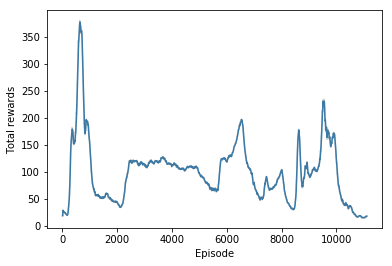

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

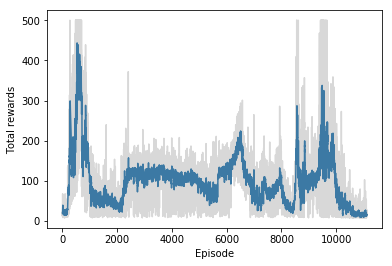

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

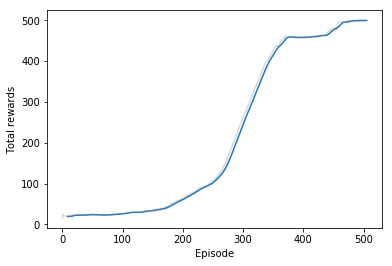

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

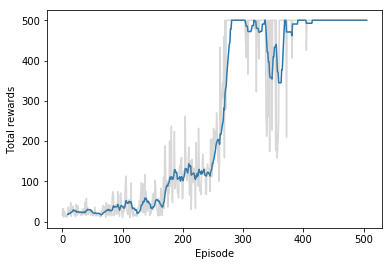

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

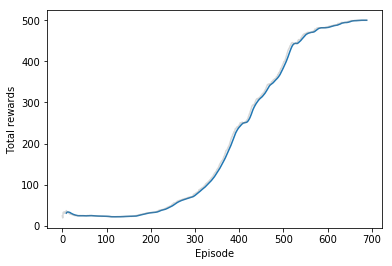

In [51]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

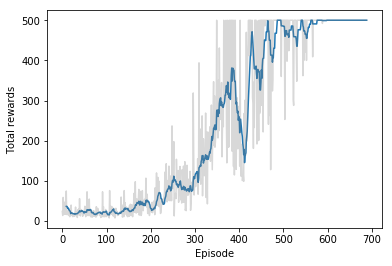

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [53]:
# eps, arr = np.array(dloss_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [54]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
